# Data Description
* TransactionDT: Timedelta from a given reference datetime (not an actual timestamp)
* TransactionAMT: Transaction payment amount in USD
* ProductCD: Product code, the product for each transaction
* card1 - card6: Payment card information, such as card type, card category, issue bank, country, etc.
* addr: Address
* dist: Distance
* P_ and R_emaildomain: Purchaser and recipient email domain
* C1-C14: Counting, such as how many addresses are found to be associated with the payment card, etc. The actual meaning is masked.
* D1-D15: Timedelta, such as days between previous transaction, etc.
* M1-M9: mMatch, such as names on card and address, etc.
* Vxxx: Vesta engineered rich features, including ranking, counting, and other entity relations.

* Categorical Features: ProductCD, card1 - card6, addr1, addr2, P_emaildomain, R_emaildomain, M1 - M9

## Identity Table
* Variables in this table are identity information – network connection information (IP, ISP, Proxy, etc) and digital signature (UA/browser/os/version, etc) associated with transactions. They're collected by Vesta’s fraud protection system and digital security partners. (The field names are masked and pairwise dictionary will not be provided for privacy protection and contract agreement)

* Categorical Features: DeviceType, DeviceInfo, id_12 - id_38

In [1]:
#!pip install missingno

## Importing Libraries

In [2]:
import gc
import time
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import missingno as msno
import plotly.express as px
from matplotlib import pyplot as plt

from sklearn import metrics
from collections import Counter
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier

from sklearn.ensemble import AdaBoostClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
import lightgbm as lgb

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.metrics import Precision, Recall, AUC
from keras.models import Sequential
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Activation, Input, Dense, LSTM
from tensorflow.keras.callbacks import EarlyStopping


import os
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))

import sys
sys.path.append(parent_dir)

import BalanceDataset as balance
import MachineLearningModels as ml_models
import DeepLearningModels as dl_models


pd.set_option('display.max_rows', 999)
pd.set_option('display.max_columns',700)
pd.set_option('display.float_format', lambda x: '%.3f' % x)


import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.filterwarnings("ignore", category=FutureWarning) 
warnings.filterwarnings("ignore", category=UserWarning) 
import shap

## Reduce Memory Usage

In [3]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Memory usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

## Loading Data

In [4]:
train_transaction = pd.read_csv("train_transaction.csv")
train_identity = pd.read_csv("train_identity.csv")

test_transaction = pd.read_csv("test_transaction.csv")
test_identity = pd.read_csv("test_identity.csv")

In [5]:
# Fix Column Name 
fix_col_name = {testIdCol:trainIdCol for testIdCol, trainIdCol in zip(test_identity.columns, train_identity.columns)}
test_identity.rename(columns=fix_col_name, inplace=True)

In [6]:
# Reduce Memory
train_transaction = reduce_mem_usage(train_transaction)
train_identity = reduce_mem_usage(train_identity)

test_transaction = reduce_mem_usage(test_transaction)
test_identity = reduce_mem_usage(test_identity)   

Memory usage decreased to 916.30 Mb (48.4% reduction)
Memory usage decreased to 31.91 Mb (29.3% reduction)
Memory usage decreased to 785.71 Mb (48.3% reduction)
Memory usage decreased to 31.40 Mb (29.3% reduction)


In [7]:
# Merge (transaction - identity)
train = train_transaction.merge(train_identity, on='TransactionID', how='left')
test = test_transaction.merge(test_identity, on='TransactionID', how='left')

In [8]:
# Merge (X_train - X_test)
train_test = pd.concat([train, test], ignore_index=True)

In [9]:
print(f'train dataset has {train.shape[0]} rows and {train.shape[1]} columns.')
print(f'test dataset has {test.shape[0]} rows and {test.shape[1]} columns.')

train dataset has 590540 rows and 434 columns.
test dataset has 506691 rows and 433 columns.


In [10]:
train_test = train_test.copy()
train = train.copy()
test = test.copy()

# Exploratory Data Analysis (EDA)

In [11]:
train.head()

TransactionID  isFraud  TransactionDT  TransactionAmt ProductCD  card1  \
0        2987000        0          86400          68.500         W  13926   
1        2987001        0          86401          29.000         W   2755   
2        2987002        0          86469          59.000         W   4663   
3        2987003        0          86499          50.000         W  18132   
4        2987004        0          86506          50.000         H   4497   

    card2   card3       card4   card5   card6   addr1  addr2   dist1  dist2  \
0     NaN 150.000    discover 142.000  credit 315.000 87.000  19.000    NaN   
1 404.000 150.000  mastercard 102.000  credit 325.000 87.000     NaN    NaN   
2 490.000 150.000        visa 166.000   debit 330.000 87.000 287.000    NaN   
3 567.000 150.000  mastercard 117.000   debit 476.000 87.000     NaN    NaN   
4 514.000 150.000  mastercard 102.000  credit 420.000 87.000     NaN    NaN   

  P_emaildomain R_emaildomain    C1    C2    C3    C4    C5    C6    C7    C8  \
0           NaN           NaN 1.000 1.000 0.000 0.000 0.000 1.000 0.000 0.000   
1     gmail.com           NaN 1.000 1.000 0.000 0.000 0.000 1.000 0.000 0.000   
2   outlook.com           NaN 1.000 1.000 0.000 0.000 0.000 1.000 0.000 0.000   
3     yahoo.com           NaN 2.000 5.000 0.000 0.000 0.000 4.000 0.000 0.000   
4     gmail.com           NaN 1.000 1.000 0.000 0.000 0.000 1.000 0.000 1.000   

     C9   C10   C11   C12    C13   C14      D1      D2     D3     D4    D5  \
0 1.000 0.000 2.000 0.000  1.000 1.000  14.000     NaN 13.000    NaN   NaN   
1 0.000 0.000 1.000 0.000  1.000 1.000   0.000     NaN    NaN  0.000   NaN   
2 1.000 0.000 1.000 0.000  1.000 1.000   0.000     NaN    NaN  0.000   NaN   
3 1.000 0.000 1.000 0.000 25.000 1.000 112.000 112.000  0.000 94.000 0.000   
4 0.000 1.000 1.000 0.000  1.000 1.000   0.000     NaN    NaN    NaN   NaN   

   D6  D7  D8  D9    D10     D11  D12  D13  D14     D15   M1   M2   M3   M4  \
0 NaN NaN NaN NaN 13.000  13.000  NaN  NaN  NaN   0.000    T    T    T   M2   
1 NaN NaN NaN NaN  0.000     NaN  NaN  NaN  NaN   0.000  NaN  NaN  NaN   M0   
2 NaN NaN NaN NaN  0.000 315.000  NaN  NaN  NaN 315.000    T    T    T   M0   
3 NaN NaN NaN NaN 84.000     NaN  NaN  NaN  NaN 111.000  NaN  NaN  NaN   M0   
4 NaN NaN NaN NaN    NaN     NaN  NaN  NaN  NaN     NaN  NaN  NaN  NaN  NaN   

    M5   M6   M7   M8   M9    V1    V2    V3    V4    V5    V6    V7    V8  \
0    F    T  NaN  NaN  NaN 1.000 1.000 1.000 1.000 1.000 1.000 1.000 1.000   
1    T    T  NaN  NaN  NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
2    F    F    F    F    F 1.000 1.000 1.000 1.000 1.000 1.000 1.000 1.000   
3    T    F  NaN  NaN  NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
4  NaN  NaN  NaN  NaN  NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   

     V9   V10   V11   V12   V13   V14   V15   V16   V17   V18   V19   V20  \
0 1.000 0.000 0.000 1.000 1.000 1.000 0.000 0.000 0.000 0.000 1.000 1.000   
1   NaN   NaN   NaN 0.000 0.000 1.000 0.000 0.000 0.000 0.000 1.000 1.000   
2 1.000 0.000 0.000 1.000 1.000 1.000 0.000 0.000 0.000 0.000 1.000 1.000   
3   NaN   NaN   NaN 1.000 1.000 1.000 0.000 0.000 0.000 0.000 1.000 1.000   
4   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   

    V21   V22   V23   V24   V25   V26   V27   V28   V29   V30   V31   V32  \
0 0.000 0.000 1.000 1.000 1.000 1.000 0.000 0.000 0.000 0.000 0.000 0.000   
1 0.000 0.000 1.000 1.000 1.000 1.000 0.000 0.000 0.000 0.000 0.000 0.000   
2 0.000 0.000 1.000 1.000 1.000 1.000 0.000 0.000 0.000 0.000 0.000 0.000   
3 0.000 0.000 1.000 1.000 1.000 1.000 0.000 0.000 0.000 0.000 0.000 0.000   
4   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   

    V33   V34   V35   V36   V37   V38   V39   V40   V41   V42   V43   V44  \
0 0.000 0.000   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
1 0.000 0.000 0.000 0.000 1.000 1.000 0.000 0.000 1.000 0.000 0.000 1.000   
2 0.000 

In [12]:
train.shape

(590540, 434)

In [13]:
train.dtypes

TransactionID       int32
isFraud              int8
TransactionDT       int32
TransactionAmt    float32
ProductCD          object
card1               int16
card2             float32
card3             float32
card4              object
card5             float32
card6              object
addr1             float32
addr2             float32
dist1             float32
dist2             float32
P_emaildomain      object
R_emaildomain      object
C1                float32
C2                float32
C3                float32
C4                float32
C5                float32
C6                float32
C7                float32
C8                float32
C9                float32
C10               float32
C11               float32
C12               float32
C13               float32
C14               float32
D1                float32
D2                float32
D3                float32
D4                float32
D5                float32
D6                float32
D7                float32
D8          

## Missing Values

In [14]:
def missing_values_table(df, na_name=False):
    na_columns = df.columns[df.isnull().sum() > 0]
    n_miss = df[na_columns].isnull().sum().sort_values(ascending=False)
    ratio = (df[na_columns].isnull().sum() / df.shape[0] * 100).sort_values(ascending=False)
    missing_df = pd.DataFrame({'n_miss': n_miss, 'ratio': np.round(ratio, 1)})
    print(missing_df, end="\n")
    if na_name:
        return na_columns

In [15]:
missing_values_table(train, na_name=False)

               n_miss  ratio
id_24          585793 99.200
id_25          585408 99.100
id_07          585385 99.100
id_08          585385 99.100
id_21          585381 99.100
id_26          585377 99.100
id_27          585371 99.100
id_23          585371 99.100
id_22          585371 99.100
dist2          552913 93.600
D7             551623 93.400
id_18          545427 92.400
D13            528588 89.500
D14            528353 89.500
D12            525823 89.000
id_03          524216 88.800
id_04          524216 88.800
D6             517353 87.600
id_33          517251 87.600
id_10          515614 87.300
id_09          515614 87.300
D8             515614 87.300
D9             515614 87.300
id_30          512975 86.900
id_32          512954 86.900
id_34          512735 86.800
id_14          510496 86.400
V155           508595 86.100
V138           508595 86.100
V156           508595 86.100
V157           508595 86.100
V158           508595 86.100
V154           508595 86.100
V153          

## Exploring Target

In [16]:
def show_graphs(df):
    fraud_counts = df['isFraud'].value_counts()

    # pie chart
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15, 5))

    ax1.pie(fraud_counts, labels=['Non-fraudulent', 'Fraudulent'], colors=['lightblue', 'lightcoral'], autopct='%1.1f%%')
    ax1.set_title('Transaction Class Distribution')

    # bar plot
    ax2.bar(['Non-fraudulent', 'Fraudulent'], fraud_counts.values, color=['lightblue', 'lightcoral'])
    ax2.set_xlabel('Transaction Class')
    ax2.set_ylabel('Number of Transactions')
    ax2.set_title('Credit Card Fraud Detection')
    for i in ax2.containers:
        ax2.bar_label(i,)

    plt.show()

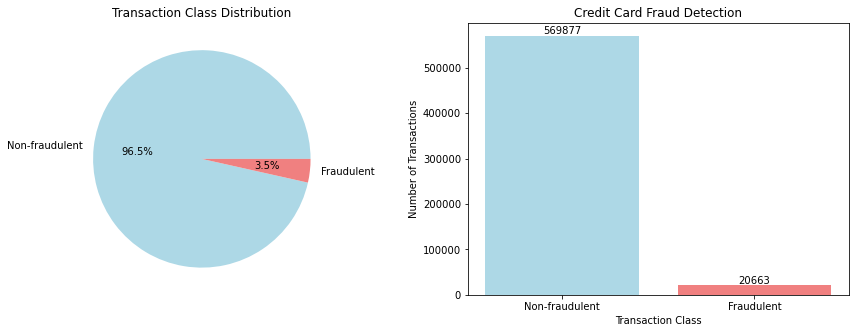

In [17]:
show_graphs(train)

In [18]:
train_non_fraudulent = train[train['isFraud']==0]
train_fraudulent = train[train['isFraud']==1]

In [19]:
train_non_fraudulent_count = train_non_fraudulent["isFraud"].value_counts()
train_fraudulent_count = train_fraudulent["isFraud"].value_counts()

In [20]:
print(f"Normal transaction count = {train_non_fraudulent_count[0]} (% {train_non_fraudulent_count[0]/len(train)*100})")
print(f"Fraudulent transaction count = {train_fraudulent_count[1]} (% {train_fraudulent_count[1]/len(train)*100})")

Normal transaction count = 569877 (% 96.50099908558268)
Fraudulent transaction count = 20663 (% 3.4990009144173126)


In [21]:
train_non_fraudulent

TransactionID  isFraud  TransactionDT  TransactionAmt ProductCD  \
0             2987000        0          86400          68.500         W   
1             2987001        0          86401          29.000         W   
2             2987002        0          86469          59.000         W   
3             2987003        0          86499          50.000         W   
4             2987004        0          86506          50.000         H   
...               ...      ...            ...             ...       ...   
590535        3577535        0       15811047          49.000         W   
590536        3577536        0       15811049          39.500         W   
590537        3577537        0       15811079          30.953         W   
590538        3577538        0       15811088         117.000         W   
590539        3577539        0       15811131         280.000         W   

        card1   card2   card3       card4   card5   card6   addr1  addr2  \
0       13926     NaN 150.000    discover 142.000  credit 315.000 87.000   
1        2755 404.000 150.000  mastercard 102.000  credit 325.000 87.000   
2        4663 490.000 150.000        visa 166.000   debit 330.000 87.000   
3       18132 567.000 150.000  mastercard 117.000   debit 476.000 87.000   
4        4497 514.000 150.000  mastercard 102.000  credit 420.000 87.000   
...       ...     ...     ...         ...     ...     ...     ...    ...   
590535   6550     NaN 150.000        visa 226.000   debit 272.000 87.000   
590536  10444 225.000 150.000  mastercard 224.000   debit 204.000 87.000   
590537  12037 595.000 150.000  mastercard 224.000   debit 231.000 87.000   
590538   7826 481.000 150.000  mastercard 224.000   debit 387.000 87.000   
590539  15066 170.000 150.000  mastercard 102.000  credit 299.000 87.000   

         dist1  dist2 P_emaildomain R_emaildomain    C1    C2    C3    C4  \
0       19.000    NaN           NaN           NaN 1.000 1.000 0.000 0.000   
1          NaN    NaN     gmail.com           NaN 1.000 1.000 0.000 0.000   
2      287.000    NaN   outlook.com           NaN 1.000 1.000 0.000 0.000   
3          NaN    NaN     yahoo.com           NaN 2.000 5.000 0.000 0.000   
4          NaN    NaN     gmail.com           NaN 1.000 1.000 0.000 0.000   
...        ...    ...           ...           ...   ...   ...   ...   ...   
590535  48.000    NaN           NaN           NaN 2.000 1.000 0.000 0.000   
590536     NaN    NaN     gmail.com           NaN 1.000 1.000 0.000 0.000   
590537     NaN    NaN     gmail.com           NaN 1.000 1.000 0.000 0.000   
590538   3.000    NaN       aol.com           NaN 1.000 1.000 0.000 0.000   
590539     NaN    NaN     gmail.com           NaN 2.000 1.000 0.000 0.000   

          C5    C6    C7    C8    C9   C10   C11   C12    C13   C14      D1  \
0      0.000 1.000 0.000 0.000 1.000 0.000 2.000 0.000  1.000 1.000  14.000   
1      0.000 1.000 0.000 0.000 0.000 0.000 1.000 0.000  1.000 1.000   0.000   
2      0.000 1.000 0.000 0.000 1.000 0.000 1.000 0.000  1.000 1.000   0.000   
3      0.000 4.000 0.000 0.000 1.000 0.000 1.000 0.000 25.000 1.000 112.000   
4      0.000 1.000 0.000 1.000 0.000 1.000 1.000 0.000  1.000 1.000   0.000   
...      ...   ...   ...   ...   ...   ...   ...   ...    ...   ...     ...   
590535 1.000 0.000 0.000 0.000 2.000 0.000 1.000 0.000  3.000 2.000  29.000   
590536 0.000 1.000 0.000 0.000 1.000 0.000 1.000 0.000  1.000 1.000   0.000   
590537 1.000 1.000 0.000 0.000 1.000 0.000 1.000 0.000  1.000 1.000   0.000   
590538 0.000 3.000 0.000 0.000 2.000 0.000 1.000 1.000  5.000 1.000  22.000   
590539 1.000 1.000 0.000 0.000 2.000 0.000 1.000 0.000  1.000 1.000   0.000   

            D2     D3     D4    D5  D6  D7  D8  D9    D10     D11  D12  D13  \
0          NaN 13.000    NaN   NaN NaN NaN NaN NaN 13.000  13.000  NaN  NaN   
1          NaN    NaN  0.000   NaN NaN NaN NaN NaN  0.000     NaN  NaN  NaN   
2          NaN    NaN  0.000   NaN NaN NaN NaN NaN  0.000 315.000  NaN  NaN   
3   

In [22]:
train_fraudulent

TransactionID  isFraud  TransactionDT  TransactionAmt ProductCD  \
203           2987203        1          89760         445.000         W   
240           2987240        1          90193          37.094         C   
243           2987243        1          90246          37.094         C   
245           2987245        1          90295          37.094         C   
288           2987288        1          90986         155.500         C   
...               ...      ...            ...             ...       ...   
590361        3577361        1       15807368        1224.000         W   
590364        3577364        1       15807516          69.938         C   
590368        3577368        1       15807677         100.000         H   
590372        3577372        1       15807758         117.000         W   
590526        3577526        1       15810876         250.000         R   

        card1   card2   card3             card4   card5   card6   addr1  \
203     18268 583.000 150.000              visa 226.000  credit 251.000   
240     13413 103.000 185.000              visa 137.000  credit     NaN   
243     13413 103.000 185.000              visa 137.000  credit     NaN   
245     13413 103.000 185.000              visa 137.000  credit     NaN   
288     16578 545.000 185.000              visa 226.000  credit     NaN   
...       ...     ...     ...               ...     ...     ...     ...   
590361   3278 453.000 150.000              visa 226.000   debit 191.000   
590364   5812 408.000 185.000        mastercard 224.000   debit     NaN   
590368   6758 399.000 150.000  american express 146.000  credit 299.000   
590372  14037 111.000 150.000              visa 226.000  credit 272.000   
590526   1214 174.000 150.000              visa 226.000  credit 272.000   

        addr2  dist1  dist2 P_emaildomain R_emaildomain    C1    C2    C3  \
203    87.000    NaN    NaN       aol.com           NaN 2.000 2.000 0.000   
240       NaN    NaN    NaN   hotmail.com   hotmail.com 0.000 1.000 0.000   
243       NaN    NaN    NaN   hotmail.com   hotmail.com 1.000 1.000 0.000   
245       NaN    NaN    NaN   hotmail.com   hotmail.com 2.000 1.000 0.000   
288       NaN    NaN    NaN   outlook.com   outlook.com 1.000 1.000 0.000   
...       ...    ...    ...           ...           ...   ...   ...   ...   
590361 87.000 26.000    NaN     yahoo.com           NaN 3.000 1.000 0.000   
590364    NaN    NaN 24.000   hotmail.com   hotmail.com 1.000 3.000 0.000   
590368 87.000    NaN    NaN   hotmail.com   hotmail.com 1.000 1.000 0.000   
590372 87.000    NaN    NaN     yahoo.com           NaN 1.000 1.000 0.000   
590526 87.000    NaN    NaN     gmail.com     gmail.com 1.000 1.000 0.000   

          C4    C5    C6    C7    C8    C9   C10   C11   C12   C13   C14  \
203    0.000 0.000 2.000 0.000 0.000 2.000 0.000 1.000 0.000 4.000 2.000   
240    1.000 0.000 1.000 1.000 1.000 0.000 1.000 1.000 1.000 0.000 0.000   
243    1.000 0.000 1.000 1.000 1.000 0.000 1.000 1.000 1.000 0.000 0.000   
245    1.000 0.000 1.000 1.000 1.000 0.000 1.000 1.000 1.000 0.000 0.000   
288    1.000 0.000 1.000 1.000 1.000 0.000 1.000 1.000 1.000 0.000 0.000   
...      ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   
590361 0.000 0.000 1.000 0.000 0.000 2.000 0.000 1.000 0.000 6.000 3.000   
590364 1.000 0.000 1.000 1.000 3.000 0.000 2.000 2.000 2.000 0.000 0.000   
590368 1.000 0.000 1.000 0.000 1.000 0.000 1.000 1.000 0.000 1.000 1.000   
590372 0.000 0.000 1.000 0.000 0.000 1.000 0.000 1.000 0.000 1.000 1.000   
590526 1.000 0.000 1.000 0.000 1.000 0.000 1.000 1.000 0.000 1.000 1.000   

            D1     D2     D3      D4     D5      D6     D7     D8    D9  \
203     57.000 57.000 52.000   0.000    NaN     NaN    NaN    NaN   NaN   
240      0.000    NaN    NaN   0.000    NaN   0.000    NaN 45.031 0.042   
243      0.000    NaN    NaN   0.000  0.000   0.000  0.000 45.031 0.042   
245      0.000    NaN    NaN   0.000  0.000   0.000  0.000 45.031 0.

## Exploring Continuous Features

In [23]:
def plot_distributions_cont_features(train, test, train_fraudulent, train_non_fraudulent, col):
    plt.figure(figsize=(15, 10))
    plt.suptitle(f'{col} Distributions ', fontsize=24)


    plt.subplot(221)
    sns.distplot(train[col], color='lightskyblue')
    plt.title('Train Set Distribution')

    plt.subplot(222)
    sns.distplot(test[col], color='lightcoral')
    plt.title('Test Set Distribution')

    plt.subplot(223)
    sns.distplot(train_fraudulent[col], color='purple', label='Fraud')
    sns.distplot(train_non_fraudulent[col], color='lightcoral', label='Non-Fraud')
    plt.title('Fraud vs non-Fraud Distribution')
    plt.legend()
    
    plt.subplot(224)
    fraud_count = len(train_fraudulent)
    non_fraud_count = len(train_non_fraudulent)
    labels = ['Fraud', 'Non-Fraud']
    sizes = [fraud_count, non_fraud_count]
    colors = ['lightskyblue', 'lightcoral']
    explode = (0.1, 0)  # explode the first slice
    plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%',
            shadow=True, startangle=90)
    plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    plt.title('Transaction Distribution: Fraud vs Non-Fraud')

    plt.tight_layout()  # Adjust the spacing between subplots
    plt.show()


### **TransactionDT**
* TransactionDT : is a timedelta from a given reference datetime (not an actual timestamp).
* TransactionDT is one of the features that can cause problems.
* It seems as if there is a time difference between testing and train operations.

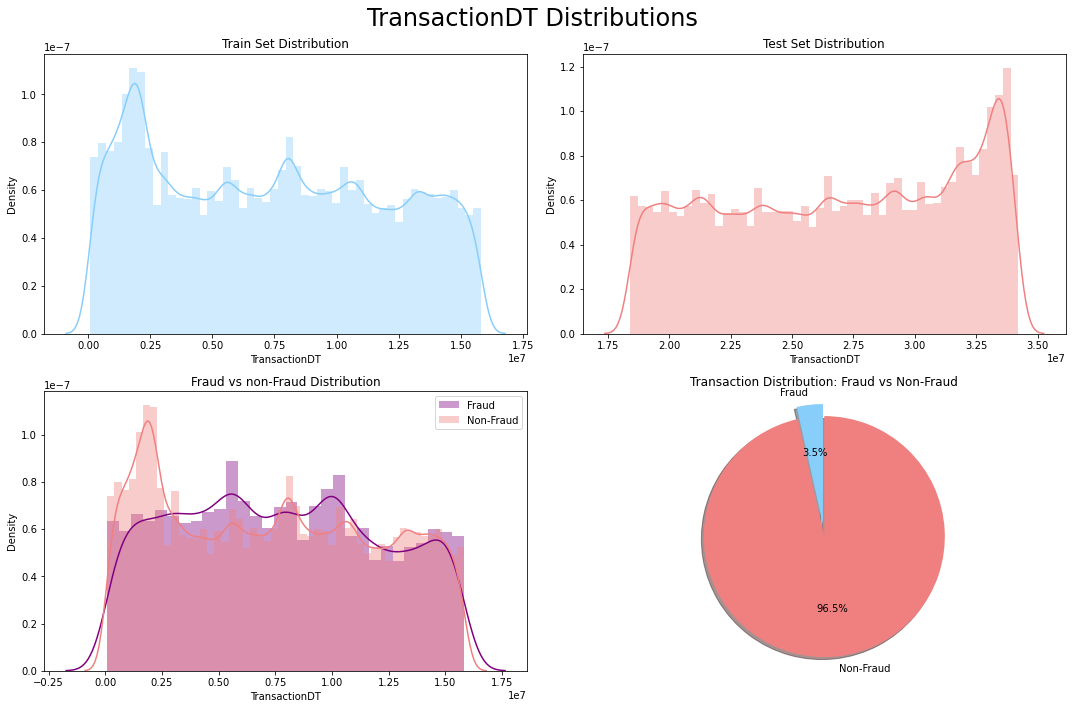

In [24]:
plot_distributions_cont_features(train, test, train_fraudulent, train_non_fraudulent, "TransactionDT")

### Feature extraction

In [25]:
START_DATE = '2017-12-01'
startdate = pd.to_datetime(START_DATE)

train_test['New_Date'] = startdate + pd.to_timedelta(train_test['TransactionDT'], unit='s')
train_test['New_Date_YMD'] = train_test['New_Date'].dt.strftime('%Y-%m-%d')
train_test['New_Date_YearMonth'] = train_test['New_Date'].dt.strftime('%Y-%m')
train_test['New_Date_Weekday'] = train_test['New_Date'].dt.dayofweek
train_test['New_Date_Hour'] = train_test['New_Date'].dt.hour
train_test['New_Date_Day'] = train_test['New_Date'].dt.day

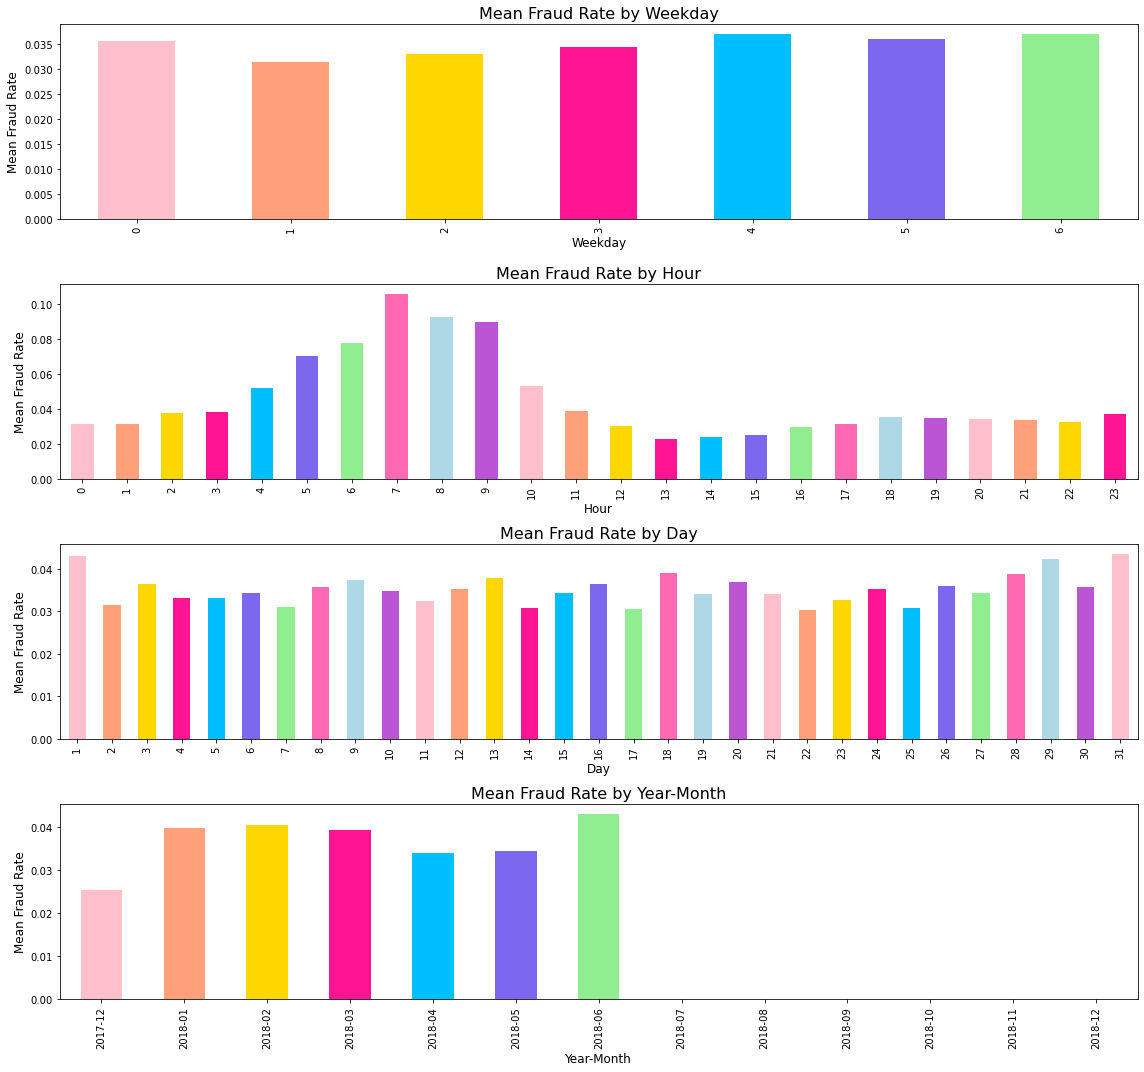

In [26]:
fig, ax = plt.subplots(4, 1, figsize=(16, 15))

colors = ['#FFC0CB', '#FFA07A', '#FFD700', '#FF1493', '#00BFFF', '#7B68EE', '#90EE90', '#FF69B4', '#ADD8E6', '#BA55D3']

train_test.groupby('New_Date_Weekday')['isFraud'].mean().plot.bar(ax=ax[0], color=colors)
train_test.groupby('New_Date_Hour')['isFraud'].mean().plot.bar(ax=ax[1], color=colors)
train_test.groupby('New_Date_Day')['isFraud'].mean().plot.bar(ax=ax[2], color=colors)
train_test.groupby('New_Date_YearMonth')['isFraud'].mean().plot.bar(ax=ax[3], color=colors)

ax[0].set_title('Mean Fraud Rate by Weekday', fontsize=16)
ax[1].set_title('Mean Fraud Rate by Hour', fontsize=16)
ax[2].set_title('Mean Fraud Rate by Day', fontsize=16)
ax[3].set_title('Mean Fraud Rate by Year-Month', fontsize=16)

ax[0].set_xlabel('Weekday', fontsize=12)
ax[1].set_xlabel('Hour', fontsize=12)
ax[2].set_xlabel('Day', fontsize=12)
ax[3].set_xlabel('Year-Month', fontsize=12)

ax[0].set_ylabel('Mean Fraud Rate', fontsize=12)
ax[1].set_ylabel('Mean Fraud Rate', fontsize=12)
ax[2].set_ylabel('Mean Fraud Rate', fontsize=12)
ax[3].set_ylabel('Mean Fraud Rate', fontsize=12)

plt.tight_layout()  # Adjust the spacing between subplots
plt.show()


### **TransactionAmt**
* TransactionAmt : The ammount of transaction.
* Applied log transform in order to better show the distribution of data. Otherwise very large transactions skew the distribution.
* The mean of the fraud transaction amount is larger than the mean of non - fraud transaction amount.
* And also , the lowest and highest transaction amounts seem to be more likely to be fraudulent transactions.

In [27]:
print(' Fraud TransactionAmt mean      :  '+str(train_fraudulent['TransactionAmt'].mean()))
print(' Non - Fraud TransactionAmt mean:  '+str(train_non_fraudulent['TransactionAmt'].mean()))

 Fraud TransactionAmt mean      :  149.24530029296875
 Non - Fraud TransactionAmt mean:  134.37013244628906


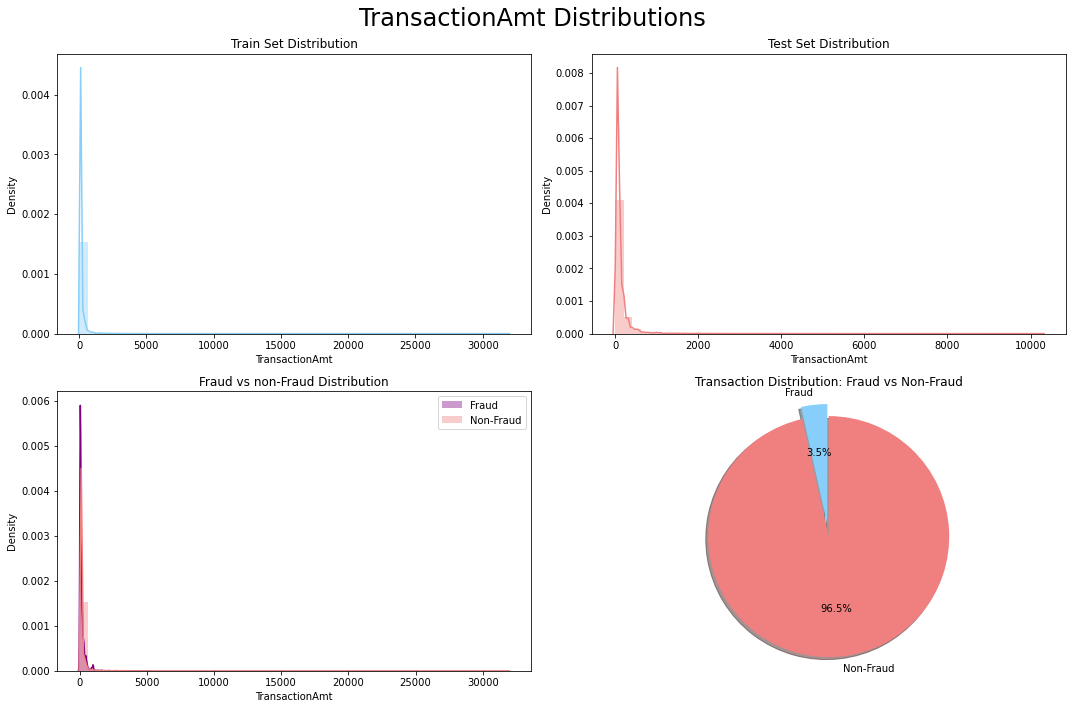

In [28]:
plot_distributions_cont_features(train, test, train_fraudulent, train_non_fraudulent, "TransactionAmt")

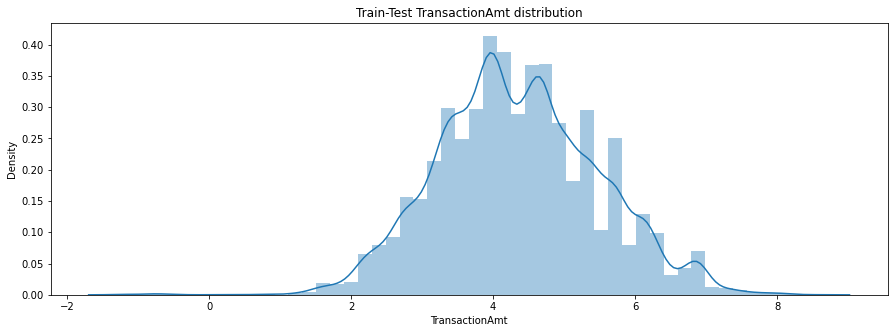

In [29]:
plt.figure(figsize=(15,5))
sns.distplot(train_fraudulent["TransactionAmt"].apply(np.log))
plt.title('Train-Test TransactionAmt distribution')
plt.show()

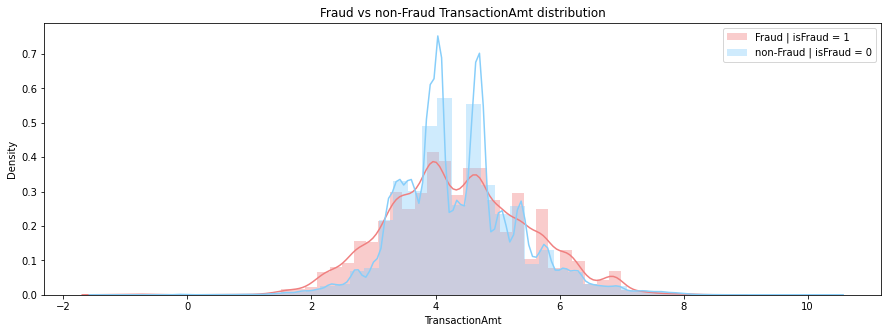

In [30]:
plt.figure(figsize=(15,5))
sns.distplot(train_fraudulent["TransactionAmt"].apply(np.log), label = 'Fraud | isFraud = 1', color= "lightcoral")
sns.distplot(train_non_fraudulent["TransactionAmt"].apply(np.log), label = 'non-Fraud | isFraud = 0', color ="lightskyblue")
plt.title('Fraud vs non-Fraud TransactionAmt distribution')
plt.legend()
plt.show()

### **dist1 & dist2**
* Perhaps this could be the distance of the transaction vs. the card owner's home/work address.

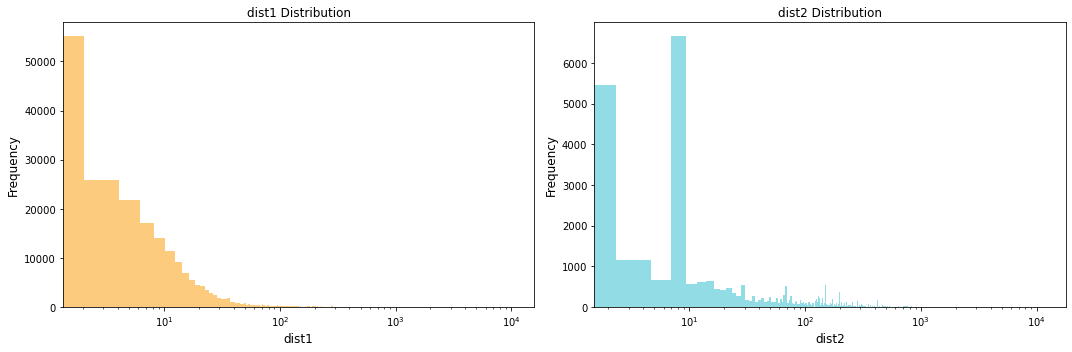

In [31]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

colors = ['#FCCB7E', '#92DCE5']  # Soft colors

train['dist1'].plot(kind='hist', bins=5000, ax=ax1, title='dist1 Distribution', logx=True, color=colors[0])
train['dist2'].plot(kind='hist', bins=5000, ax=ax2, title='dist2 Distribution', logx=True, color=colors[1])

ax1.set_xlabel('dist1', fontsize=12)
ax1.set_ylabel('Frequency', fontsize=12)
ax2.set_xlabel('dist2', fontsize=12)
ax2.set_ylabel('Frequency', fontsize=12)

plt.tight_layout()
plt.show()


## Exploring Categorical Features

In [32]:
def visualize_distributions(df, col, lim=2000):
    tmp = pd.crosstab(df[col], df['isFraud'], normalize='index') * 100
    tmp = tmp.reset_index()
    tmp.rename(columns={0: 'NoFraud', 1: 'Fraud'}, inplace=True)
    total = len(df)

    plt.figure(figsize=(20, 14))
    plt.suptitle(f'{col} Distributions ', fontsize=24)

    plt.subplot(221)
    g = sns.countplot(x=col, hue='isFraud', data=df, order=list(tmp[col].values))
    g.set_title(f"Count of {col} and Fraud vs. Non-Fraud Transactions", fontsize=20)
    g.set_xlabel(f"{col} Category Names", fontsize=16)
    g.set_ylabel("Count", fontsize=17)
    g.set_xticklabels(g.get_xticklabels(), rotation=45)

    plt.subplot(222)
    g2 = sns.barplot(x=col, y='Fraud', data=tmp, order=list(tmp[col].values), color='cyan')
    g2.set_title(f"Percentage of Fraud Transactions per {col}", fontsize=20)
    g2.set_xlabel(f"{col} Category Names", fontsize=16)
    g2.set_ylabel("% Fraud Transactions", fontsize=17)
    g2.set_xticklabels(g2.get_xticklabels(), rotation=45)

    plt.subplot(223)
    g3 = sns.countplot(x=col, data=df, order=list(tmp[col].values))
    g3.set_title(f"Count of {col} (New subplot)", fontsize=20)
    g3.set_xlabel(f"{col} Category Names", fontsize=16)
    g3.set_ylabel("Count", fontsize=17)
    g3.set_xticklabels(g3.get_xticklabels(), rotation=45)
    
    plt.subplot(224)
    explode = [0, 0.1]  # Explode the "Fraud" slice
    labels = ['Not Fraud', 'Fraud']
    sizes = [tmp['NoFraud'].values[0], tmp['Fraud'].values[0]]
    plt.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', startangle=90, colors=['purple', 'pink'])
    plt.axis('equal')
    plt.title(f"Percentage of Fraud Transactions for {col}", fontsize=20)

    plt.subplots_adjust(hspace=0.5)
    plt.show()

In [33]:
categorical_columns = train.select_dtypes(include=['object'])
categorical_columns.columns

Index(['ProductCD', 'card4', 'card6', 'P_emaildomain', 'R_emaildomain', 'M1',
       'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'id_12', 'id_15',
       'id_16', 'id_23', 'id_27', 'id_28', 'id_29', 'id_30', 'id_31', 'id_33',
       'id_34', 'id_35', 'id_36', 'id_37', 'id_38', 'DeviceType',
       'DeviceInfo'],
      dtype='object')

- We'll cover the m and id values in another section.

In [34]:
cat_columns = ['isFraud','ProductCD','addr1', 'addr2', 'P_emaildomain','R_emaildomain','DeviceType','DeviceInfo']

In [35]:
train[cat_columns].nunique()

isFraud             2
ProductCD           5
addr1             332
addr2              74
P_emaildomain      59
R_emaildomain      60
DeviceType          2
DeviceInfo       1786
dtype: int64

### **ProductCD**
*  W, C and R are the most frequent values.
* 75.45% of observations belong to product W.
* 1.97% of observations belong to product S.
* Approximately 12% of transactions with product C are fraudulent.
* Approximately 2% of transactions with product W are fraudulent.

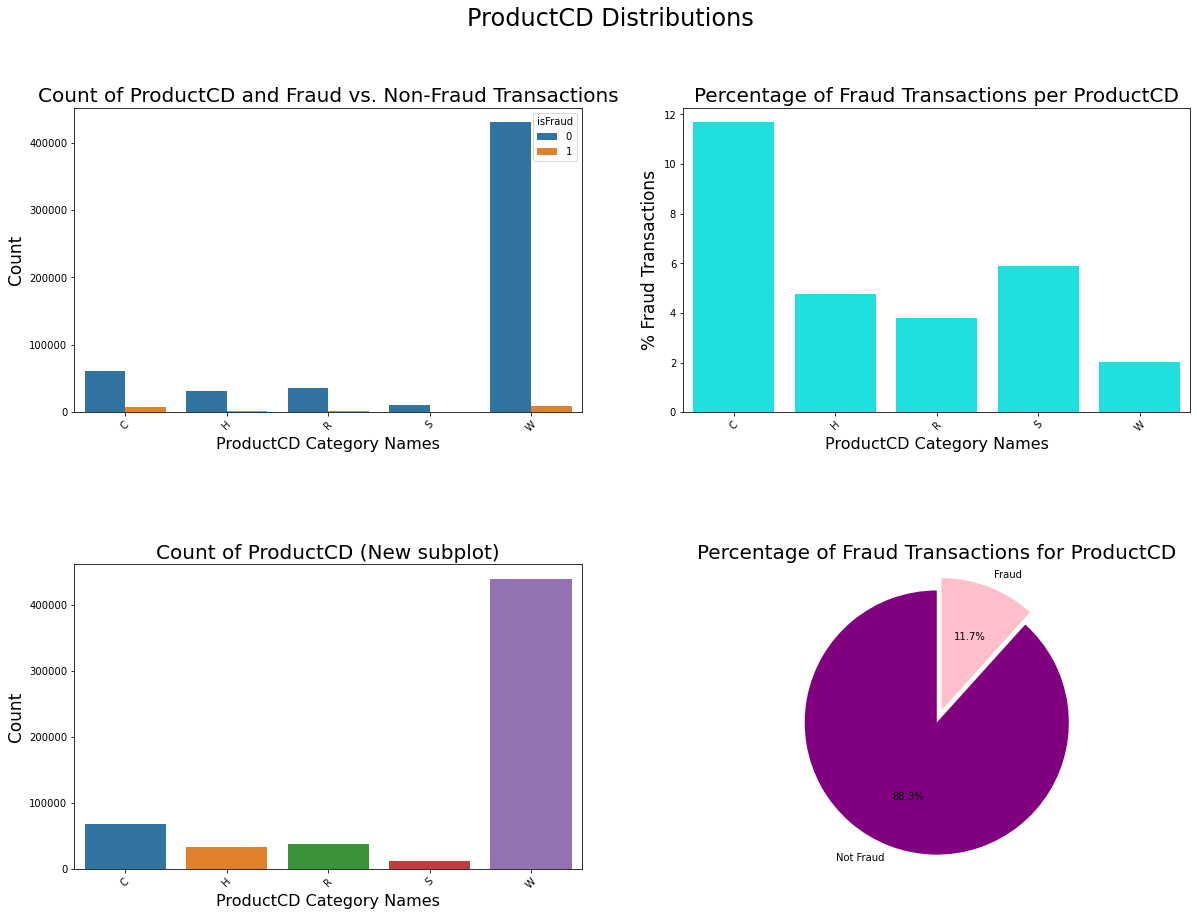

In [36]:
visualize_distributions(train, 'ProductCD')

### **addr1 - addr2**
* It was stated that although these features appear numerical, they are categorical.

In [37]:
train['addr1'].value_counts().head(20)

299.000    46335
325.000    42751
204.000    42020
264.000    39870
330.000    26287
315.000    23078
441.000    20827
272.000    20141
123.000    16105
126.000    15243
184.000    15160
337.000    15149
191.000    14979
181.000    13856
143.000     9806
476.000     9478
310.000     8486
472.000     8478
327.000     8425
512.000     8268
Name: addr1, dtype: int64

In [38]:
train['addr2'].value_counts().head(20)

87.000     520481
60.000       3084
96.000        638
32.000         91
65.000         82
16.000         55
31.000         47
19.000         33
26.000         25
27.000         20
69.000         17
59.000         17
34.000         16
43.000         12
102.000        11
29.000         11
98.000         11
68.000         10
57.000         10
78.000          8
Name: addr2, dtype: int64

In [39]:
train.loc[train['addr1'].isin(train['addr1'].value_counts()[train['addr1'].value_counts() <= 5000 ].index), 'addr1'] = "Others"
train.loc[train['addr2'].isin(train['addr2'].value_counts()[train['addr2'].value_counts() <= 50 ].index), 'addr2'] = "Others"

test.loc[test['addr1'].isin(test.addr1.value_counts()[test['addr1'].value_counts() <= 5000 ].index), 'addr1'] = "Others"
test.loc[test['addr2'].isin(test.addr2.value_counts()[test['addr2'].value_counts() <= 50 ].index), 'addr2'] = "Others"

In [40]:
train['addr1'] = train['addr1'].fillna("None")
test['addr1'] = test['addr1'].fillna("None")

train['addr2'] = train['addr2'].fillna("None")
test['addr2'] = test['addr2'].fillna("None")

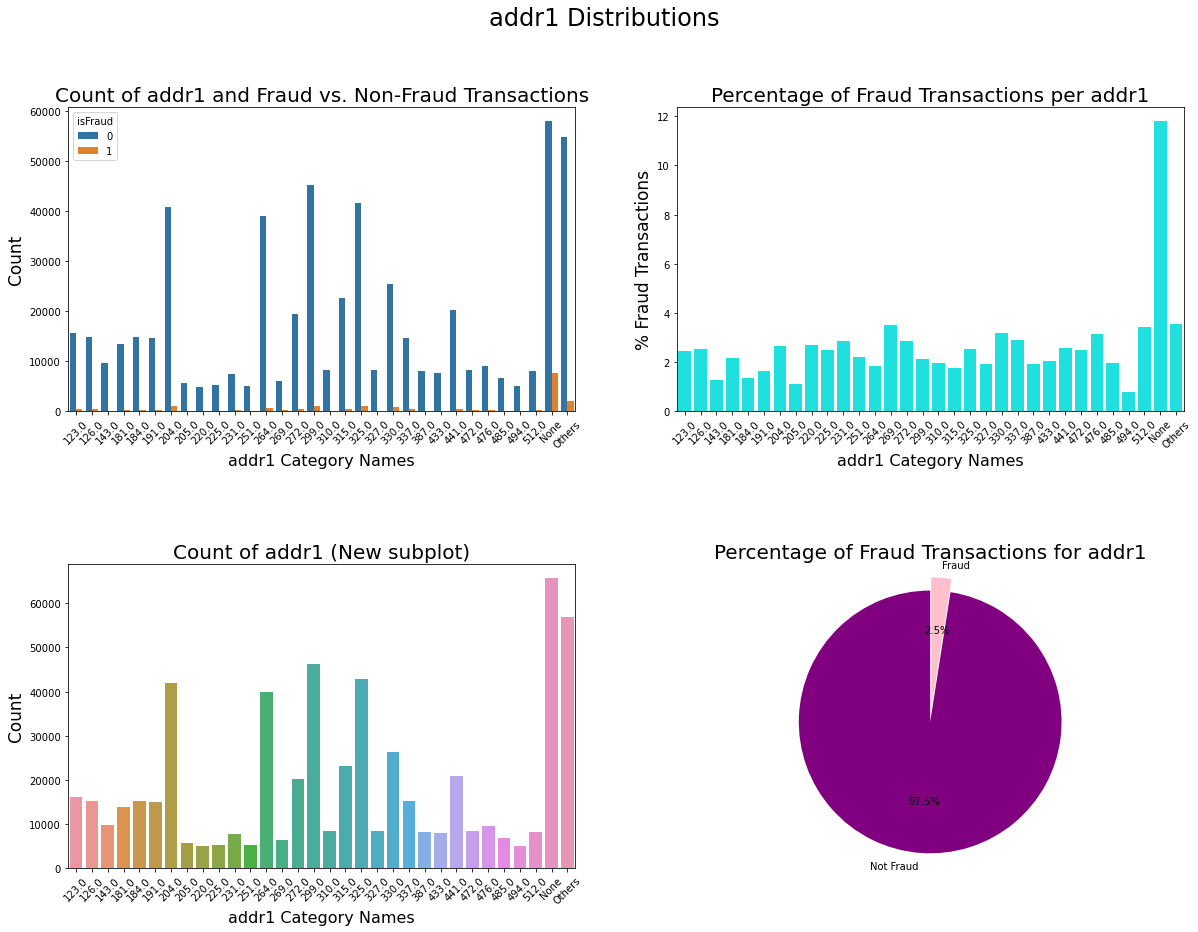

In [41]:
visualize_distributions(train, 'addr1')

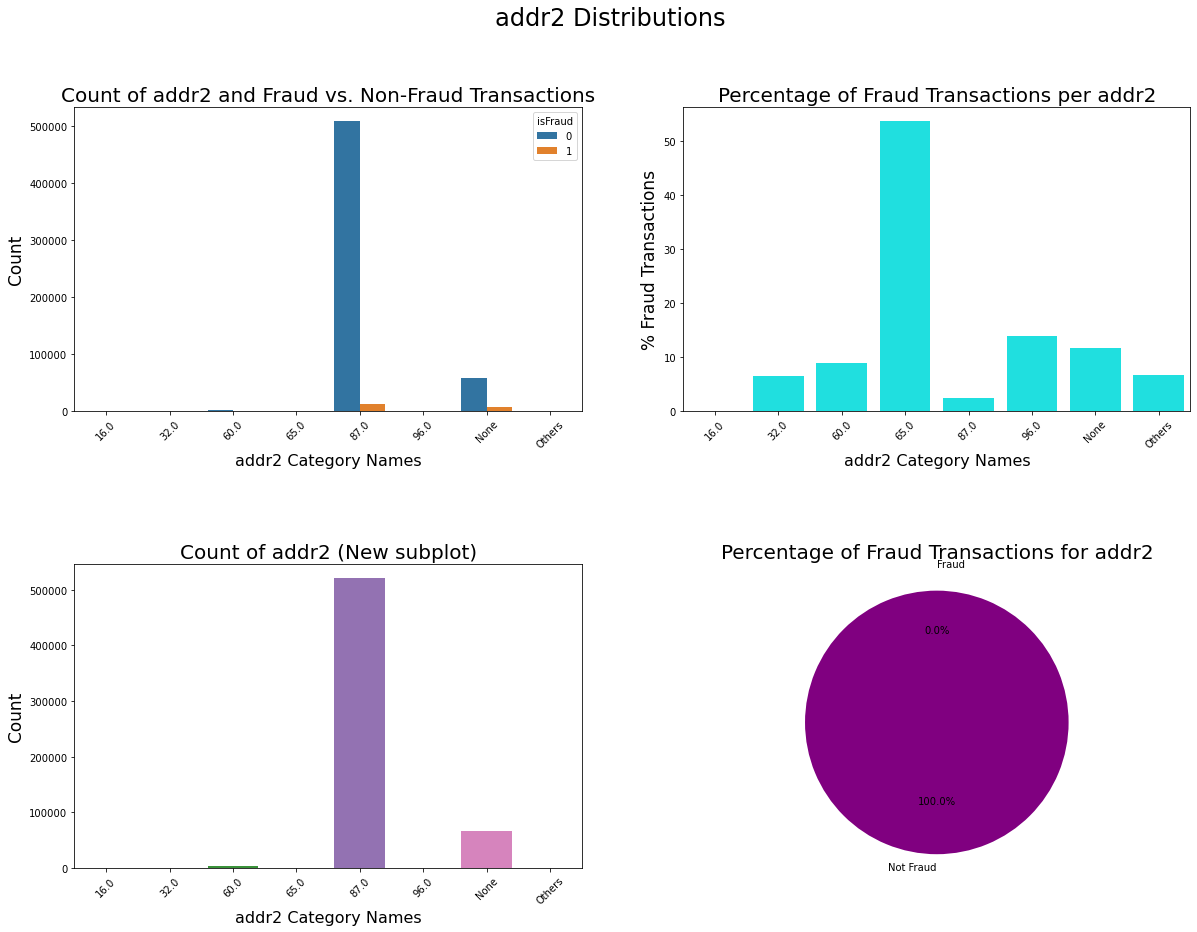

In [42]:
visualize_distributions(train, 'addr2')

### **P-emaildomain & R-emaildomain**
* We can see a very similar distribution in both email domain features.
* We have high values in google and icloud frauds.

**P-emaildomain**
* I will group all e-mail domains by the respective enterprises.
* Also, I will set as "Others" all values with less than 500 entries

In [43]:
train['P_emaildomain'].value_counts()

gmail.com           228355
yahoo.com           100934
hotmail.com          45250
anonymous.com        36998
aol.com              28289
comcast.net           7888
icloud.com            6267
outlook.com           5096
msn.com               4092
att.net               4033
live.com              3041
sbcglobal.net         2970
verizon.net           2705
ymail.com             2396
bellsouth.net         1909
yahoo.com.mx          1543
me.com                1522
cox.net               1393
optonline.net         1011
charter.net            816
live.com.mx            749
rocketmail.com         664
mail.com               559
earthlink.net          514
gmail                  496
outlook.es             438
mac.com                436
juno.com               322
aim.com                315
hotmail.es             305
roadrunner.com         305
windstream.net         305
hotmail.fr             295
frontier.com           280
embarqmail.com         260
web.de                 240
netzero.com            230
t

In [44]:
email_mapping = {
    'gmail.com': 'Google',
    'gmail': 'Google',
    'yahoo.com': 'Yahoo Mail',
    'yahoo.com.mx': 'Yahoo Mail',
    'yahoo.co.uk': 'Yahoo Mail',
    'yahoo.co.jp': 'Yahoo Mail',
    'yahoo.de': 'Yahoo Mail',
    'yahoo.fr': 'Yahoo Mail',
    'yahoo.es': 'Yahoo Mail',
    'hotmail.com': 'Microsoft',
    'outlook.com': 'Microsoft',
    'msn.com': 'Microsoft',
    'live.com.mx': 'Microsoft',
    'hotmail.es': 'Microsoft',
    'hotmail.co.uk': 'Microsoft',
    'hotmail.de': 'Microsoft',
    'outlook.es': 'Microsoft',
    'live.com': 'Microsoft',
    'live.fr': 'Microsoft'
}

In [45]:
email_counts = train['P_emaildomain'].value_counts()
rare_emails = email_counts[email_counts <= 500].index
email_mapping.update({email: 'Others' for email in rare_emails})

train['P_emaildomain'] = train['P_emaildomain'].replace(email_mapping)
train['P_emaildomain'].fillna("NoInfo", inplace=True)

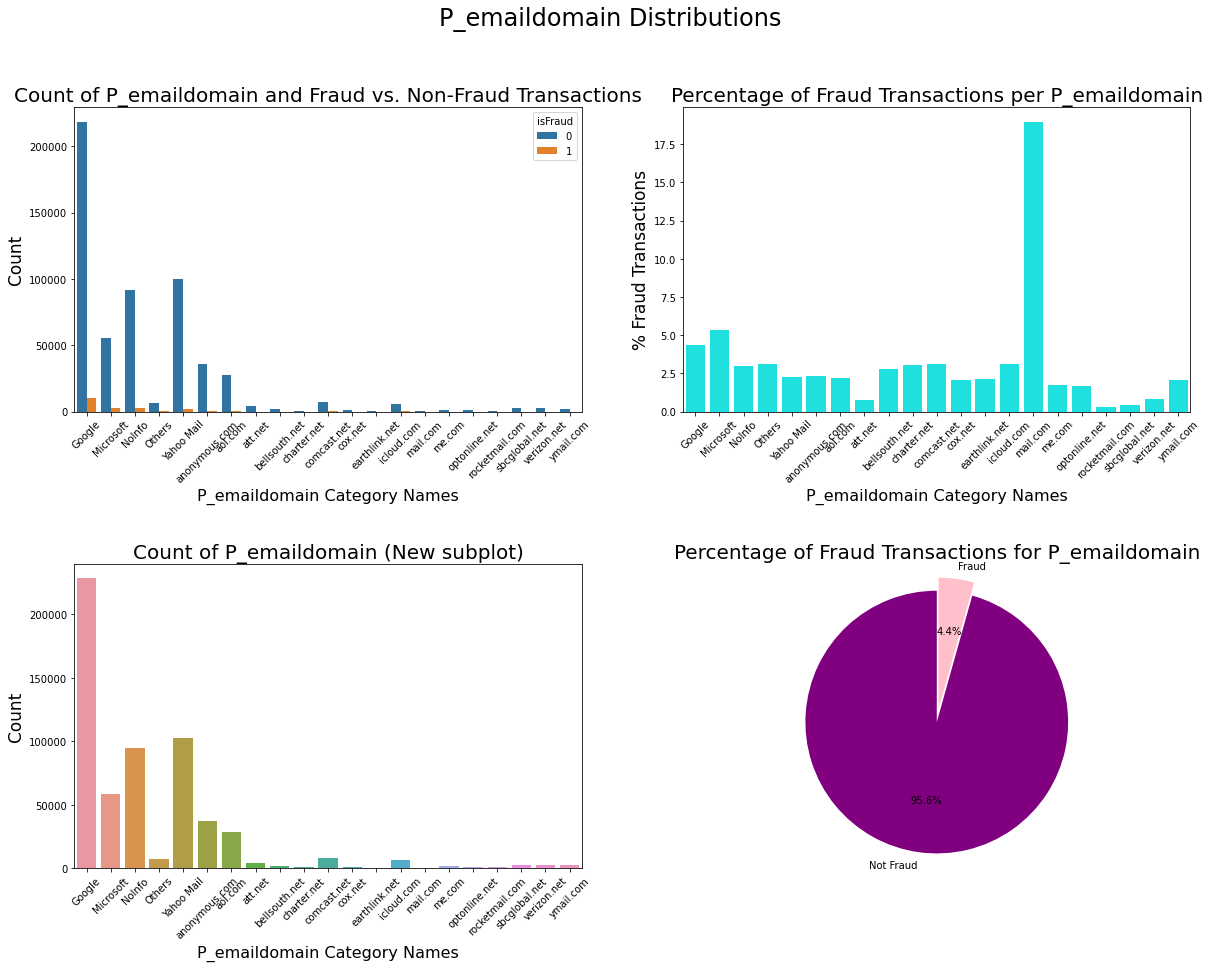

In [46]:
visualize_distributions(train, 'P_emaildomain')

**R-emaildomain**
* I will group all e-mail domains by the respective enterprises.
* I will set as "Others" all values with less than 300 entries.

In [47]:
train['R_emaildomain'].value_counts()

gmail.com           57147
hotmail.com         27509
anonymous.com       20529
yahoo.com           11842
aol.com              3701
outlook.com          2507
comcast.net          1812
yahoo.com.mx         1508
icloud.com           1398
msn.com               852
live.com              762
live.com.mx           754
verizon.net           620
me.com                556
sbcglobal.net         552
cox.net               459
outlook.es            433
att.net               430
bellsouth.net         422
hotmail.fr            293
hotmail.es            292
web.de                237
mac.com               218
ymail.com             207
prodigy.net.mx        207
optonline.net         187
gmx.de                147
yahoo.fr              137
charter.net           127
mail.com              122
hotmail.co.uk         105
gmail                  95
earthlink.net          79
yahoo.de               75
rocketmail.com         69
embarqmail.com         68
scranton.edu           63
yahoo.es               57
live.fr     

In [48]:
email_counts = train['R_emaildomain'].value_counts()
rare_emails = email_counts[email_counts <= 300].index
email_mapping.update({email: 'Others' for email in rare_emails})

train['R_emaildomain'] = train['R_emaildomain'].replace(email_mapping)
train['R_emaildomain'].fillna("NoInfo", inplace=True)

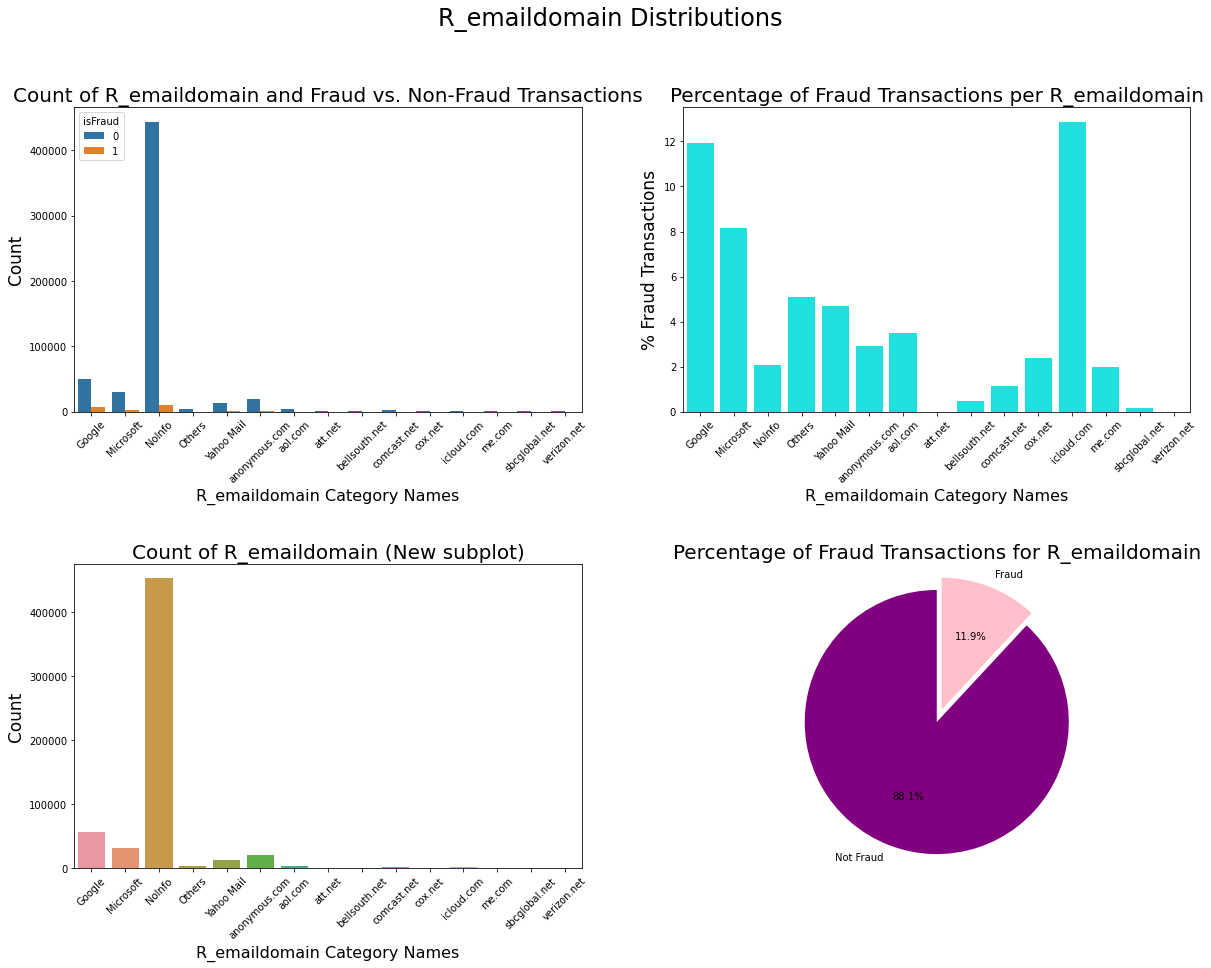

In [49]:
visualize_distributions(train, 'R_emaildomain')

### **DeviceType**

* Most of the fraudulent transactions were done by the mobile device.


In [50]:
train['DeviceType'].value_counts()

desktop    85165
mobile     55645
Name: DeviceType, dtype: int64

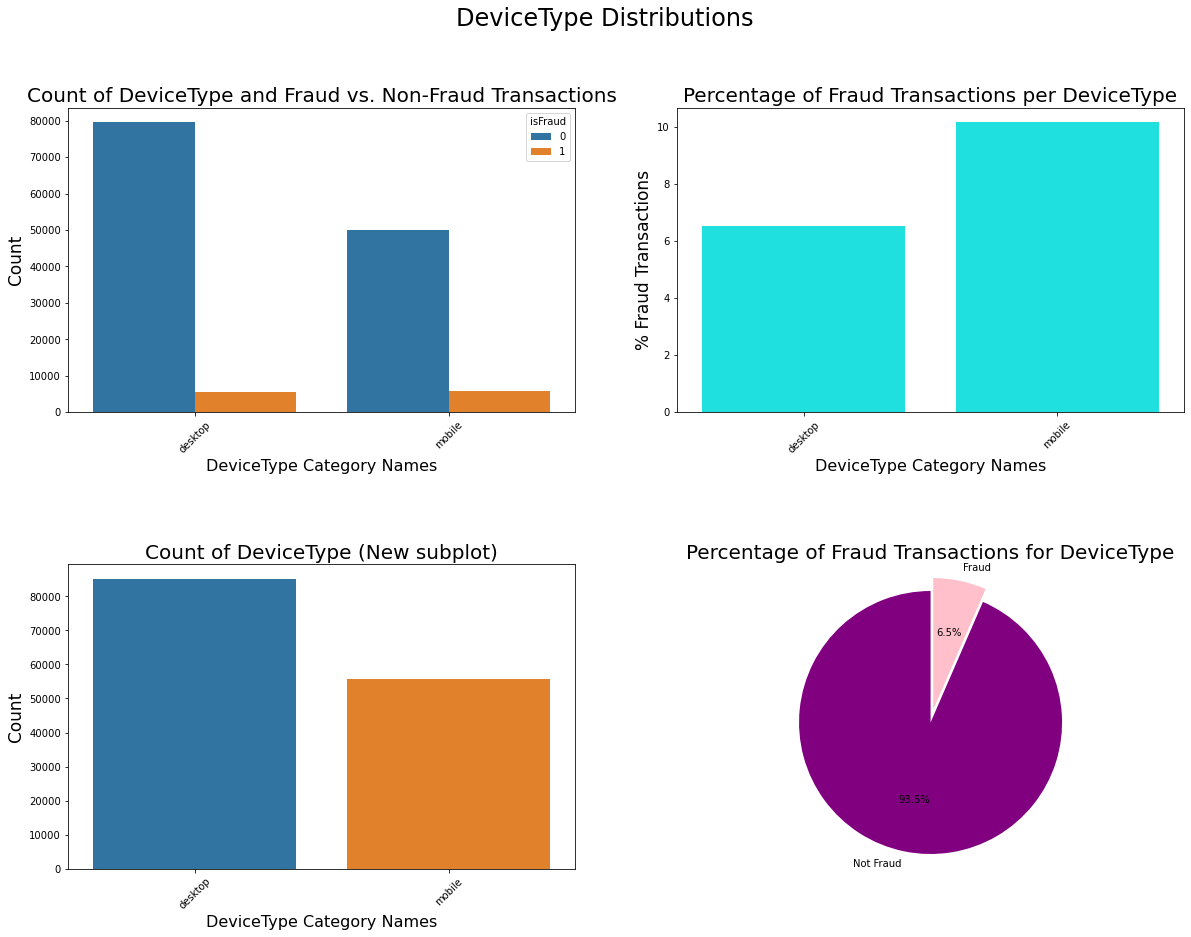

In [51]:
visualize_distributions(train, 'DeviceType')

### DeviceInfo
* Provides information about device names.

In [52]:
train['DeviceInfo'].value_counts()

Windows        47722
iOS Device     19782
MacOS          12573
Trident/7.0     7440
rv:11.0         1901
               ...  
LGMS345            1
verykool           1
XT1072             1
LG-H931            1
0PJA2              1
Name: DeviceInfo, Length: 1786, dtype: int64

In [53]:
train_test['DeviceInfo'] = train_test['DeviceInfo'].fillna('unknown_device').str.lower()
train_test['DeviceName'] = train_test['DeviceInfo'].str.split('/', expand=True)[0]

device_mapping = {
    'SM': 'Samsung',
    'SAMSUNG': 'Samsung',
    'GT-': 'Samsung',
    'Moto G': 'Motorola',
    'Moto': 'Motorola',
    'moto': 'Motorola',
    'LG-': 'LG',
    'rv:': 'RV',
    'HUAWEI': 'Huawei',
    'ALE-': 'Huawei',
    '-L': 'Huawei',
    'Blade': 'ZTE',
    'BLADE': 'ZTE',
    'Linux': 'Linux',
    'XT': 'Sony',
    'HTC': 'HTC',
    'ASUS': 'Asus'
}

train_test['DeviceName'] = train_test['DeviceName'].replace(device_mapping)
train_test.loc[train_test['DeviceName'].isin(train_test['DeviceName'].value_counts()[train_test['DeviceName'].value_counts() < 1000].index), 'DeviceName'] = 'Others'

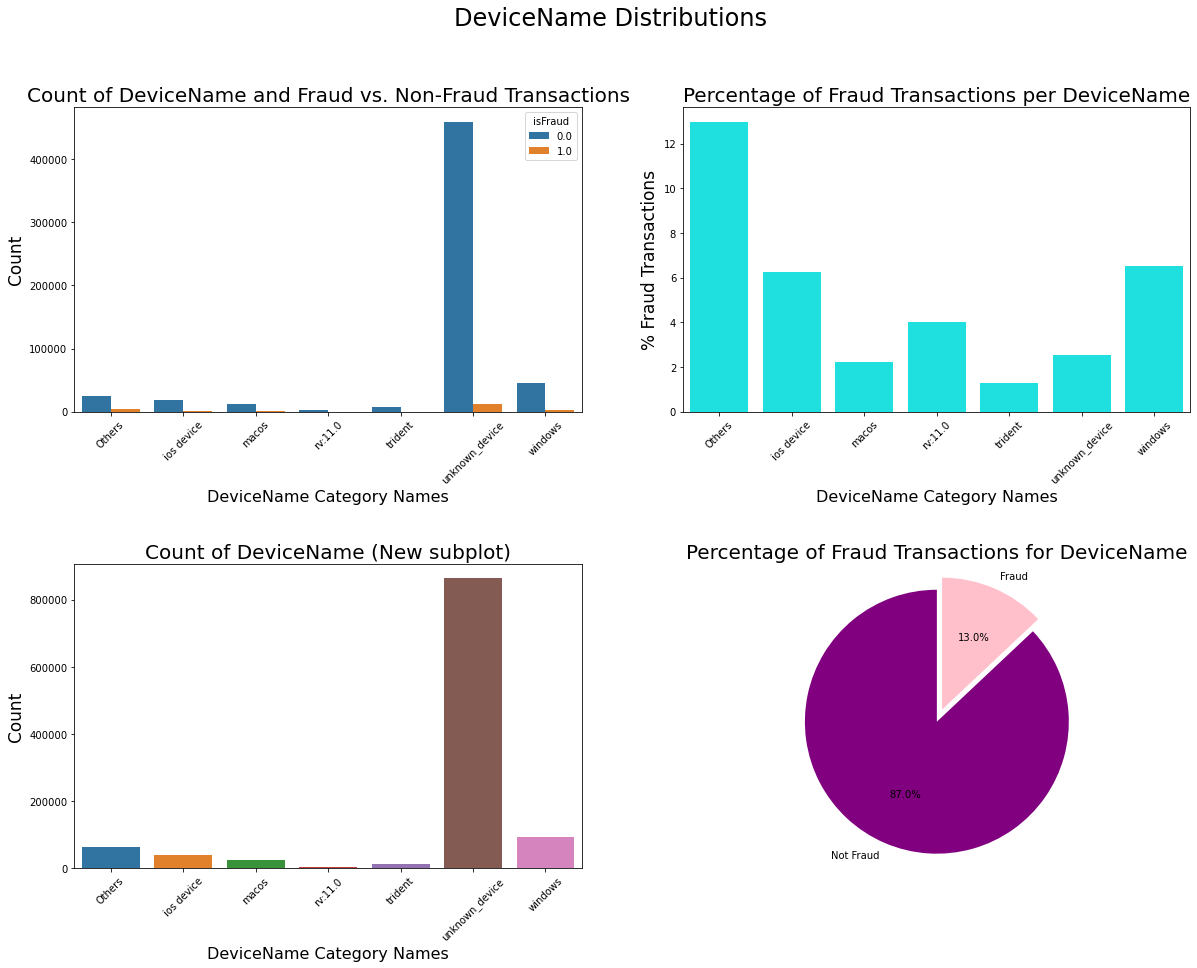

In [54]:
visualize_distributions(train_test, 'DeviceName')

## Exploring Group Features (card, C, D, M, V, id )

### card1-card6
* The host of the competition stated that some of the features are categorical even if they look numerical like card features.
* card1 - card6: payment card information, such as card type, card category, issue bank, country, etc.
* card4 and card6 have 4 unique values, and the others more than 100
* Except card1, card features have nan values ​​so I will group them according to card1 and fill with the most common value.

In [55]:
card_cols = [c for c in train.columns if c.startswith('card')]
card_cols

['card1', 'card2', 'card3', 'card4', 'card5', 'card6']

In [56]:
train[card_cols]

card1   card2   card3       card4   card5   card6
0       13926     NaN 150.000    discover 142.000  credit
1        2755 404.000 150.000  mastercard 102.000  credit
2        4663 490.000 150.000        visa 166.000   debit
3       18132 567.000 150.000  mastercard 117.000   debit
4        4497 514.000 150.000  mastercard 102.000  credit
...       ...     ...     ...         ...     ...     ...
590535   6550     NaN 150.000        visa 226.000   debit
590536  10444 225.000 150.000  mastercard 224.000   debit
590537  12037 595.000 150.000  mastercard 224.000   debit
590538   7826 481.000 150.000  mastercard 224.000   debit
590539  15066 170.000 150.000  mastercard 102.000  credit

[590540 rows x 6 columns]

In [57]:
train[card_cols].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 590540 entries, 0 to 590539
Data columns (total 6 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   card1   590540 non-null  int16  
 1   card2   581607 non-null  float32
 2   card3   588975 non-null  float32
 3   card4   588963 non-null  object 
 4   card5   586281 non-null  float32
 5   card6   588969 non-null  object 
dtypes: float32(3), int16(1), object(2)
memory usage: 37.5+ MB


In [58]:
train_test[card_cols].isnull().sum()

card1        0
card2    17587
card3     4567
card4     4663
card5     8806
card6     4578
dtype: int64

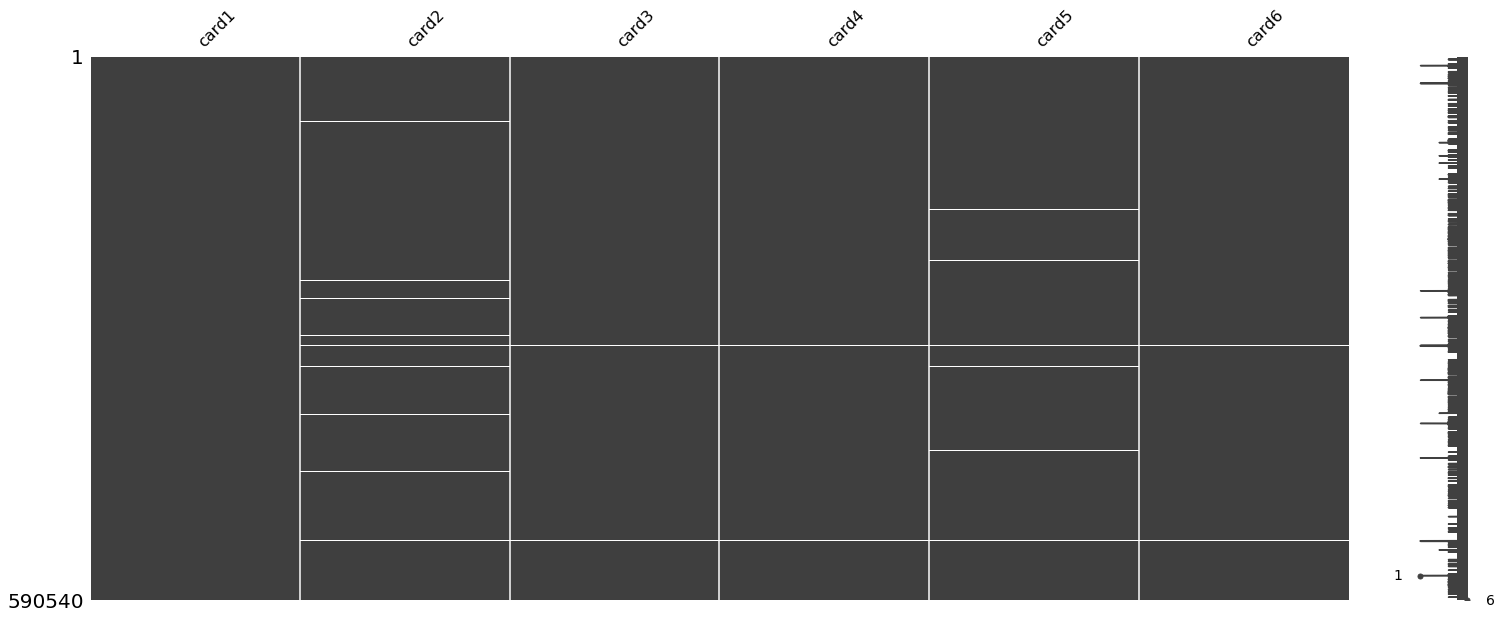

In [59]:
msno.matrix(train[card_cols]);

In [60]:
for i in range(len(card_cols)):
    print(card_cols[i]+" has "+ str(train[card_cols[i]].nunique()) + " unique value.")

card1 has 13553 unique value.
card2 has 500 unique value.
card3 has 114 unique value.
card4 has 4 unique value.
card5 has 119 unique value.
card6 has 4 unique value.


In [61]:
for col in card_cols:
    mode_vals = train_test.groupby(['card1'])[col].transform(lambda x: x.mode())
    if not mode_vals.empty:
        train_test[col] = train_test[col].fillna(mode_vals.iat[0])
    else:
        train_test[col].fillna(train_test[col].mode()[0], inplace=True)

In [62]:
train_test[card_cols].isnull().sum()

card1    0
card2    0
card3    0
card4    0
card5    0
card6    0
dtype: int64

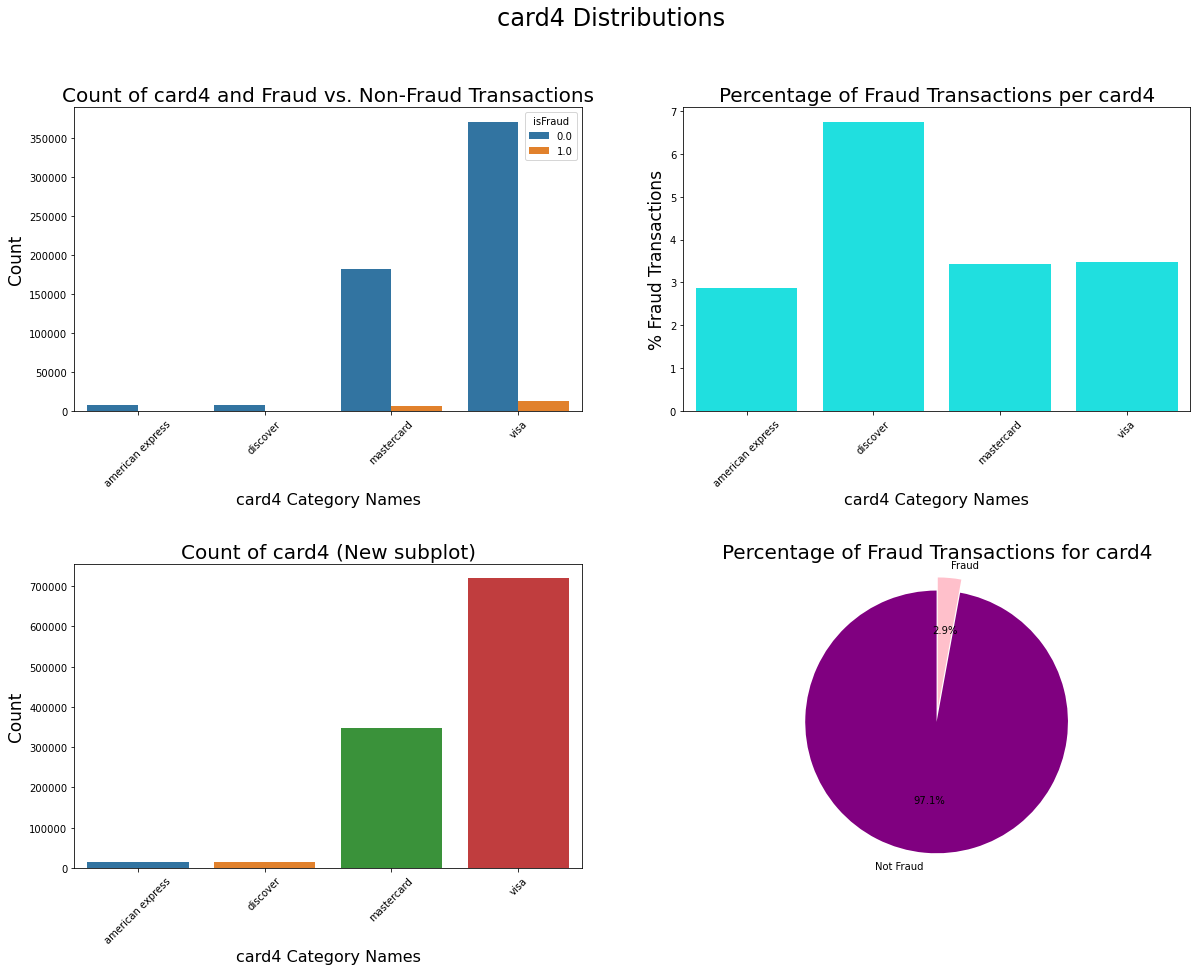

In [63]:
visualize_distributions(train_test, 'card4')

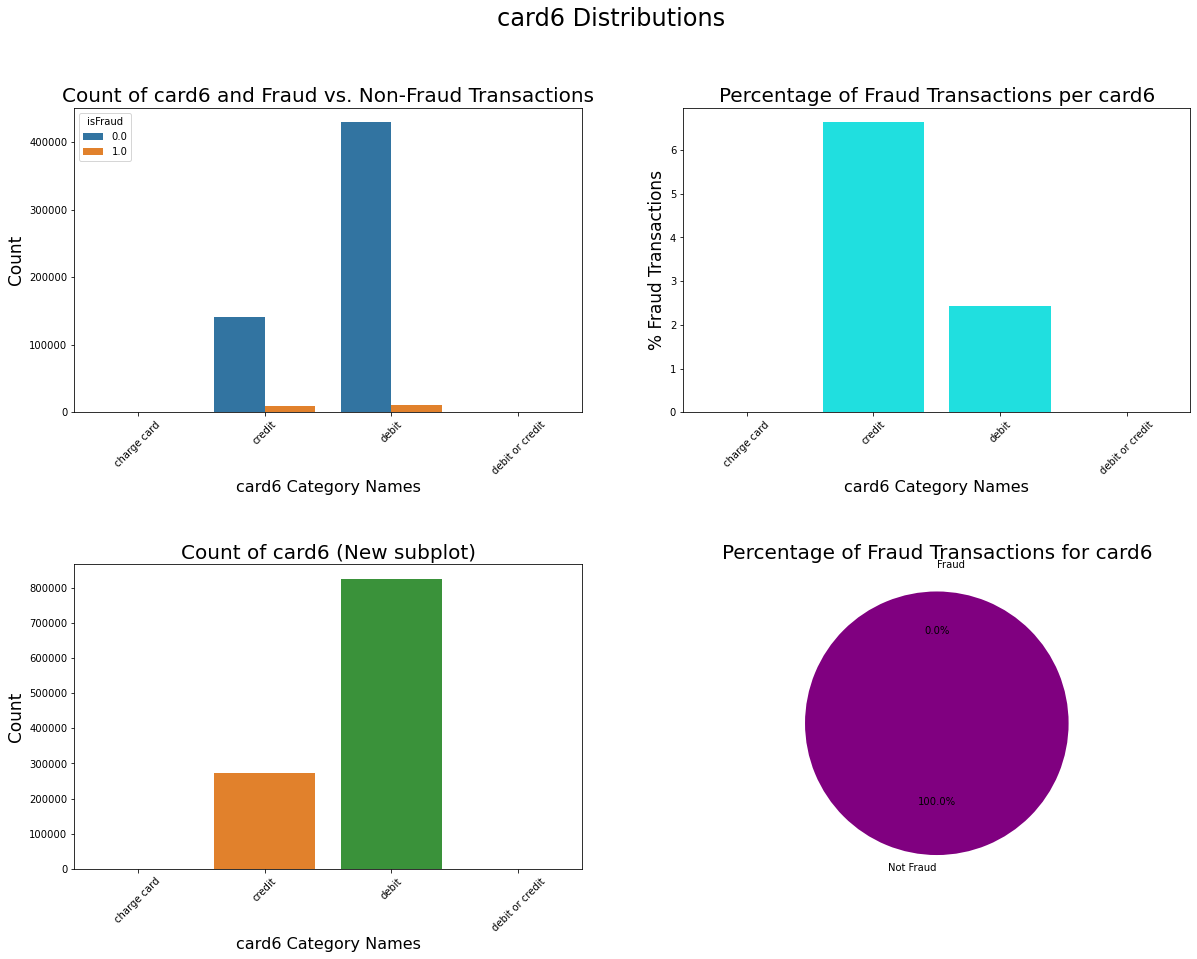

In [64]:
visualize_distributions(train_test, 'card6')

### C1-C14
* C1-C14: counting, such as how many addresses are found to be associated with the payment card, etc. The actual meaning is masked.
* All of the C features are continuous.

In [65]:
c_cols = [c for c in train.columns if c.startswith('C')]
c_cols

['C1',
 'C2',
 'C3',
 'C4',
 'C5',
 'C6',
 'C7',
 'C8',
 'C9',
 'C10',
 'C11',
 'C12',
 'C13',
 'C14']

In [66]:
train[c_cols]

C1    C2    C3    C4    C5    C6    C7    C8    C9   C10   C11  \
0      1.000 1.000 0.000 0.000 0.000 1.000 0.000 0.000 1.000 0.000 2.000   
1      1.000 1.000 0.000 0.000 0.000 1.000 0.000 0.000 0.000 0.000 1.000   
2      1.000 1.000 0.000 0.000 0.000 1.000 0.000 0.000 1.000 0.000 1.000   
3      2.000 5.000 0.000 0.000 0.000 4.000 0.000 0.000 1.000 0.000 1.000   
4      1.000 1.000 0.000 0.000 0.000 1.000 0.000 1.000 0.000 1.000 1.000   
...      ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   
590535 2.000 1.000 0.000 0.000 1.000 0.000 0.000 0.000 2.000 0.000 1.000   
590536 1.000 1.000 0.000 0.000 0.000 1.000 0.000 0.000 1.000 0.000 1.000   
590537 1.000 1.000 0.000 0.000 1.000 1.000 0.000 0.000 1.000 0.000 1.000   
590538 1.000 1.000 0.000 0.000 0.000 3.000 0.000 0.000 2.000 0.000 1.000   
590539 2.000 1.000 0.000 0.000 1.000 1.000 0.000 0.000 2.000 0.000 1.000   

         C12    C13   C14  
0      0.000  1.000 1.000  
1      0.000  1.000 1.000  
2      0.000  1.000 1.000  
3      0.000 25.000 1.000  
4      0.000  1.000 1.000  
...      ...    ...   ...  
590535 0.000  3.000 2.000  
590536 0.000  1.000 1.000  
590537 0.000  1.000 1.000  
590538 1.000  5.000 1.000  
590539 0.000  1.000 1.000  

[590540 rows x 14 columns]

In [67]:
train[c_cols].describe()

C1         C2         C3         C4         C5         C6  \
count 590540.000 590540.000 590540.000 590540.000 590540.000 590540.000   
mean      14.092     15.270      0.006      4.092      5.572      9.071   
std      133.093    154.179      0.150     68.751     25.801     71.158   
min        0.000      0.000      0.000      0.000      0.000      0.000   
25%        1.000      1.000      0.000      0.000      0.000      1.000   
50%        1.000      1.000      0.000      0.000      0.000      1.000   
75%        3.000      3.000      0.000      0.000      1.000      2.000   
max     4684.000   5692.000     26.000   2252.000    349.000   2252.000   

              C7         C8         C9        C10        C11        C12  \
count 590540.000 590540.000 590540.000 590540.000 590540.000 590540.000   
mean       2.848      5.145      4.480      5.240     10.242      4.076   
std       61.671     95.263     16.705     95.461     93.986     86.587   
min        0.000      0.000      0.000      0.000      0.000      0.000   
25%        0.000      0.000      0.000      0.000      1.000      0.000   
50%        0.000      0.000      1.000      0.000      1.000      0.000   
75%        0.000      0.000      2.000      0.000      2.000      0.000   
max     2256.000   3332.000    210.000   3256.000   3188.000   3188.000   

             C13        C14  
count 590540.000 590540.000  
mean      32.519      8.295  
std      129.430     49.268  
min        0.000      0.000  
25%        1.000      1.000  
50%        3.000      1.000  
75%       12.000      2.000  
max     2918.000   1429.000

In [68]:
train_test[c_cols].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1097231 entries, 0 to 1097230
Data columns (total 14 columns):
 #   Column  Non-Null Count    Dtype  
---  ------  --------------    -----  
 0   C1      1097228 non-null  float32
 1   C2      1097228 non-null  float32
 2   C3      1097228 non-null  float32
 3   C4      1097228 non-null  float32
 4   C5      1097228 non-null  float32
 5   C6      1097228 non-null  float32
 6   C7      1097228 non-null  float32
 7   C8      1097228 non-null  float32
 8   C9      1097228 non-null  float32
 9   C10     1097228 non-null  float32
 10  C11     1097228 non-null  float32
 11  C12     1097228 non-null  float32
 12  C13     1092483 non-null  float32
 13  C14     1097228 non-null  float32
dtypes: float32(14)
memory usage: 58.6 MB


### D1-D15
* The D Columns are "time deltas" from some point in the past.


In [69]:
d_cols = ['D1','D2','D3','D4','D5','D6','D7','D8','D9','D10','D11','D12','D13','D14']
train[d_cols].head()

D1      D2     D3     D4    D5  D6  D7  D8  D9    D10     D11  D12  \
0  14.000     NaN 13.000    NaN   NaN NaN NaN NaN NaN 13.000  13.000  NaN   
1   0.000     NaN    NaN  0.000   NaN NaN NaN NaN NaN  0.000     NaN  NaN   
2   0.000     NaN    NaN  0.000   NaN NaN NaN NaN NaN  0.000 315.000  NaN   
3 112.000 112.000  0.000 94.000 0.000 NaN NaN NaN NaN 84.000     NaN  NaN   
4   0.000     NaN    NaN    NaN   NaN NaN NaN NaN NaN    NaN     NaN  NaN   

   D13  D14  
0  NaN  NaN  
1  NaN  NaN  
2  NaN  NaN  
3  NaN  NaN  
4  NaN  NaN

In [70]:
train[d_cols].describe()

D1         D2         D3         D4         D5        D6  \
count 589271.000 309743.000 327662.000 421618.000 280699.000 73187.000   
mean      94.341    169.553     28.343    139.996     42.336    69.806   
std      157.754    177.297     62.394    191.033     88.994   143.659   
min        0.000      0.000      0.000   -122.000      0.000   -83.000   
25%        0.000     26.000      1.000      0.000      1.000     0.000   
50%        3.000     97.000      8.000     26.000     10.000     0.000   
75%      122.000    276.000     27.000    253.000     32.000    40.000   
max      640.000    640.000    819.000    869.000    819.000   873.000   

             D7        D8        D9        D10        D11       D12       D13  \
count 38917.000 74926.000 74926.000 514518.000 311253.000 64717.000 61952.000   
mean     41.639   146.088     0.561    123.977    146.618    54.038    17.901   
std      99.732   231.661     0.317    182.612    186.039   124.296    67.612   
min       0.000     0.000     0.000      0.000    -53.000   -83.000     0.000   
25%       0.000     0.958     0.208      0.000      0.000     0.000     0.000   
50%       0.000    37.875     0.667     15.000     43.000     0.000     0.000   
75%      17.000   188.000     0.833    197.000    274.000    13.000     0.000   
max     843.000  1708.000     0.958    876.000    670.000   648.000   847.000   

            D14  
count 62187.000  
mean     57.724  
std     136.304  
min    -193.000  
25%       0.000  
50%       0.000  
75%       2.000  
max     878.000

In [71]:
train[d_cols].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 590540 entries, 0 to 590539
Data columns (total 14 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   D1      589271 non-null  float32
 1   D2      309743 non-null  float32
 2   D3      327662 non-null  float32
 3   D4      421618 non-null  float32
 4   D5      280699 non-null  float32
 5   D6      73187 non-null   float32
 6   D7      38917 non-null   float32
 7   D8      74926 non-null   float32
 8   D9      74926 non-null   float32
 9   D10     514518 non-null  float32
 10  D11     311253 non-null  float32
 11  D12     64717 non-null   float32
 12  D13     61952 non-null   float32
 13  D14     62187 non-null   float32
dtypes: float32(14)
memory usage: 52.2 MB


In [72]:
train[d_cols].isnull().sum()

D1       1269
D2     280797
D3     262878
D4     168922
D5     309841
D6     517353
D7     551623
D8     515614
D9     515614
D10     76022
D11    279287
D12    525823
D13    528588
D14    528353
dtype: int64

In [73]:
import random
cute_palette = ['#FFD700', '#FF69B4', '#FFA500', '#FFC0CB', '#90EE90', '#00BFFF', '#FF7F50', '#BA55D3', '#00CED1', '#FF4500', '#87CEFA', '#FF8C00', '#9370DB', '#7FFFD4']
random_color = random.choice(cute_palette)

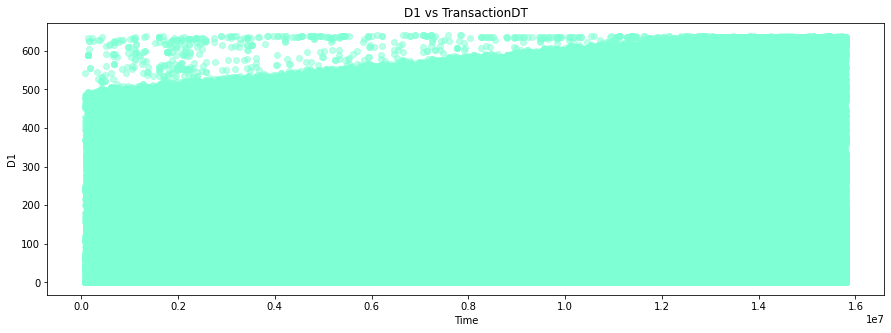

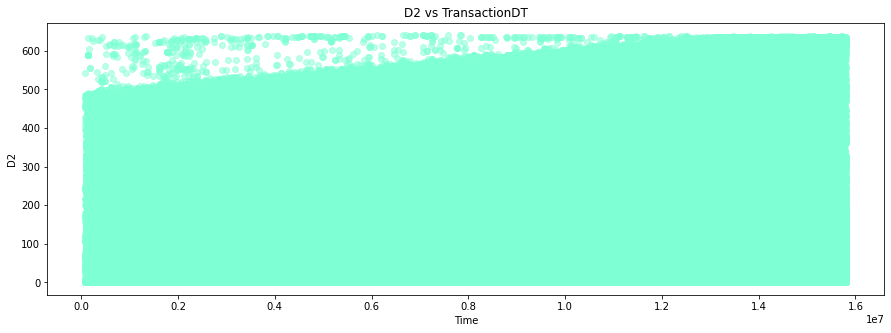

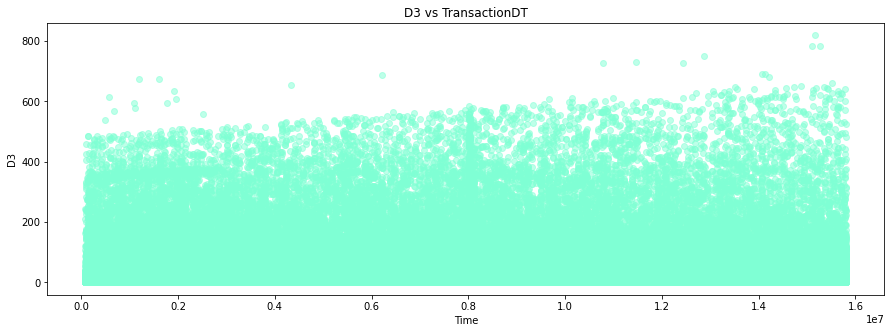

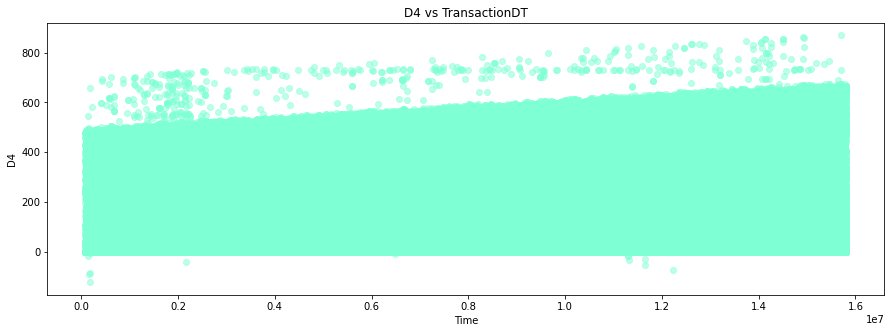

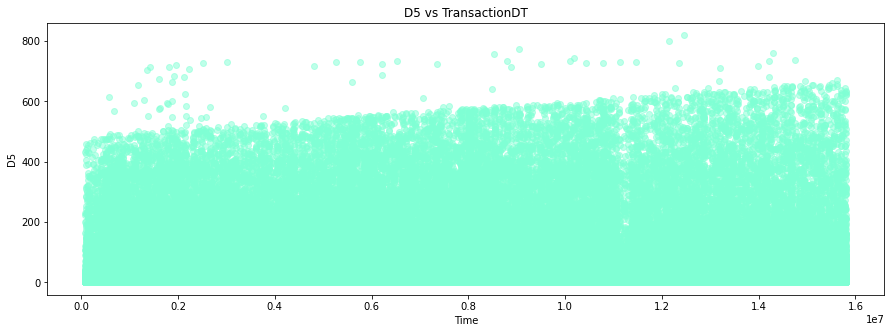

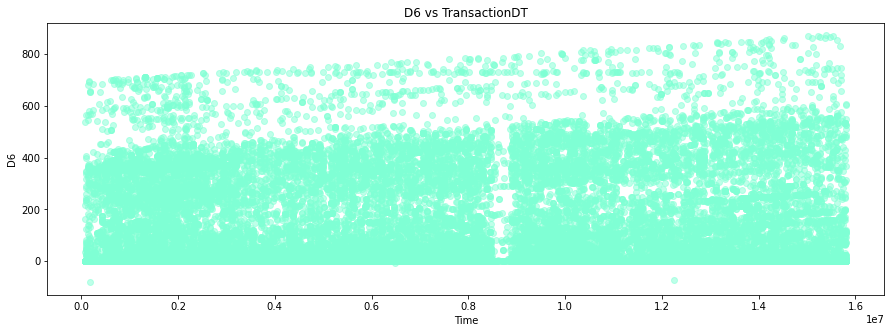

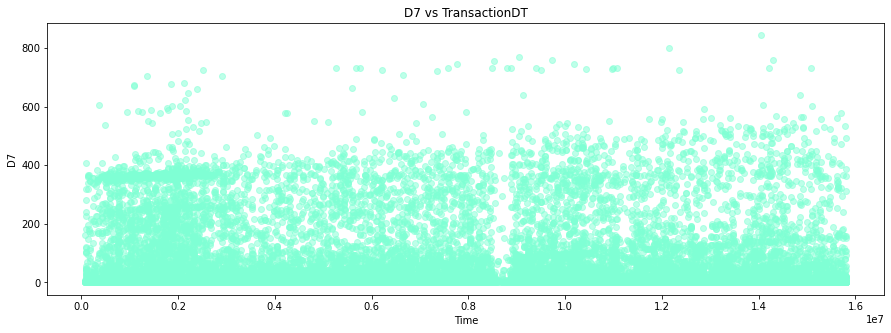

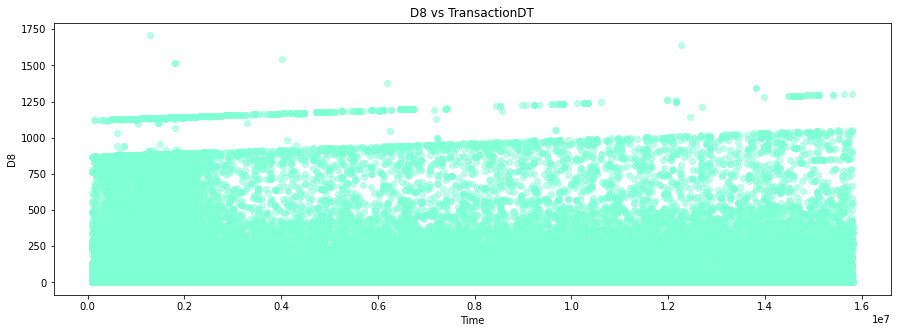

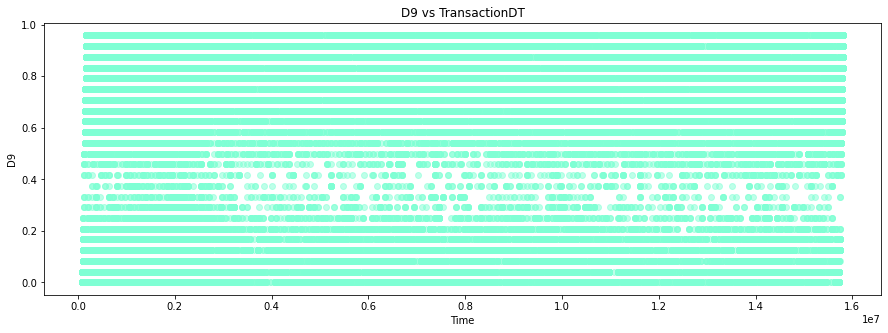

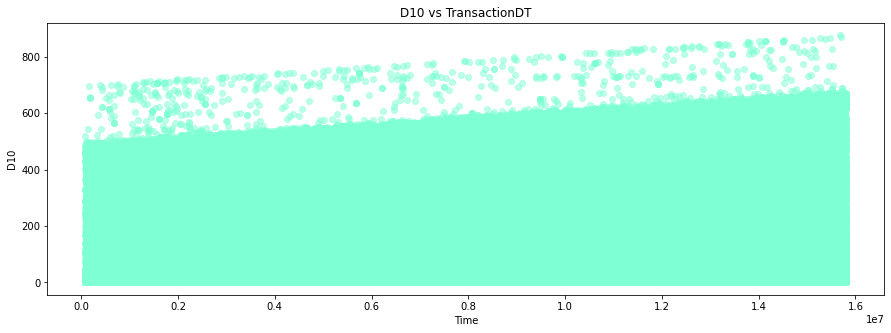

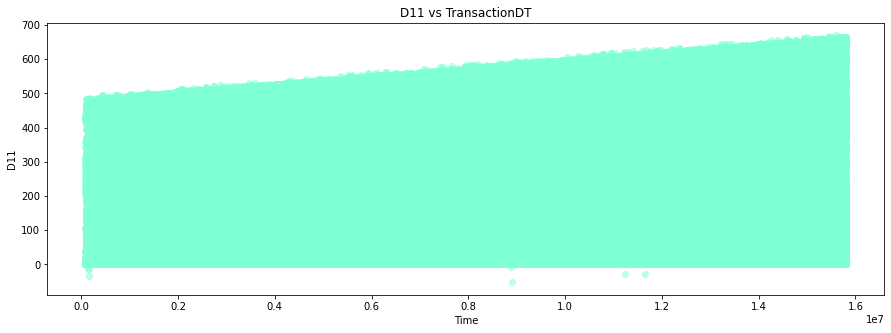

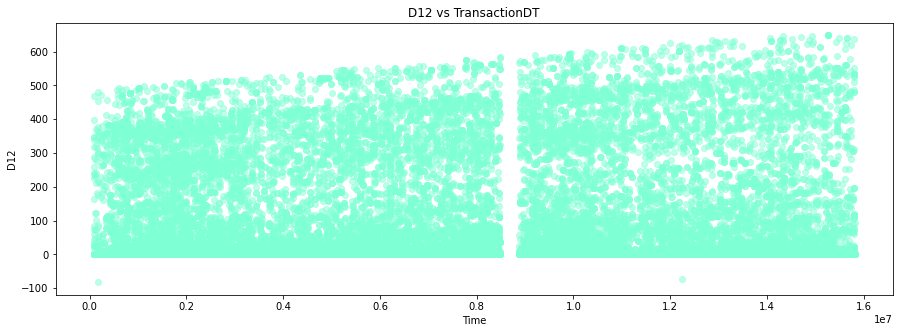

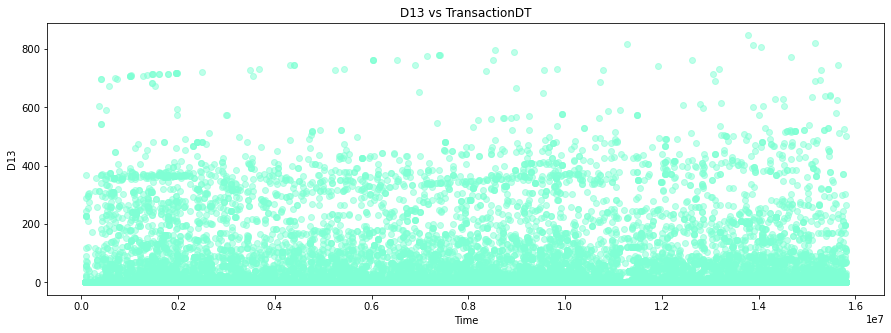

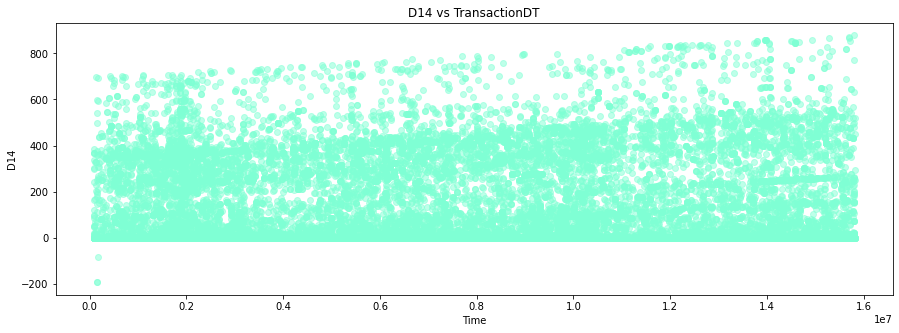

In [74]:
for col in d_cols:
    plt.figure(figsize=(15, 5))
    plt.scatter(train['TransactionDT'], train[col], color=random_color, alpha=0.5)
    plt.title(f'{col} vs TransactionDT')
    plt.xlabel('Time')
    plt.ylabel(col)
    plt.show()

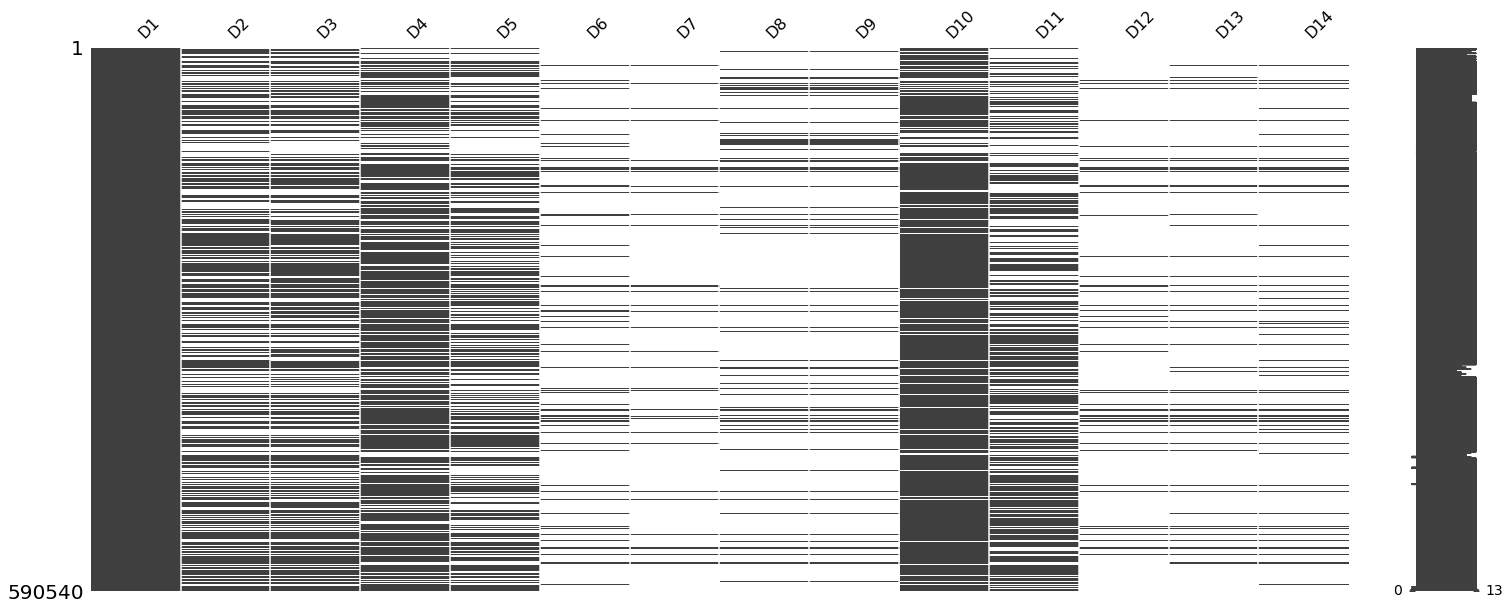

In [75]:
msno.matrix(train[d_cols]);

### M1-M9
* M1-M9 : match, such as names on card and address, etc.
* All of the M features are categorical.
* Values are T F or NaN except M4.
* M4 feature appears to be different from others.

In [76]:
m_cols = [c for c in train.columns if c.startswith('M')]

In [77]:
train[m_cols].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 590540 entries, 0 to 590539
Data columns (total 9 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   M1      319440 non-null  object
 1   M2      319440 non-null  object
 2   M3      319440 non-null  object
 3   M4      309096 non-null  object
 4   M5      240058 non-null  object
 5   M6      421180 non-null  object
 6   M7      244275 non-null  object
 7   M8      244288 non-null  object
 8   M9      244288 non-null  object
dtypes: object(9)
memory usage: 61.2+ MB


In [78]:
train[m_cols].isnull().sum()

M1    271100
M2    271100
M3    271100
M4    281444
M5    350482
M6    169360
M7    346265
M8    346252
M9    346252
dtype: int64

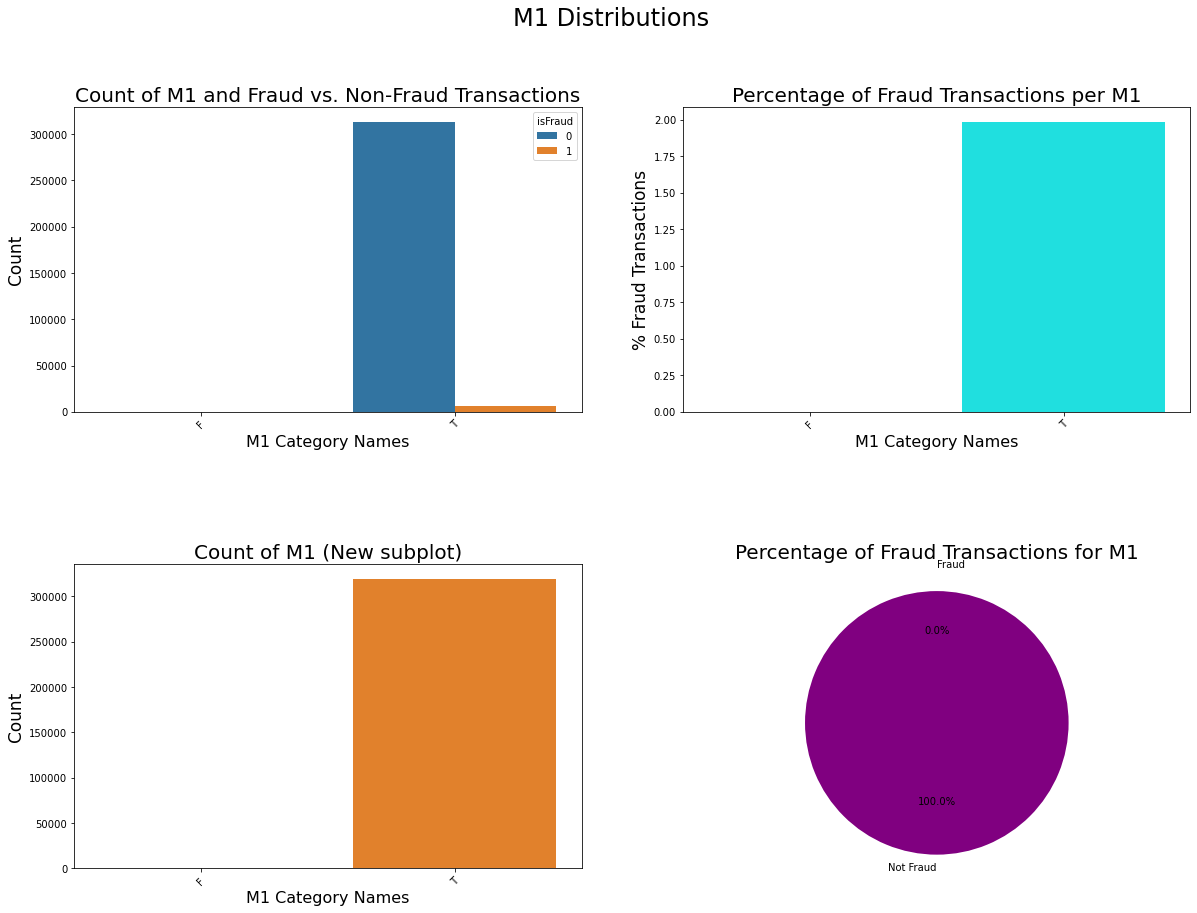

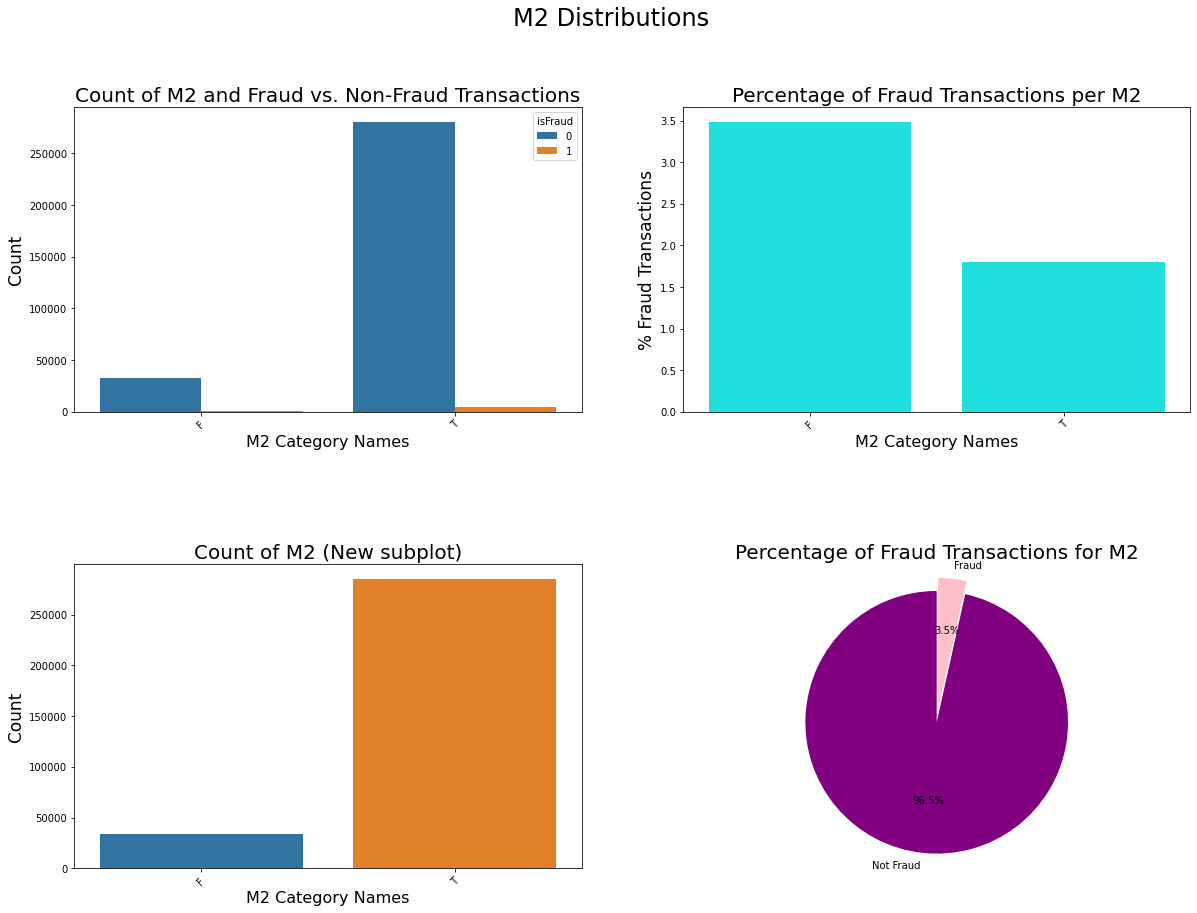

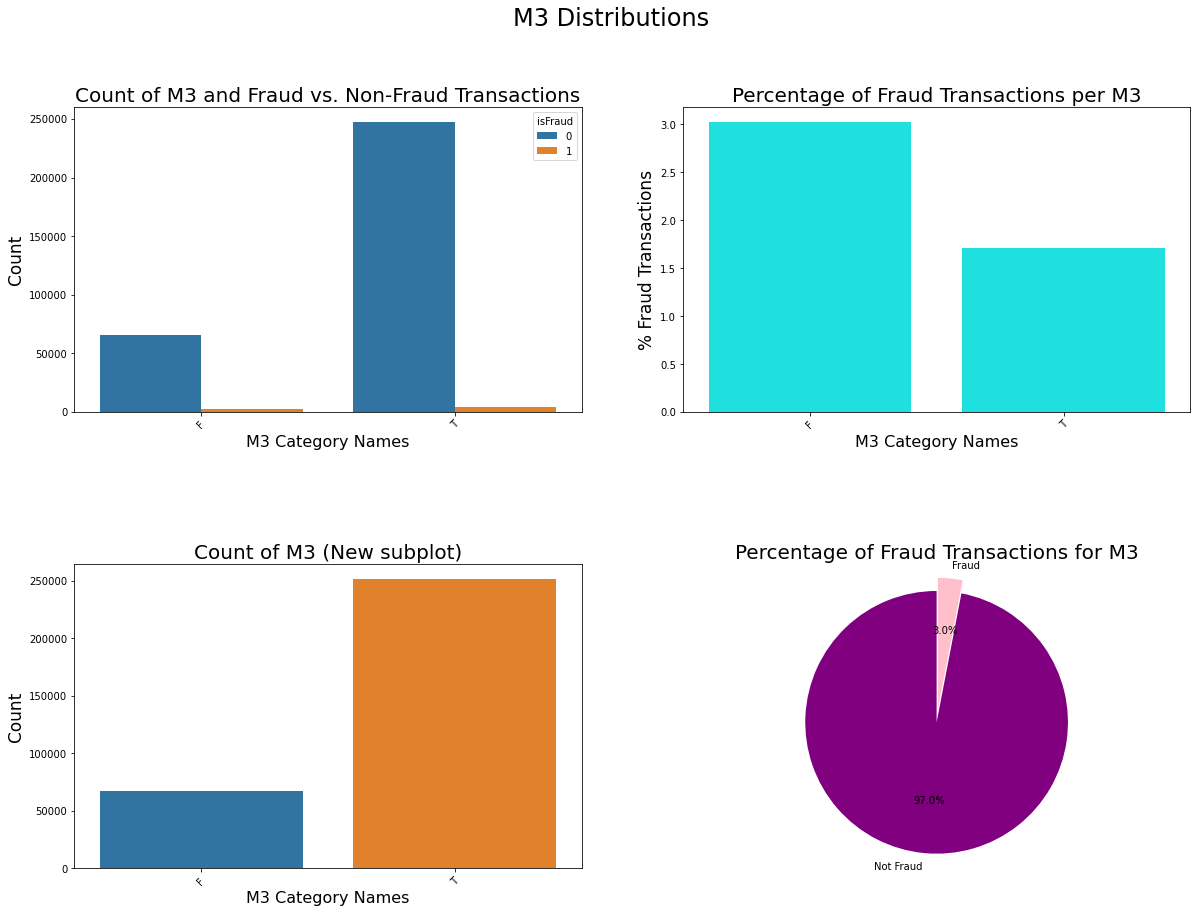

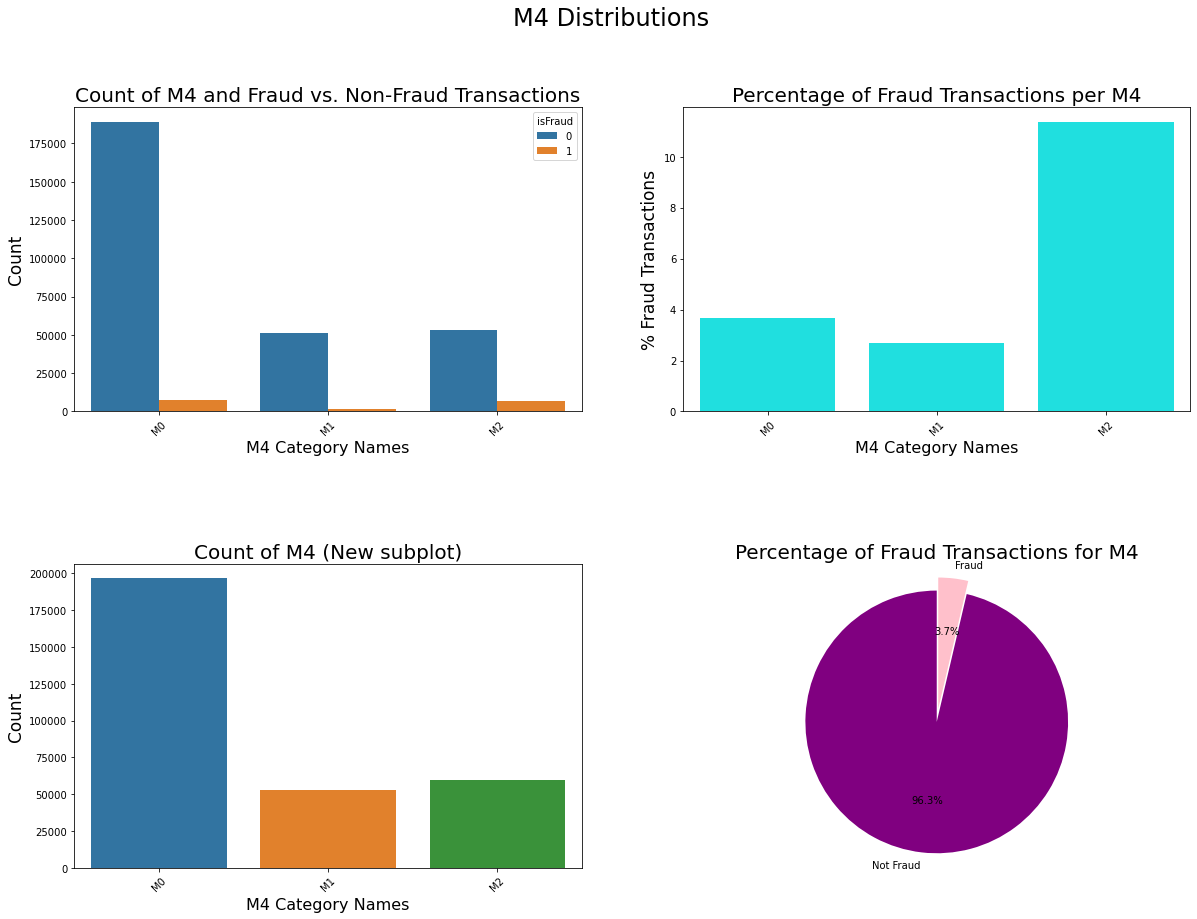

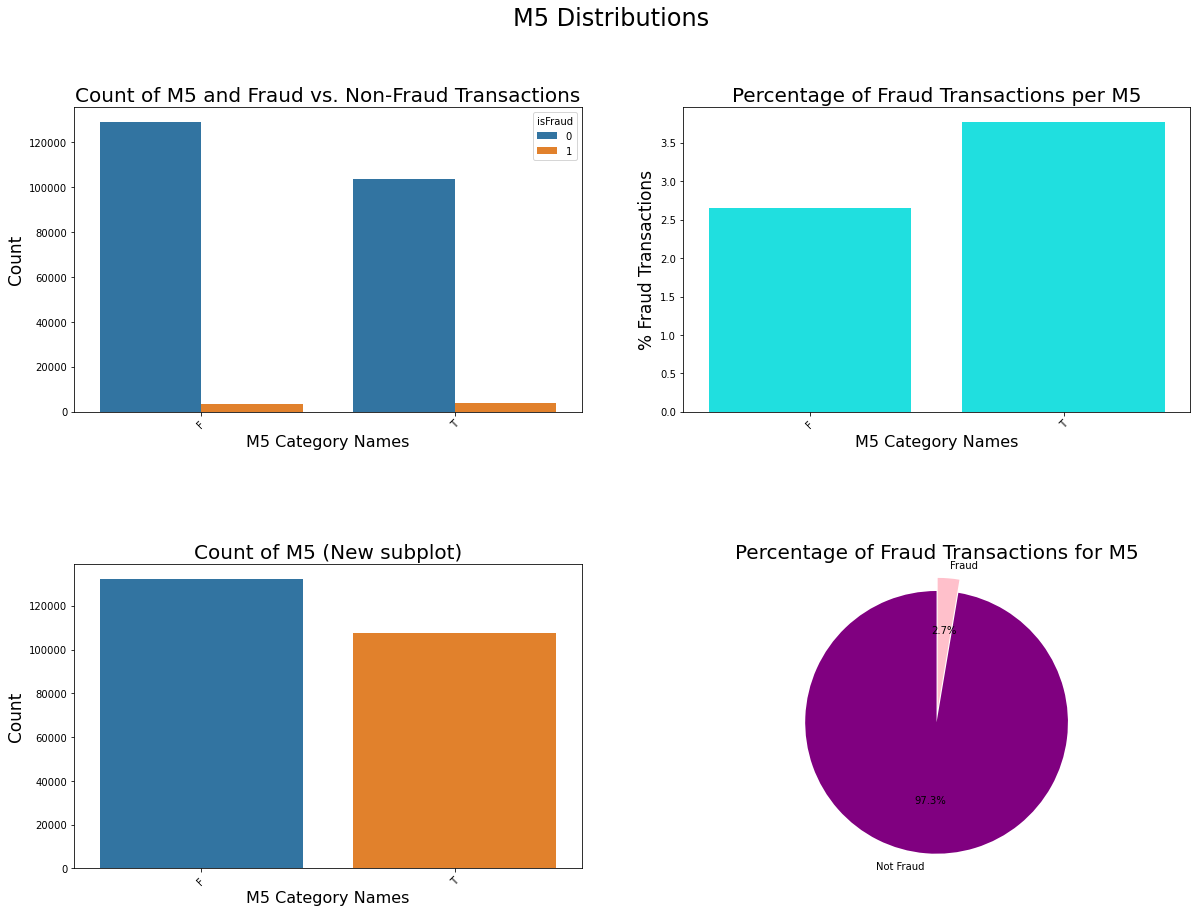

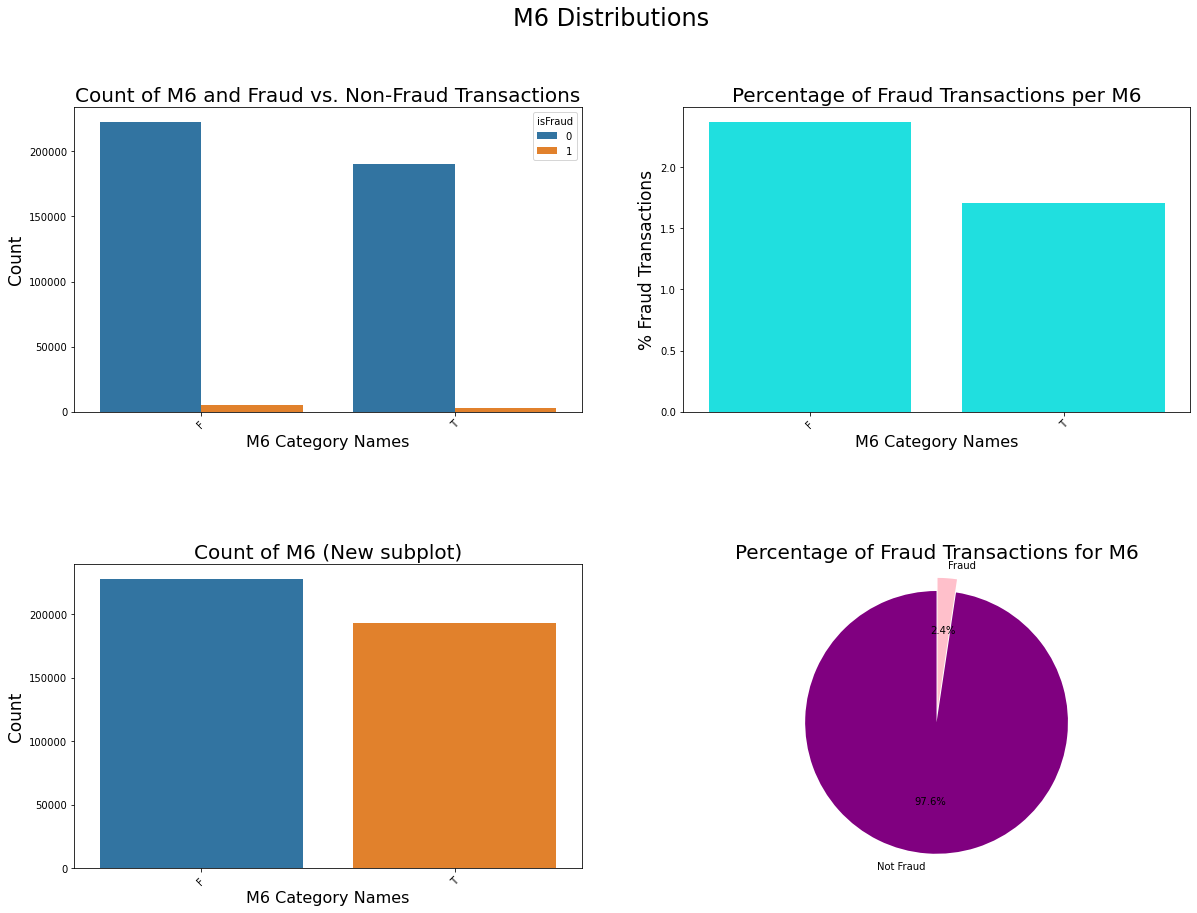

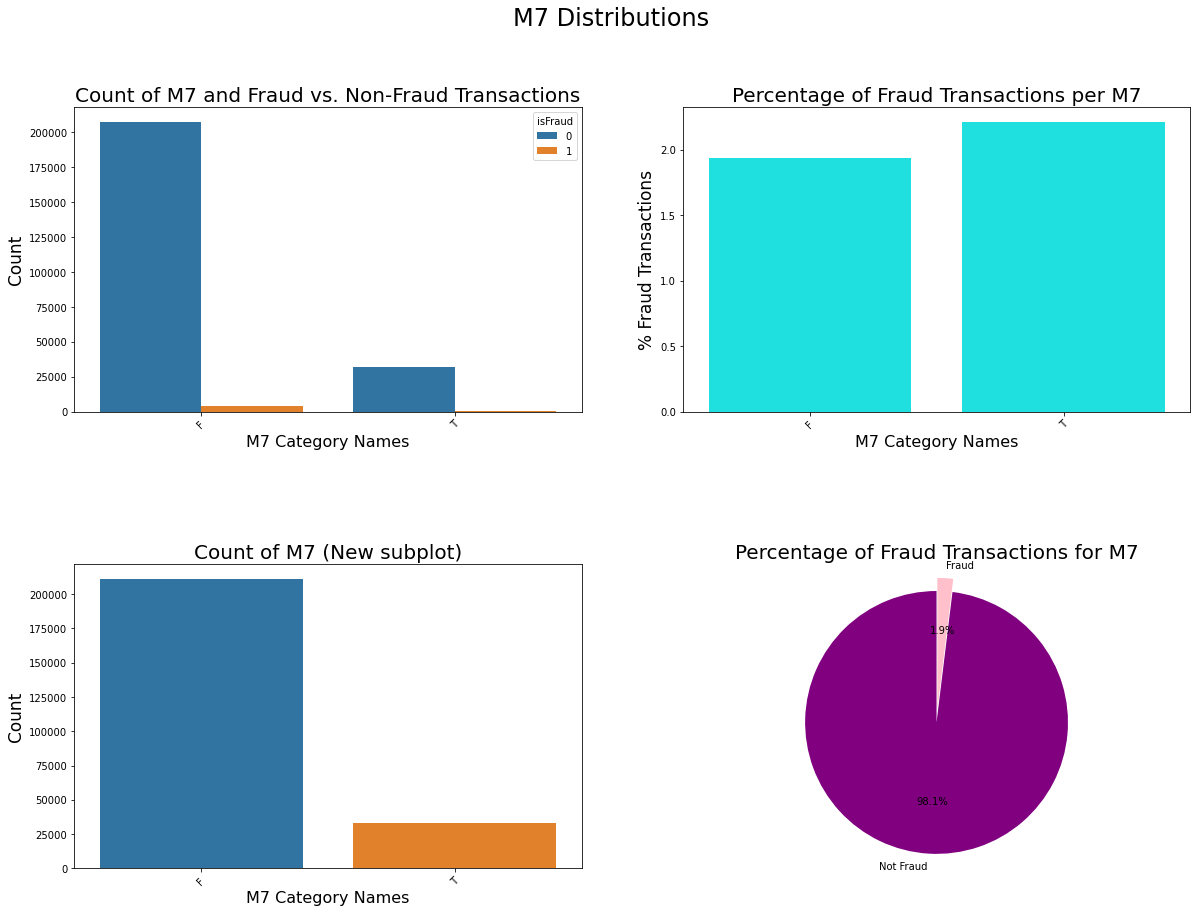

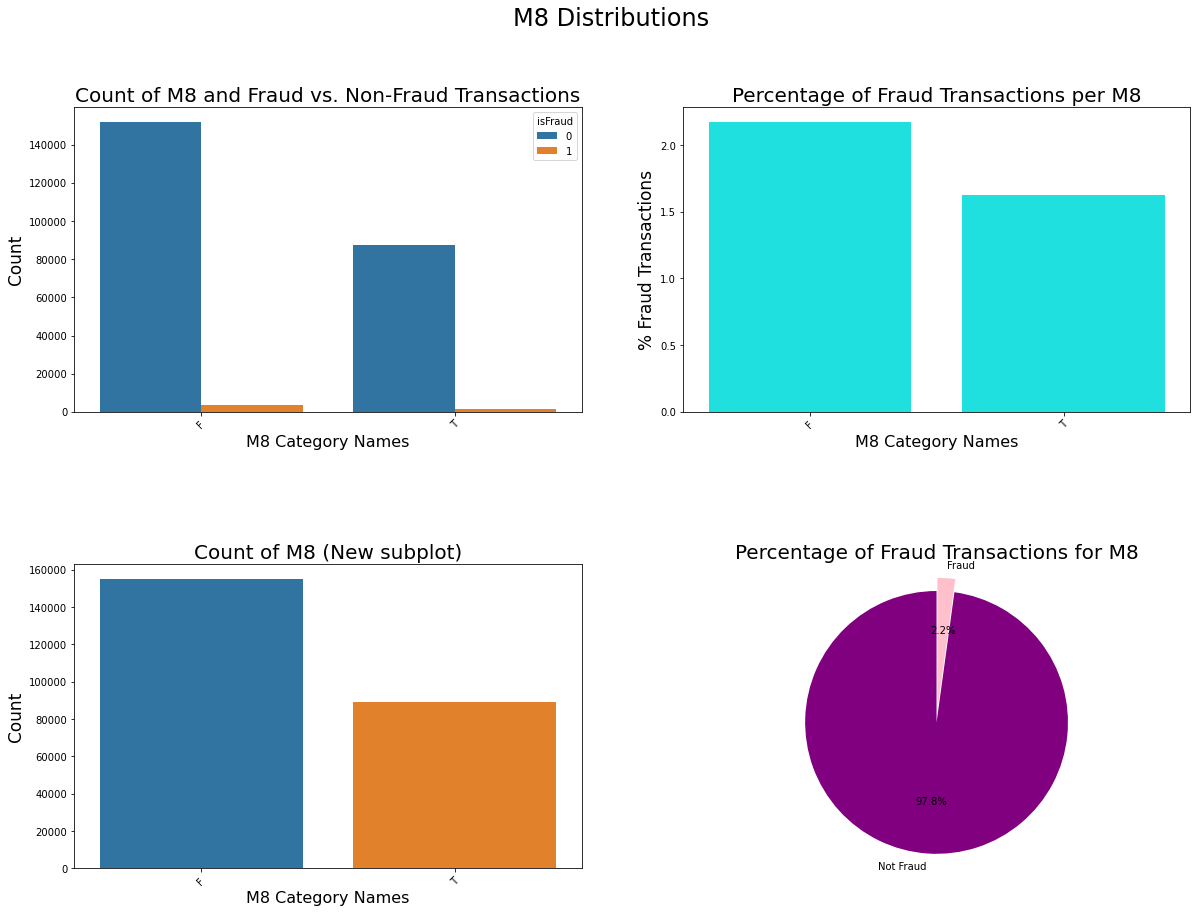

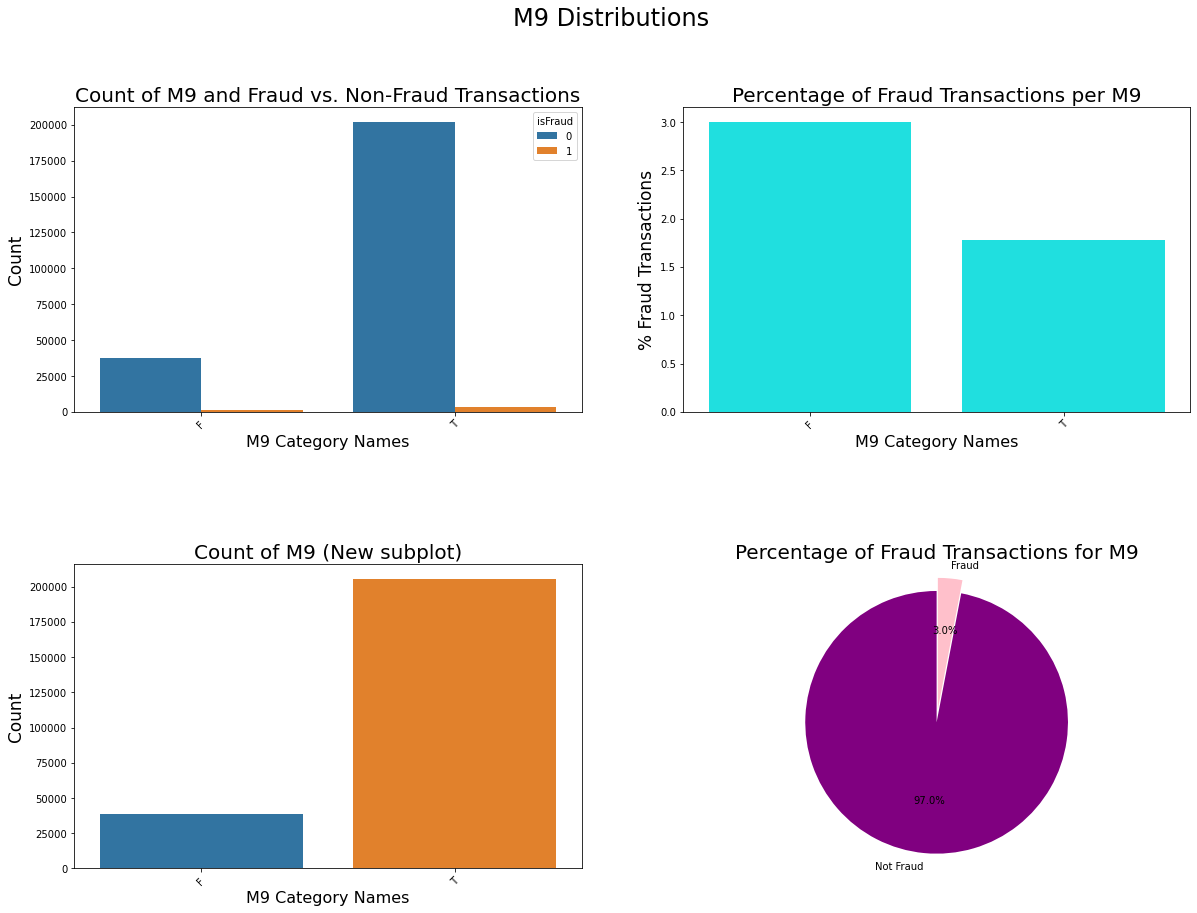

In [80]:
for col in m_cols:
    visualize_distributions(train, col)

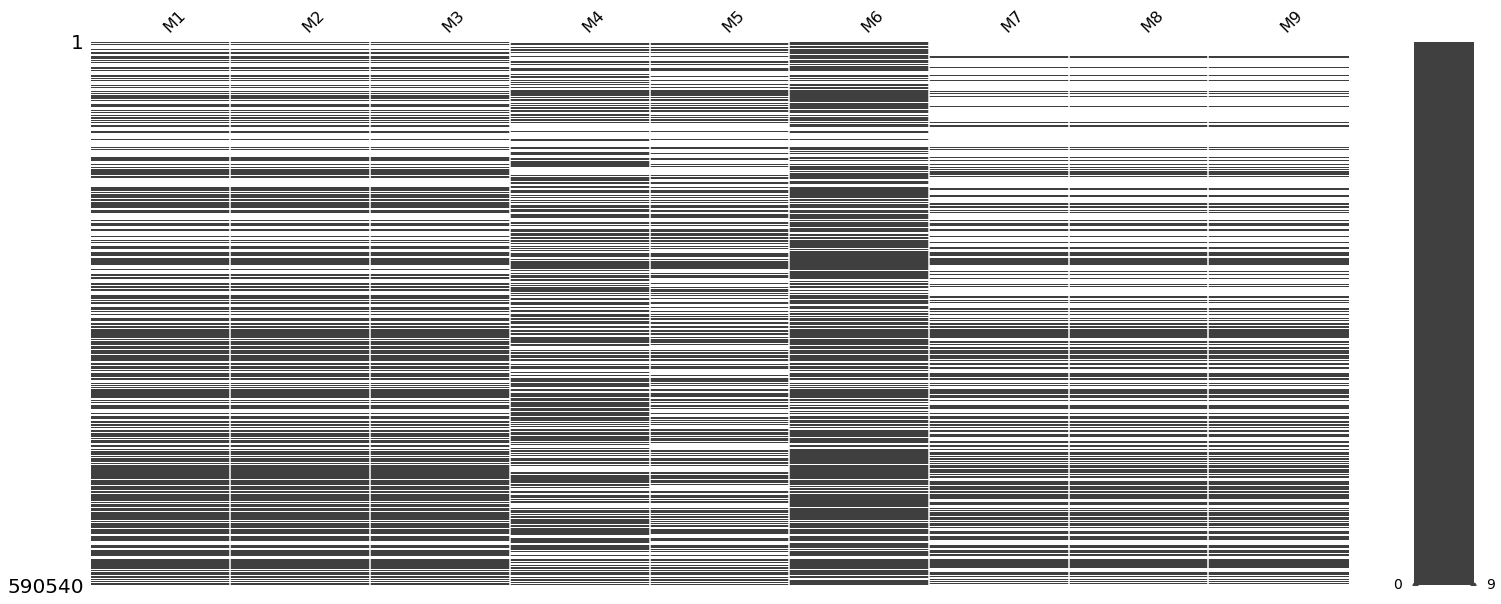

In [81]:
msno.matrix(train[m_cols]);

### V1-V339
* Vxxx: Vesta engineered rich features, including ranking, counting, and other entity relations.
* I will group the v features that have a similar number of nan observations.

In [82]:
v_cols = [v for v in train.columns if v.startswith('V')]
train[v_cols].head()

V1    V2    V3    V4    V5    V6    V7    V8    V9   V10   V11   V12  \
0 1.000 1.000 1.000 1.000 1.000 1.000 1.000 1.000 1.000 0.000 0.000 1.000   
1   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN 0.000   
2 1.000 1.000 1.000 1.000 1.000 1.000 1.000 1.000 1.000 0.000 0.000 1.000   
3   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN 1.000   
4   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   

    V13   V14   V15   V16   V17   V18   V19   V20   V21   V22   V23   V24  \
0 1.000 1.000 0.000 0.000 0.000 0.000 1.000 1.000 0.000 0.000 1.000 1.000   
1 0.000 1.000 0.000 0.000 0.000 0.000 1.000 1.000 0.000 0.000 1.000 1.000   
2 1.000 1.000 0.000 0.000 0.000 0.000 1.000 1.000 0.000 0.000 1.000 1.000   
3 1.000 1.000 0.000 0.000 0.000 0.000 1.000 1.000 0.000 0.000 1.000 1.000   
4   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   

    V25   V26   V27   V28   V29   V30   V31   V32   V33   V34   V35   V36  \
0 1.000 1.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000   NaN   NaN   
1 1.000 1.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000   
2 1.000 1.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 1.000 1.000   
3 1.000 1.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 1.000 1.000   
4   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   

    V37   V38   V39   V40   V41   V42   V43   V44   V45   V46   V47   V48  \
0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
1 1.000 1.000 0.000 0.000 1.000 0.000 0.000 1.000 1.000 1.000 1.000 0.000   
2 1.000 1.000 0.000 0.000 1.000 0.000 0.000 1.000 1.000 1.000 1.000 0.000   
3 1.000 1.000 0.000 0.000 1.000 0.000 0.000 1.000 1.000 1.000 1.000 0.000   
4   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   

    V49   V50   V51   V52   V53   V54   V55   V56   V57   V58   V59   V60  \
0   NaN   NaN   NaN   NaN 1.000 1.000 1.000 1.000 0.000 0.000 0.000 0.000   
1 0.000 0.000 0.000 0.000 0.000 0.000 1.000 1.000 0.000 0.000 0.000 0.000   
2 0.000 0.000 0.000 0.000 1.000 1.000 1.000 1.000 0.000 0.000 0.000 0.000   
3 0.000 0.000 0.000 0.000 1.000 1.000 1.000 1.000 0.000 0.000 0.000 0.000   
4   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   

    V61   V62   V63   V64   V65   V66   V67   V68   V69   V70   V71   V72  \
0 1.000 1.000 0.000 0.000 1.000 1.000 1.000 0.000 0.000 0.000 0.000 0.000   
1 1.000 1.000 0.000 0.000 1.000 1.000 1.000 0.000 0.000 0.000 0.000 0.000   
2 1.000 1.000 0.000 0.000 1.000 1.000 1.000 0.000 0.000 0.000 0.000 0.000   
3 1.000 1.000 0.000 0.000 1.000 1.000 1.000 0.000 0.000 0.000 0.000 0.000   
4   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   

    V73   V74   V75   V76   V77   V78   V79   V80   V81   V82   V83   V84  \
0 0.000 0.000 1.000 1.000 1.000 1.000 0.000 0.000 0.000 0.000 0.000 0.000   
1 0.000 0.000 0.000 0.000 1.000 1.000 0.000 0.000 0.000 1.000 1.000 0.000   
2 0.000 0.000 1.000 1.000 1.000 1.000 0.000 0.000 0.000 1.000 1.000 0.000   
3 0.000 0.000 1.000 1.000 1.000 1.000 0.000 0.000 0.000 1.000 1.000 0.000   
4   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   

    V85   V86   V87   V88   V89   V90   V91   V92   V93   V94   V95    V96  \
0 0.000 1.000 1.000 1.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000  1.000   
1 0.000 1.000 1.000 1.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000  0.000   
2 0.000 1.000 1.000 1.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000  0.000   
3 0.000 1.000 1.000 1.000 0.000 0.000 0.000 0.000 0.000 0.000 1.000 48.000   
4   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN 0.000  0.000   

     V97   V98    V99  V100  V101   V102   V103  V104  V105  V106  V107  V108  \
0  0.000 0.000  0.000 0.000 0.000  1.000  0.000 0.000 0.000 0.000 1.000 1.000   
1  0.000 0.000  0.000 0.000 0.000  0.000  0.000 0.000 0.000 0.000 1.000 1.000   
2  0.000 0.000  0.000 0.000 0.000  0.000  0.000 0.00

In [83]:
train[v_cols].describe()

V1         V2         V3         V4         V5         V6  \
count 311253.000 311253.000 311253.000 311253.000 311253.000 311253.000   
mean       1.000      1.045      1.078      0.846      0.877      1.046   
std        0.007      0.240      0.321      0.440      0.476      0.239   
min        0.000      0.000      0.000      0.000      0.000      0.000   
25%        1.000      1.000      1.000      1.000      1.000      1.000   
50%        1.000      1.000      1.000      1.000      1.000      1.000   
75%        1.000      1.000      1.000      1.000      1.000      1.000   
max        1.000      8.000      9.000      6.000      6.000      9.000   

              V7         V8         V9        V10        V11        V12  \
count 311253.000 311253.000 311253.000 311253.000 311253.000 514467.000   
mean       1.073      1.028      1.042      0.464      0.479      0.560   
std        0.305      0.186      0.227      0.522      0.552      0.511   
min        0.000      0.000      0.000      0.000      0.000      0.000   
25%        1.000      1.000      1.000      0.000      0.000      0.000   
50%        1.000      1.000      1.000      0.000      0.000      1.000   
75%        1.000      1.000      1.000      1.000      1.000      1.000   
max        9.000      8.000      8.000      4.000      5.000      3.000   

             V13        V14        V15        V16        V17        V18  \
count 514467.000 514467.000 514467.000 514467.000 514467.000 514467.000   
mean       0.599      1.000      0.122      0.123      0.134      0.135   
std        0.533      0.022      0.333      0.343      0.365      0.372   
min        0.000      0.000      0.000      0.000      0.000      0.000   
25%        0.000      1.000      0.000      0.000      0.000      0.000   
50%        1.000      1.000      0.000      0.000      0.000      0.000   
75%        1.000      1.000      0.000      0.000      0.000      0.000   
max        6.000      1.000      7.000     15.000     15.000     15.000   

             V19        V20        V21        V22        V23        V24  \
count 514467.000 514467.000 514467.000 514467.000 514467.000 514467.000   
mean       0.816      0.848      0.130      0.132      1.035      1.058   
std        0.425      0.460      0.339      0.358      0.248      0.306   
min        0.000      0.000      0.000      0.000      0.000      0.000   
25%        1.000      1.000      0.000      0.000      1.000      1.000   
50%        1.000      1.000      0.000      0.000      1.000      1.000   
75%        1.000      1.000      0.000      0.000      1.000      1.000   
max        7.000     15.000      5.000      8.000     13.000     13.000   

             V25        V26        V27        V28        V29        V30  \
count 514467.000 514467.000 514467.000 514467.000 514467.000 514467.000   
mean       0.978      0.988      0.001      0.001      0.388      0.406   
std        0.185      0.209      0.029      0.031      0.511      0.555   
min        0.000      0.000      0.000      0.000      0.000      0.000   
25%        1.000      1.000      0.000      0.000      0.000      0.000   
50%        1.000      1.000      0.000      0.000      0.000      0.000   
75%        1.000      1.000      0.000      0.000      1.000      1.000   
max        7.000     13.000      4.000      4.000      5.000      9.000   

             V31        V32        V33        V34        V35        V36  \
count 514467.000 514467.000 514467.000 514467.000 421571.000 421571.000   
mean       0.141      0.142      0.131      0.139      0.543      0.579   
std        0.355      0.368      0.340      0.358      0.517      0.540   
min        0.000      0.000      0.000      0.000      0.000      0.000   
25%        0.000      0.000      0.000      0.000      0.000      0.000   
50%        0.000      0.000      0.000      0.000      1.000      1.000   
75%        0.000      0.000      0.000      0.000      1.000      1.000   
max        7.000     15.000      7

In [84]:
train[v_cols].isnull().sum()

V1      279287
V2      279287
V3      279287
V4      279287
V5      279287
V6      279287
V7      279287
V8      279287
V9      279287
V10     279287
V11     279287
V12      76073
V13      76073
V14      76073
V15      76073
V16      76073
V17      76073
V18      76073
V19      76073
V20      76073
V21      76073
V22      76073
V23      76073
V24      76073
V25      76073
V26      76073
V27      76073
V28      76073
V29      76073
V30      76073
V31      76073
V32      76073
V33      76073
V34      76073
V35     168969
V36     168969
V37     168969
V38     168969
V39     168969
V40     168969
V41     168969
V42     168969
V43     168969
V44     168969
V45     168969
V46     168969
V47     168969
V48     168969
V49     168969
V50     168969
V51     168969
V52     168969
V53      77096
V54      77096
V55      77096
V56      77096
V57      77096
V58      77096
V59      77096
V60      77096
V61      77096
V62      77096
V63      77096
V64      77096
V65      77096
V66      77096
V67      7

In [85]:
v_cols = [c for c in train_test if c[0] == 'V']
v_nan_df = train_test[v_cols].isna()
nan_groups={}

for col in v_cols:
    cur_group = v_nan_df[col].sum()
    try:
        nan_groups[cur_group].append(col)
    except:
        nan_groups[cur_group]=[col]
del v_nan_df; x=gc.collect()

In [86]:
def plot_corr(v_cols):
    cols = v_cols + ['TransactionDT']
    corr_matrix = train[cols].corr()

    # Create a mask to hide the lower triangle
    mask = np.tri(*corr_matrix.shape, k=-1).T

    plt.figure(figsize=(15, 15))
    sns.heatmap(corr_matrix, mask=mask, cmap='magma_r', annot=True, center=0.0)
    plt.title(v_cols[0] + ' - ' + v_cols[-1], fontsize=14)
    plt.show()

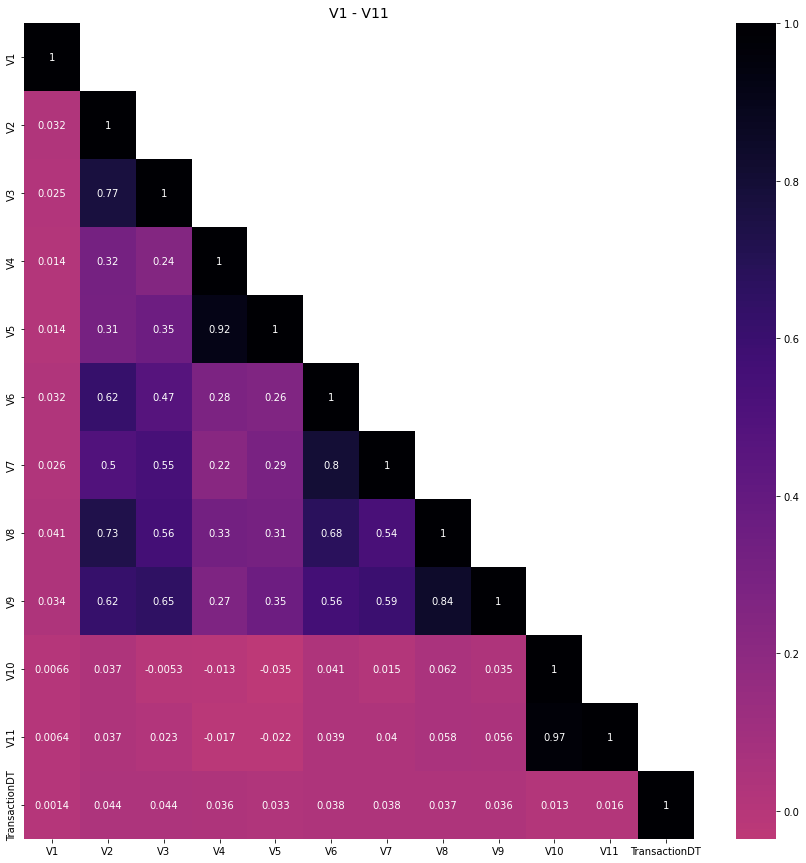

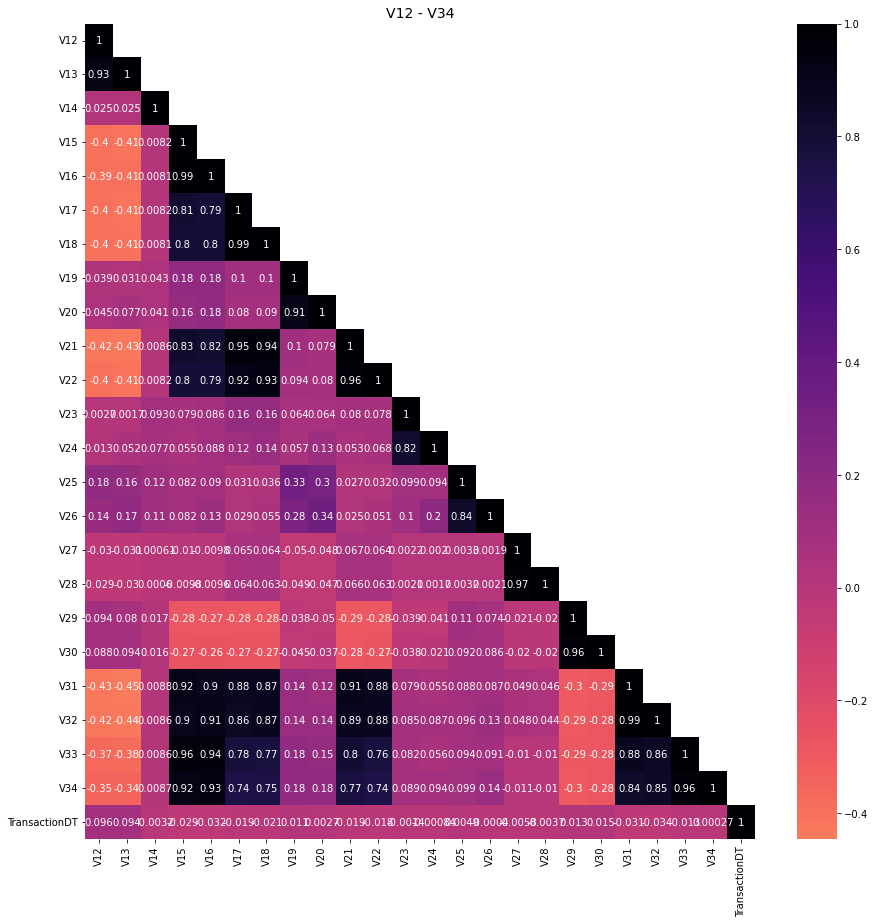

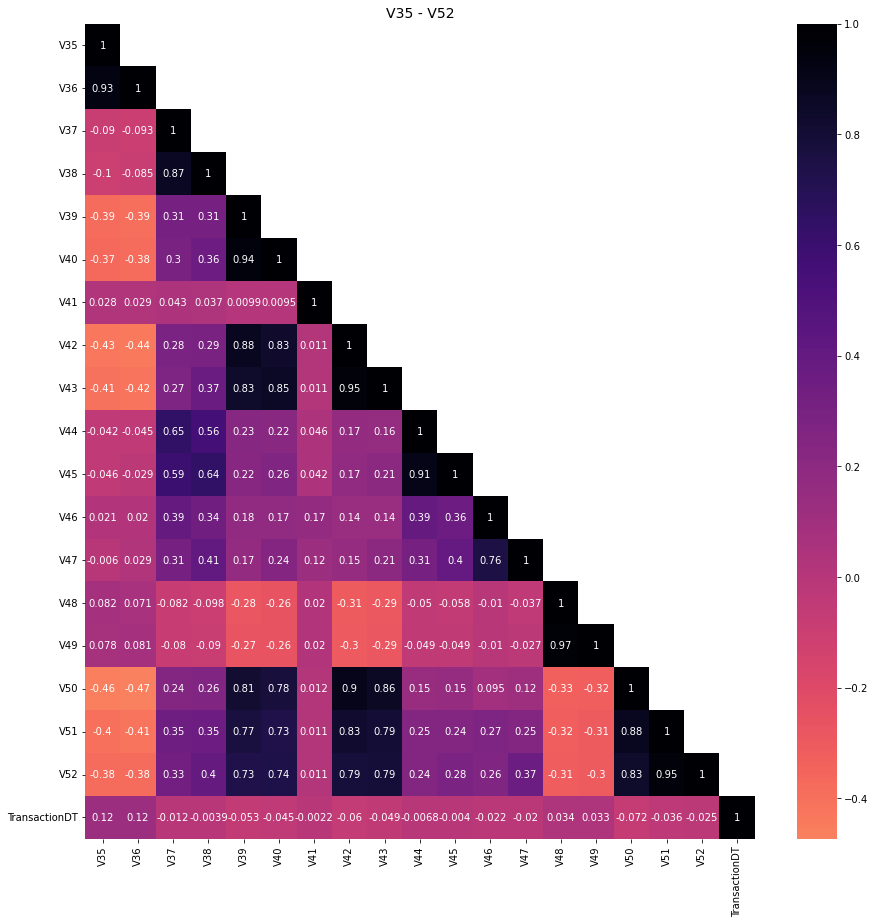

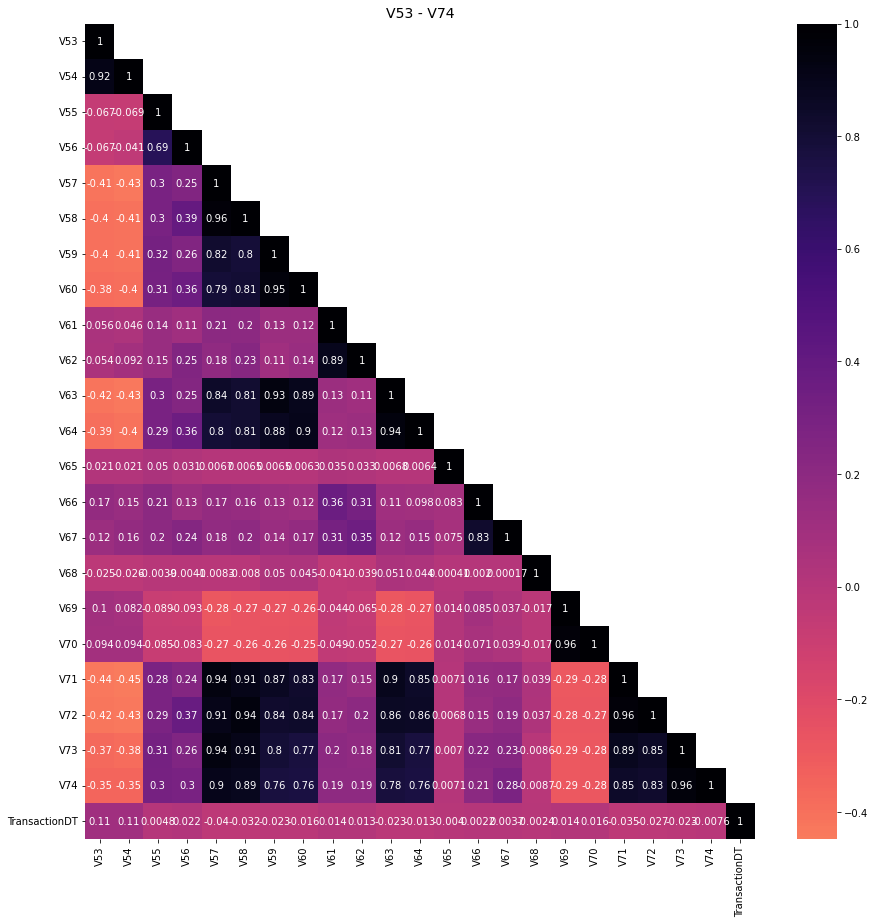

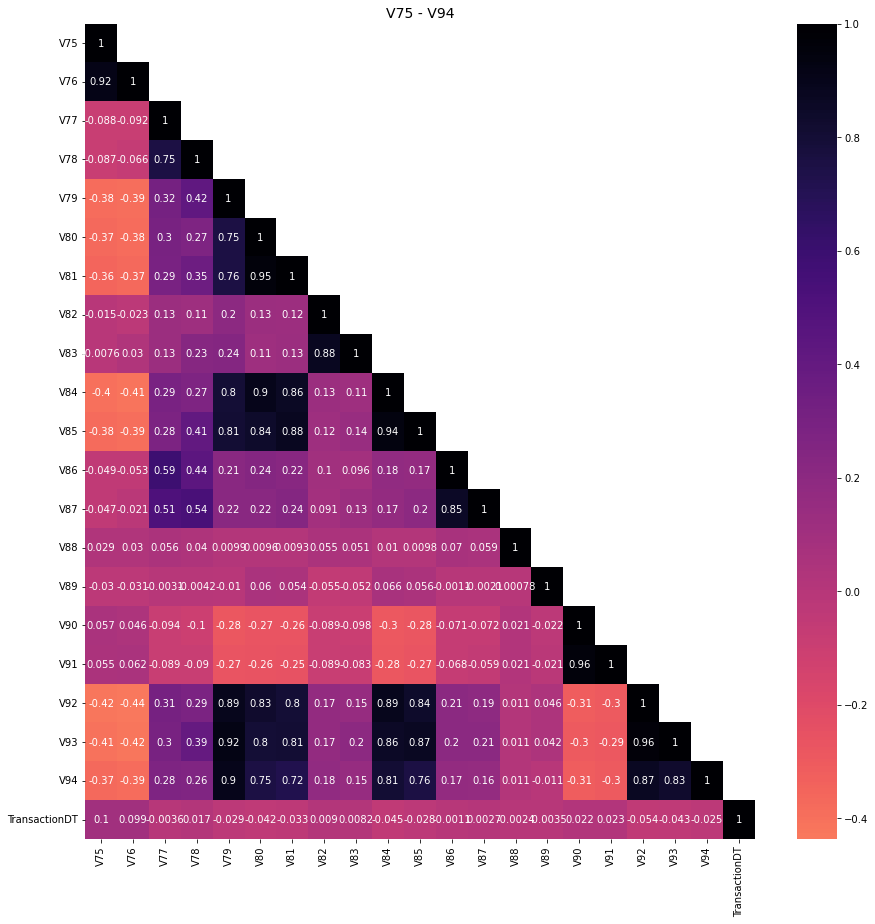

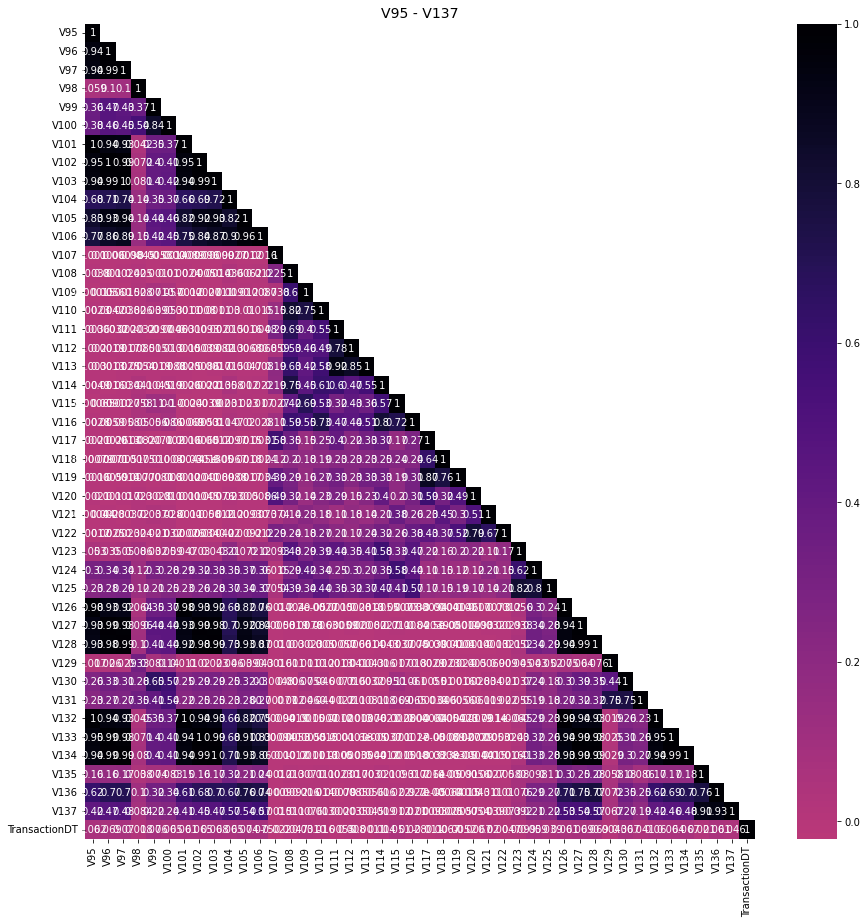

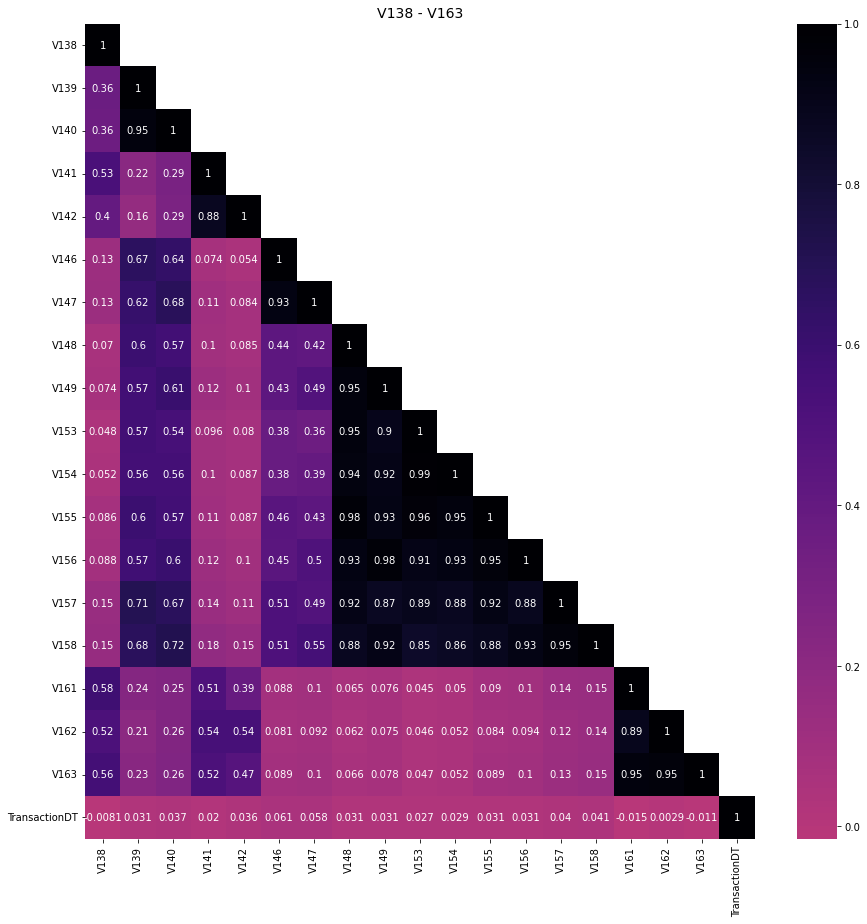

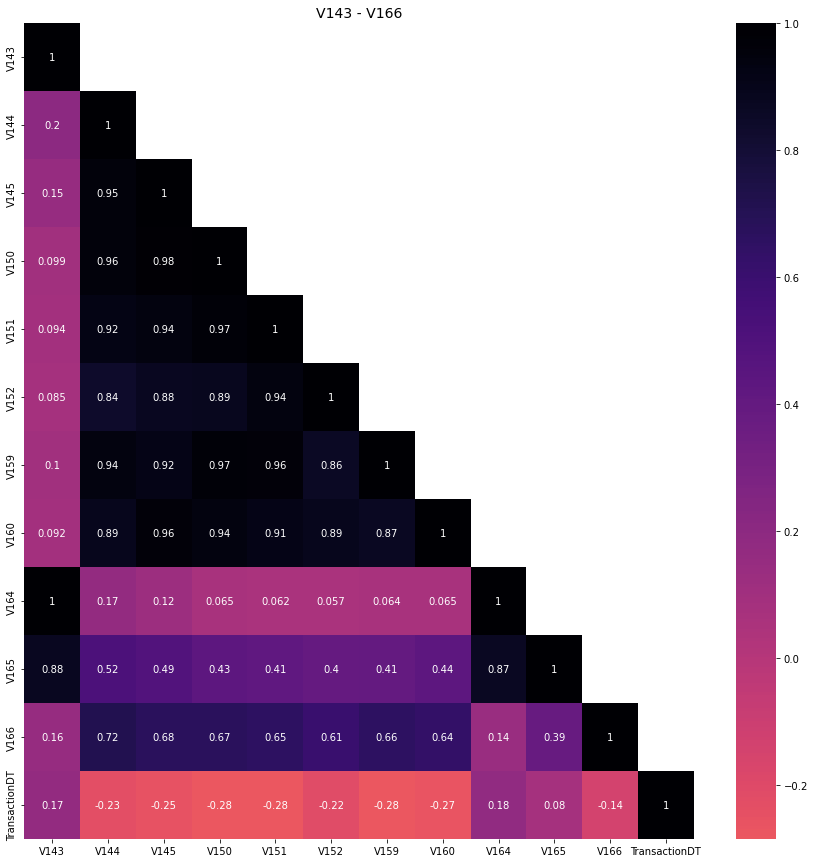

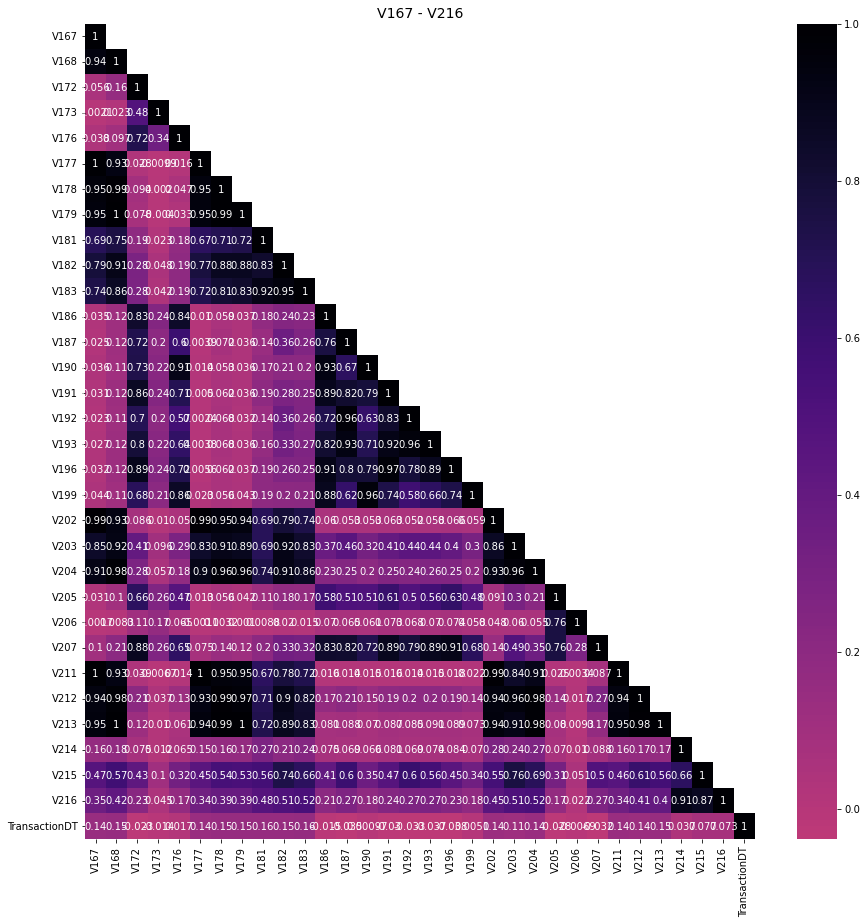

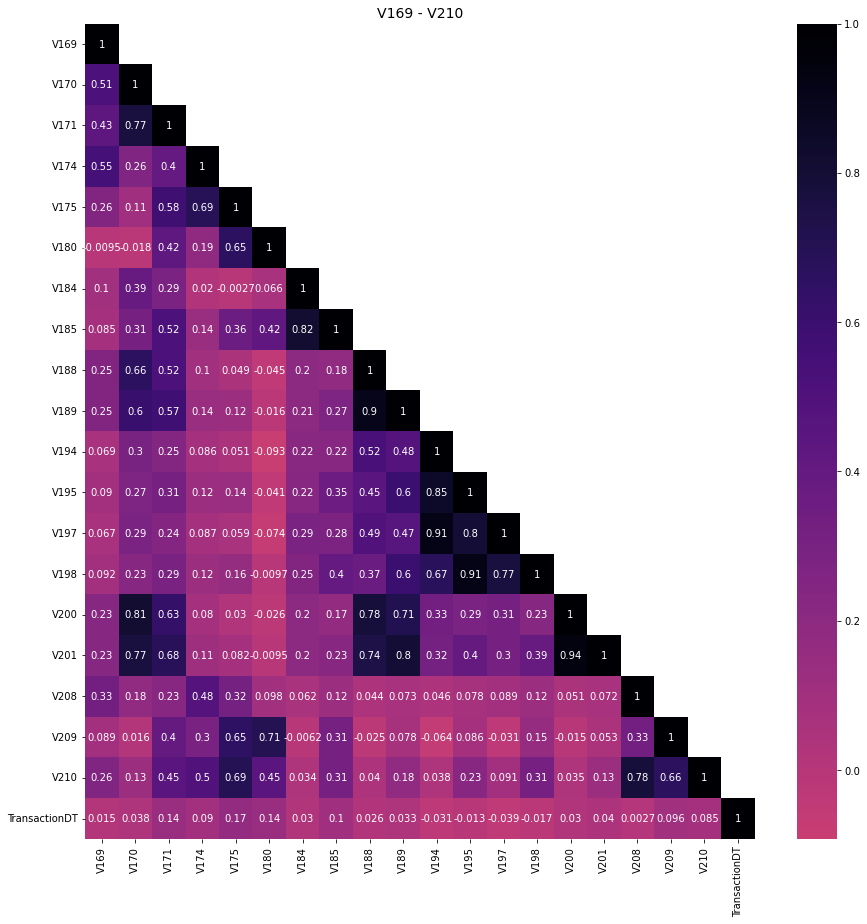

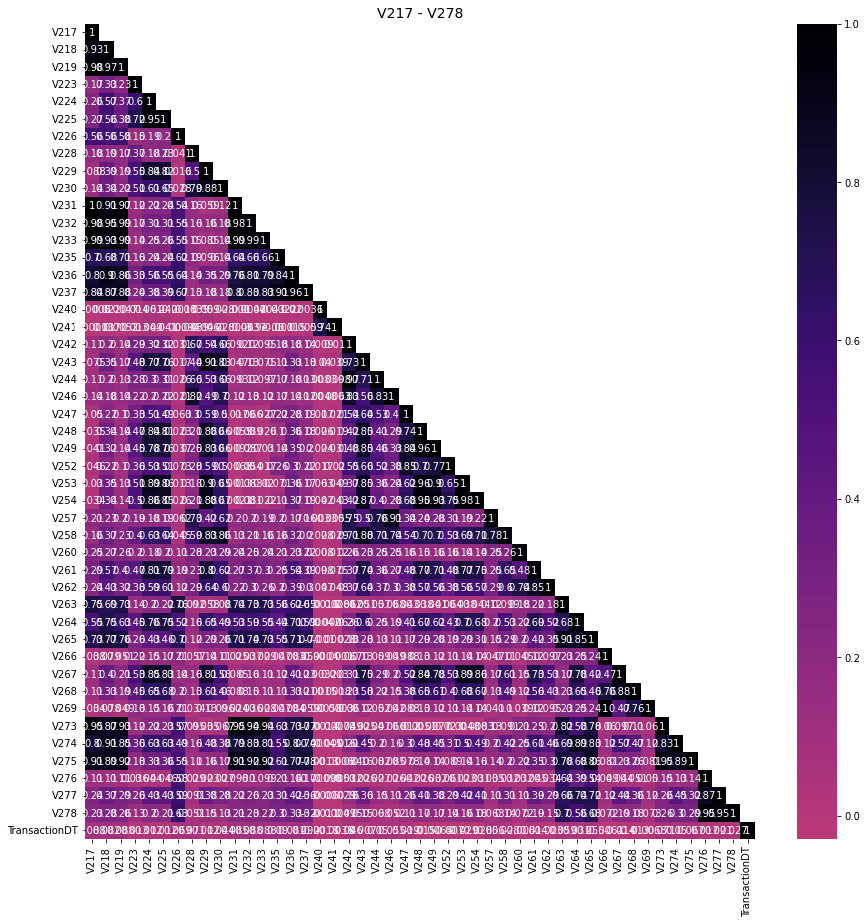

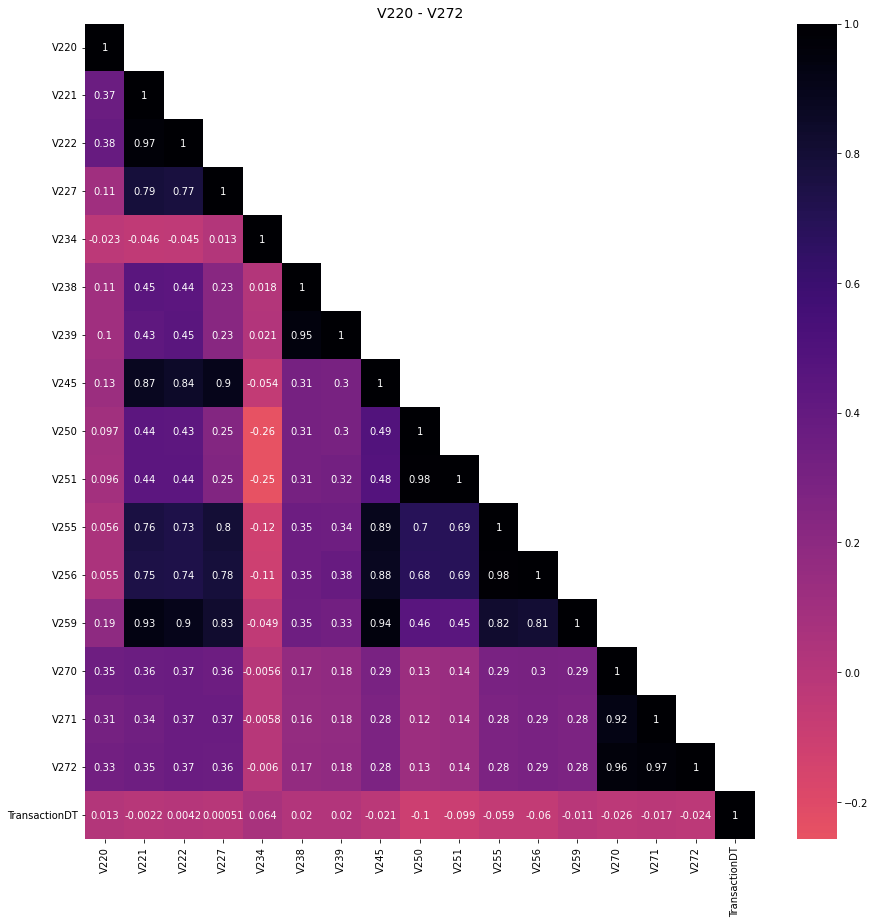

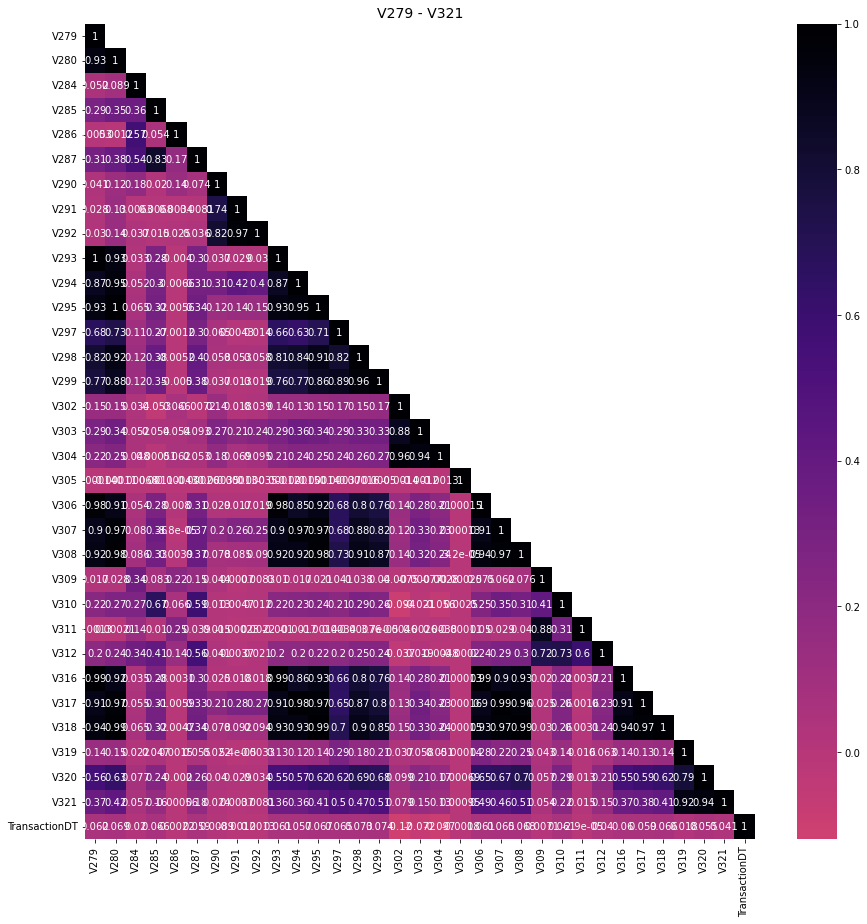

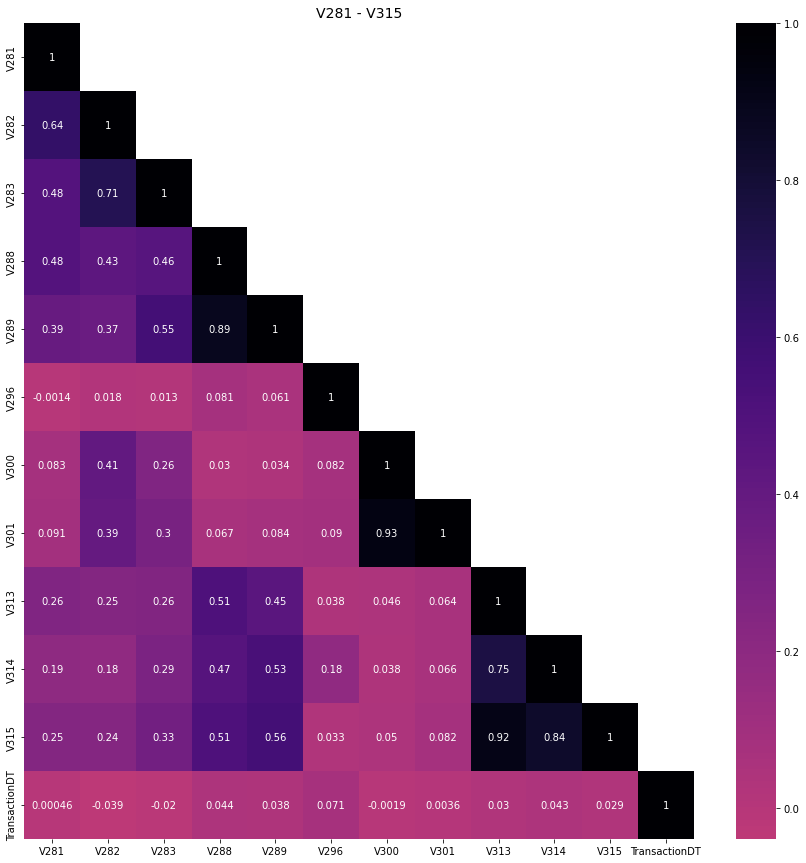

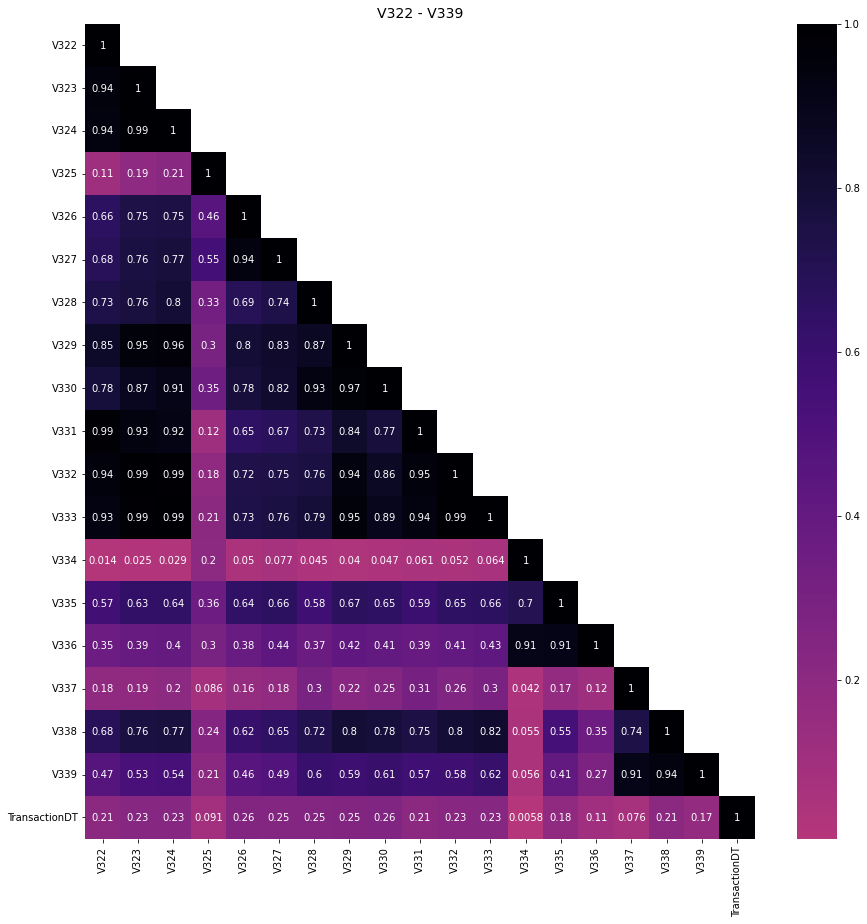

In [87]:
for k,v in nan_groups.items():
    plot_corr(v)

### id1-id38
* id1-id11 are numeric features
* id12-id38 are categorical features.

In [88]:
id_cols = [c for c in train_test if c[:2] == 'id']

id_num_cols=id_cols[:11]
id_cat_cols=id_cols[11:]

In [89]:
train[id_num_cols].describe()

id_01      id_02     id_03     id_04      id_05      id_06  \
count 144233.000 140872.000 66324.000 66324.000 136865.000 136865.000   
mean     -10.171 174716.938     0.060    -0.059      1.616     -6.699   
std       14.343 159650.000     0.598     0.701      5.248     16.482   
min     -100.000      1.000   -13.000   -28.000    -72.000   -100.000   
25%      -10.000  67992.000     0.000     0.000      0.000     -6.000   
50%       -5.000 125800.500     0.000     0.000      0.000      0.000   
75%       -5.000 228749.000     0.000     0.000      1.000      0.000   
max        0.000 999595.000    10.000     0.000     52.000      0.000   

         id_07    id_08     id_09     id_10      id_11  
count 5155.000 5155.000 74926.000 74926.000 140978.000  
mean    13.285  -38.600     0.091    -0.301     99.744  
std     11.384   26.085     0.984     2.789      1.127  
min    -46.000 -100.000   -36.000  -100.000     90.000  
25%      5.000  -48.000     0.000     0.000    100.000  
50%     14.000  -34.000     0.000     0.000    100.000  
75%     22.000  -23.000     0.000     0.000    100.000  
max     61.000    0.000    25.000     0.000    100.000

In [90]:
for i in range(len(id_cat_cols)):
    print(id_cat_cols[i]+" has "+ str(train[id_cat_cols[i]].nunique()) + " unique value.")

id_12 has 2 unique value.
id_13 has 54 unique value.
id_14 has 25 unique value.
id_15 has 3 unique value.
id_16 has 2 unique value.
id_17 has 104 unique value.
id_18 has 18 unique value.
id_19 has 522 unique value.
id_20 has 394 unique value.
id_21 has 490 unique value.
id_22 has 25 unique value.
id_23 has 3 unique value.
id_24 has 12 unique value.
id_25 has 341 unique value.
id_26 has 95 unique value.
id_27 has 2 unique value.
id_28 has 2 unique value.
id_29 has 2 unique value.
id_30 has 75 unique value.
id_31 has 130 unique value.
id_32 has 4 unique value.
id_33 has 260 unique value.
id_34 has 4 unique value.
id_35 has 2 unique value.
id_36 has 2 unique value.
id_37 has 2 unique value.
id_38 has 2 unique value.


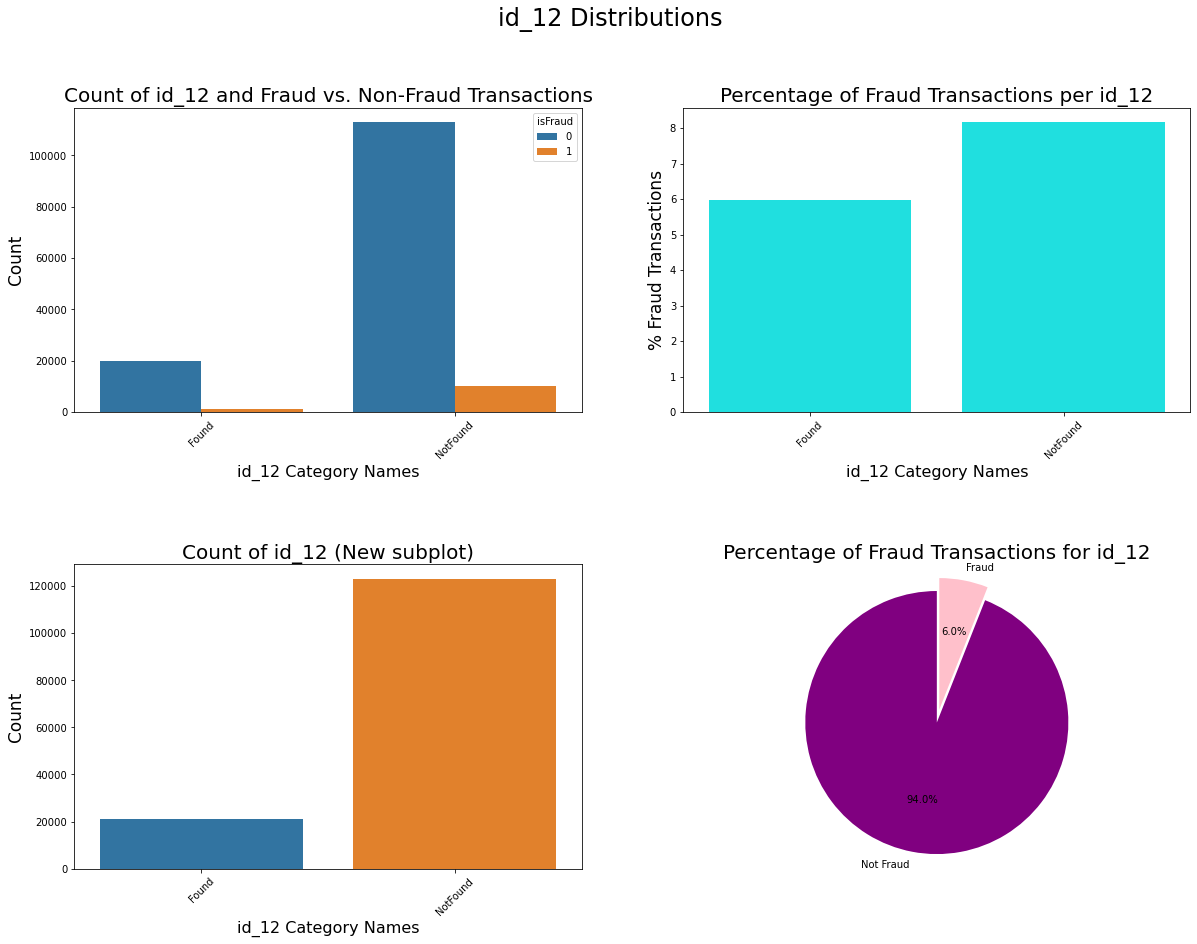

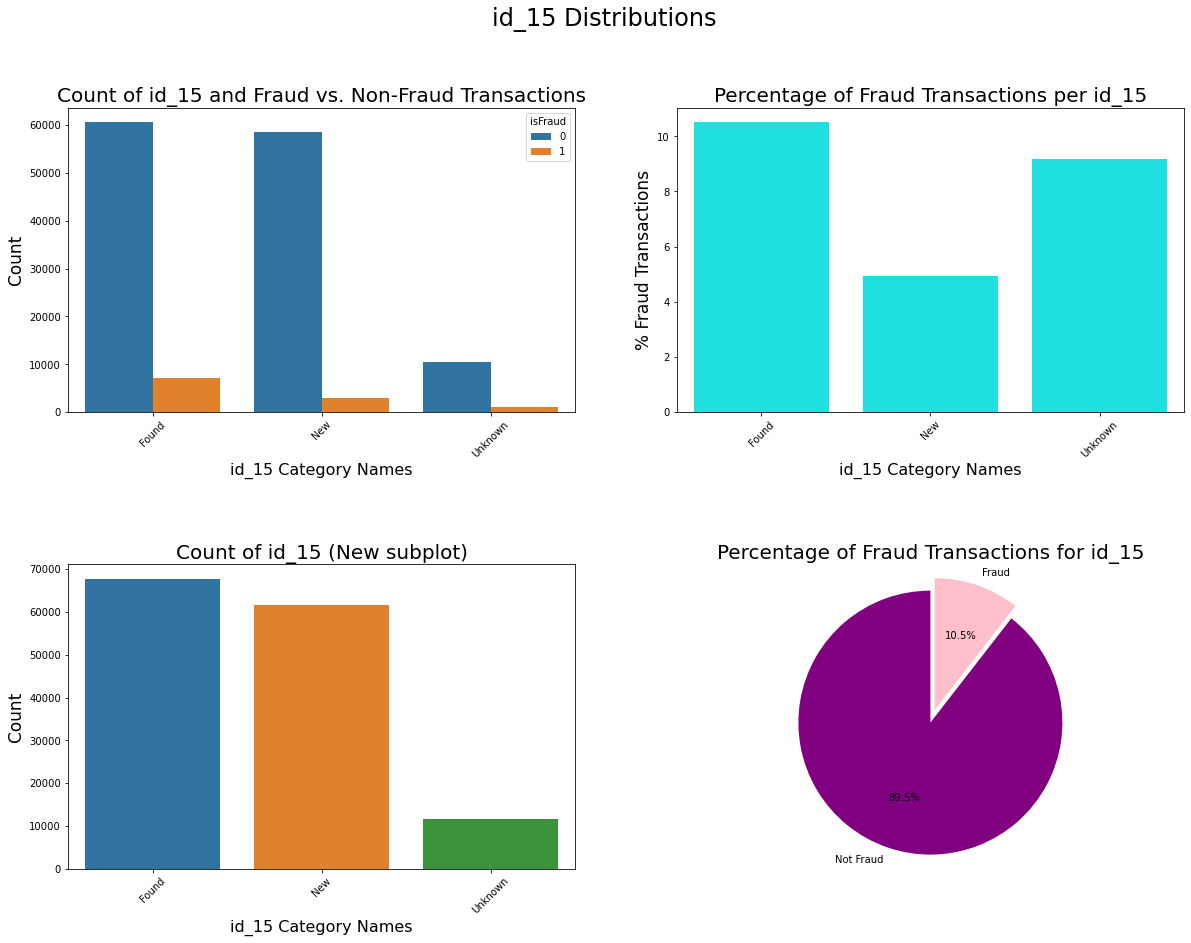

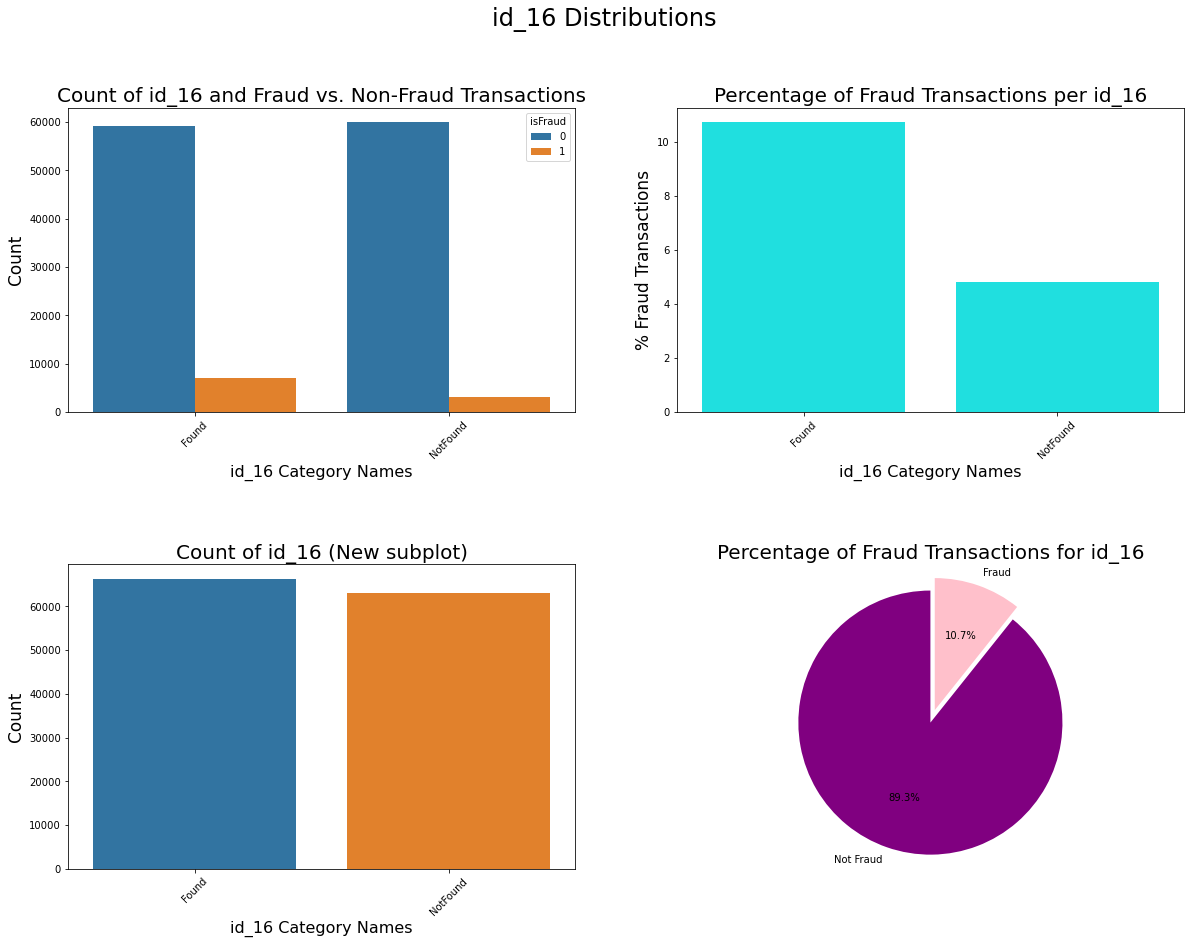

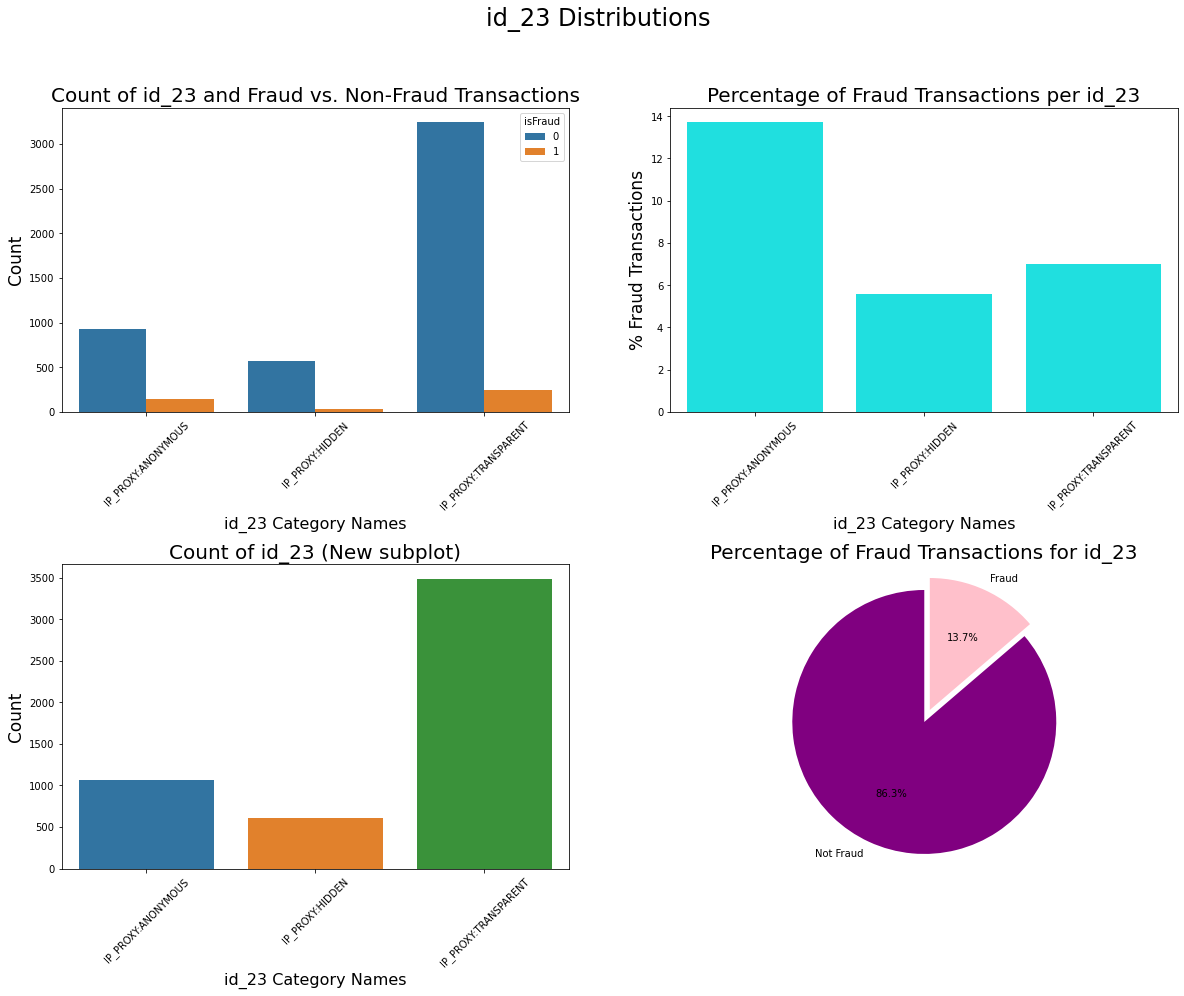

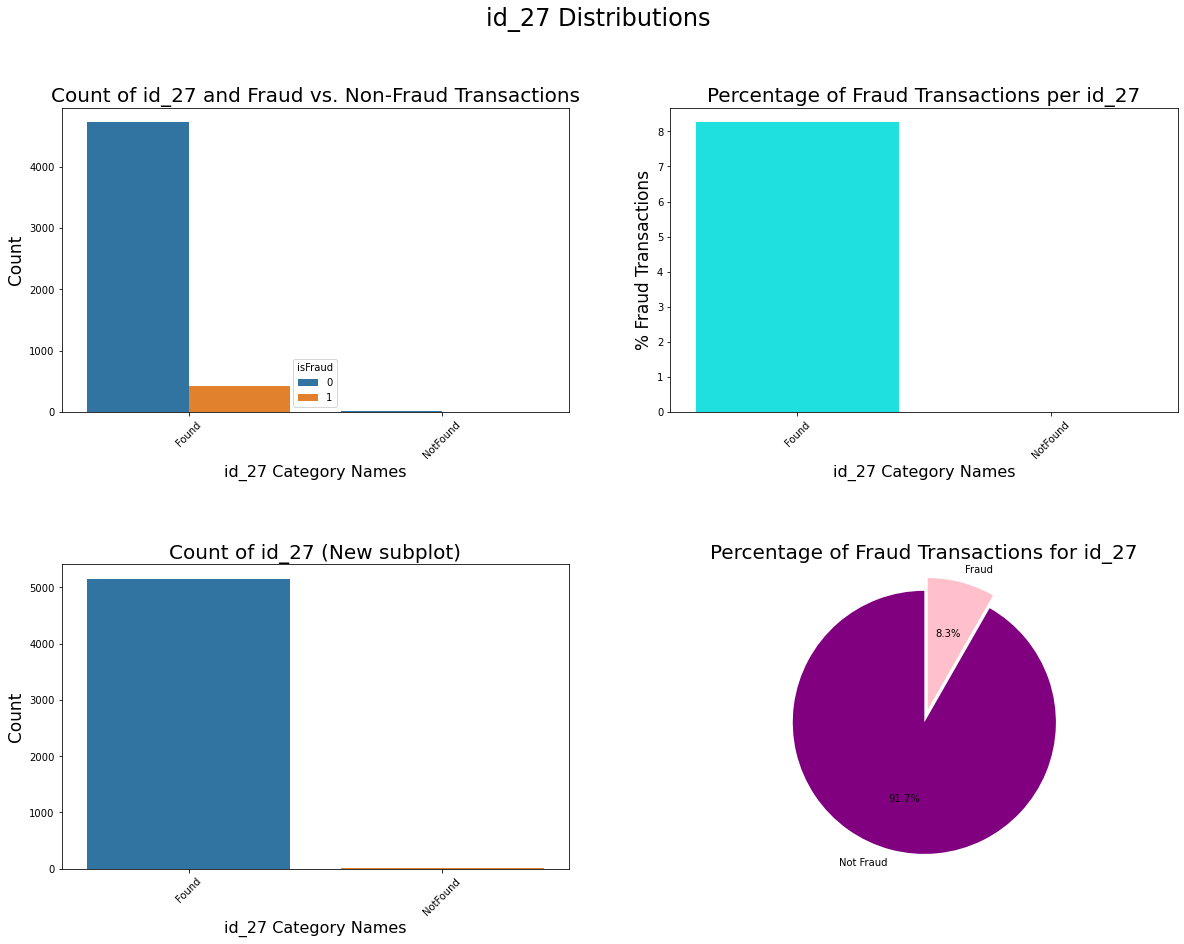

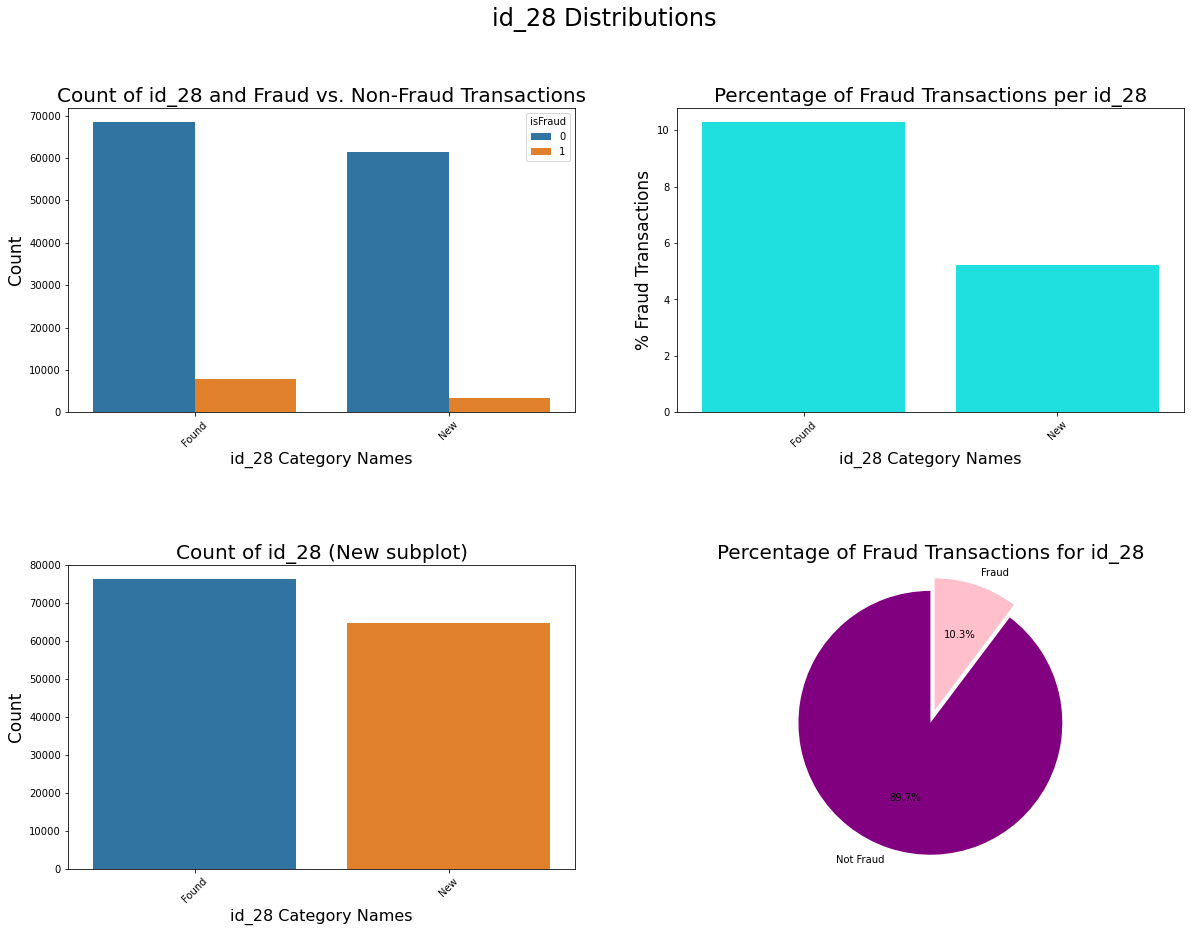

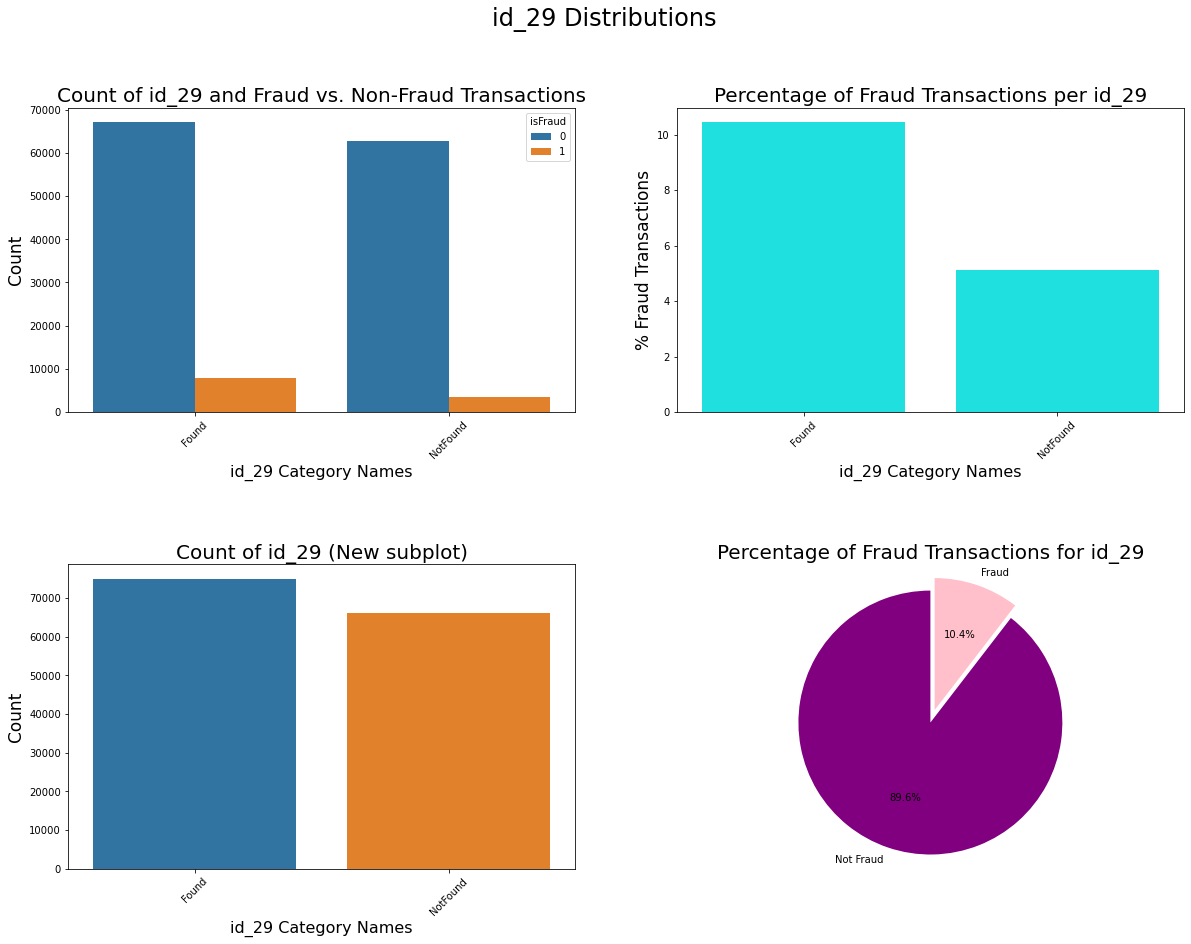

In [91]:
for col in  ['id_12', 'id_15', 'id_16', 'id_23', 'id_27', 'id_28', 'id_29']:
    visualize_distributions(train, col, lim=2500)

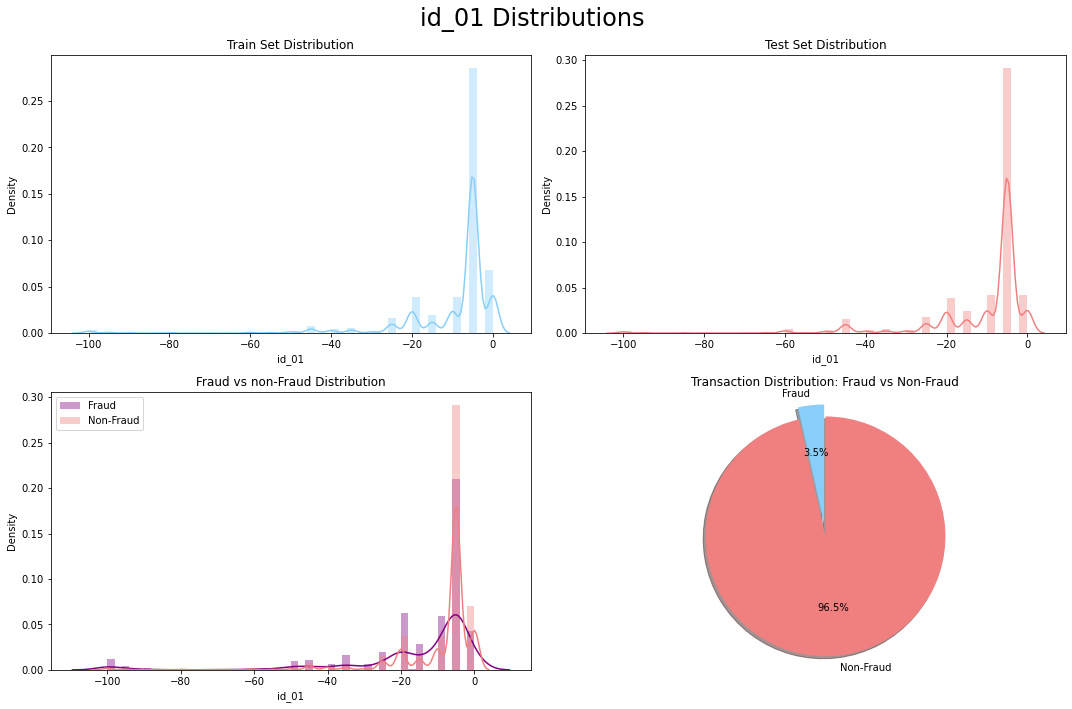

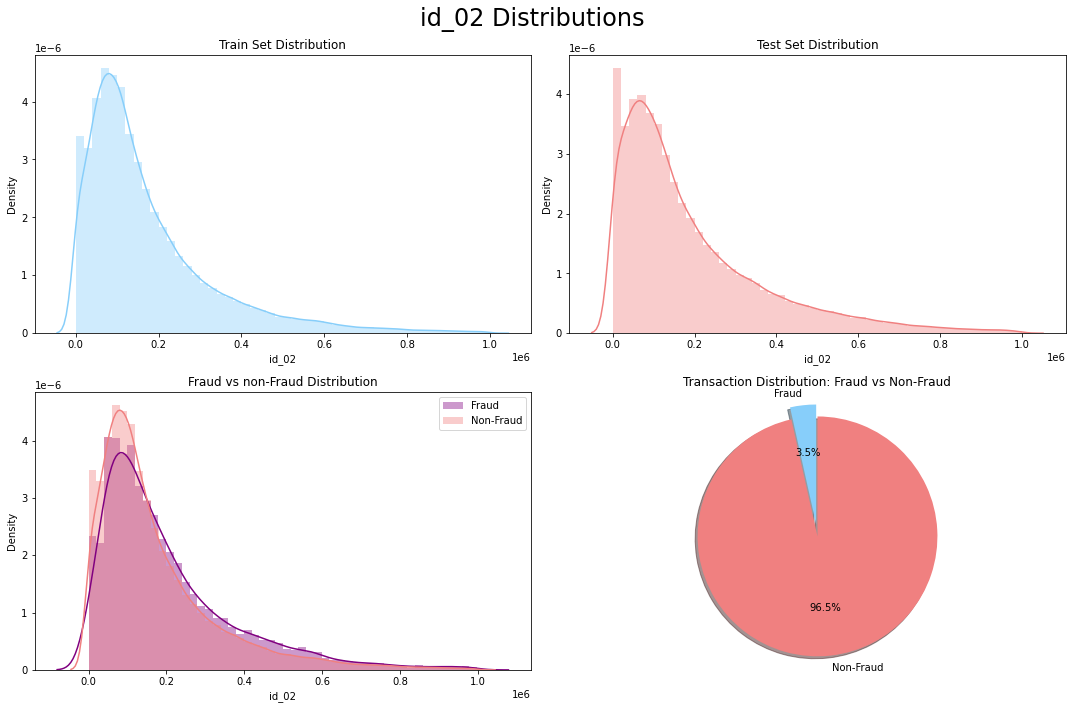

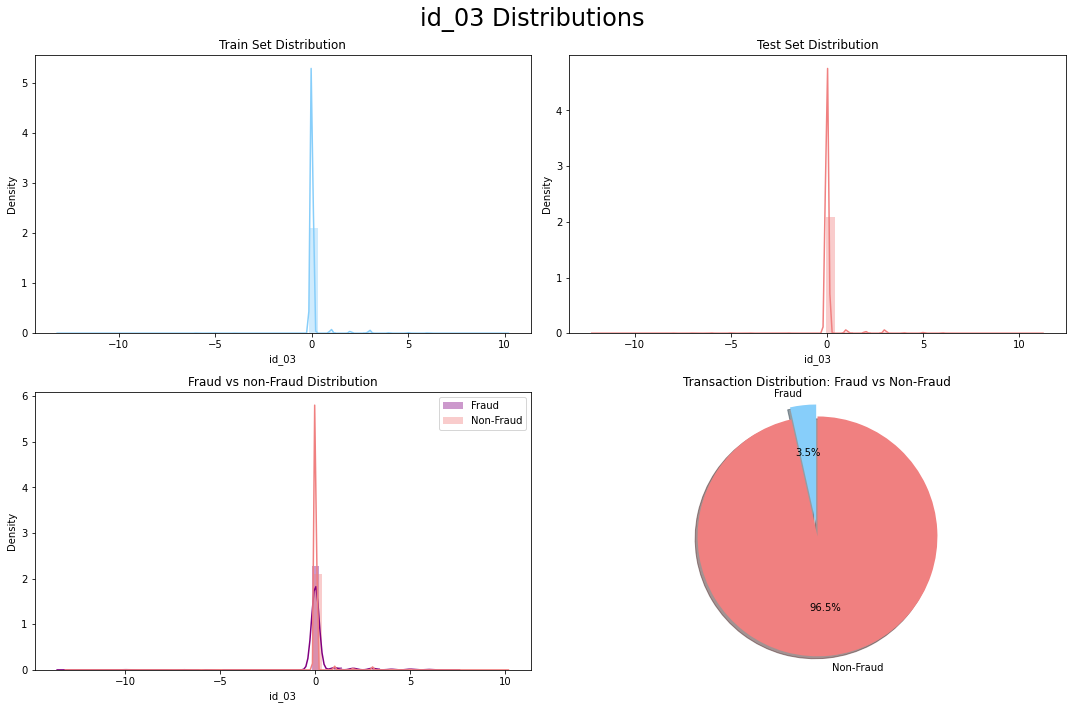

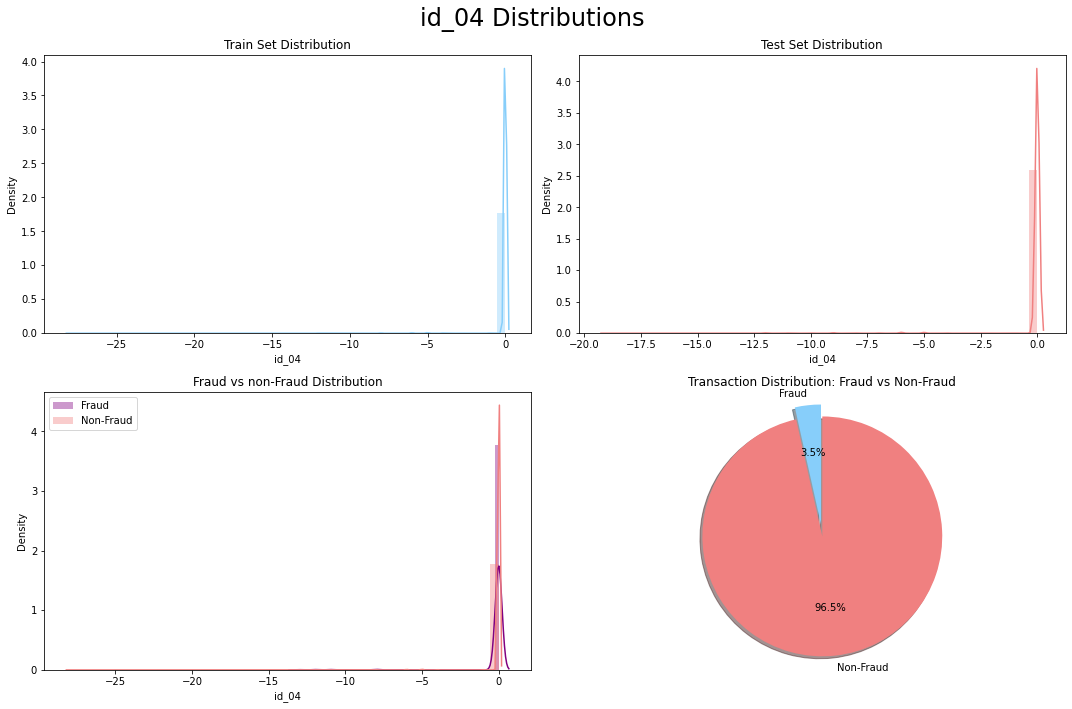

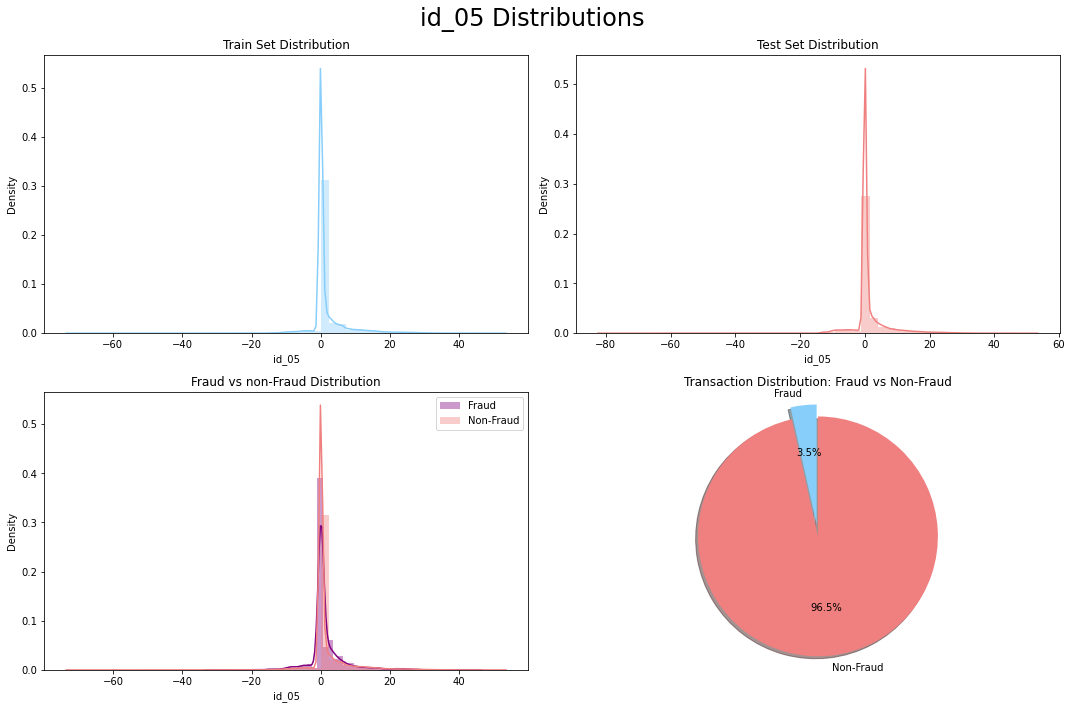

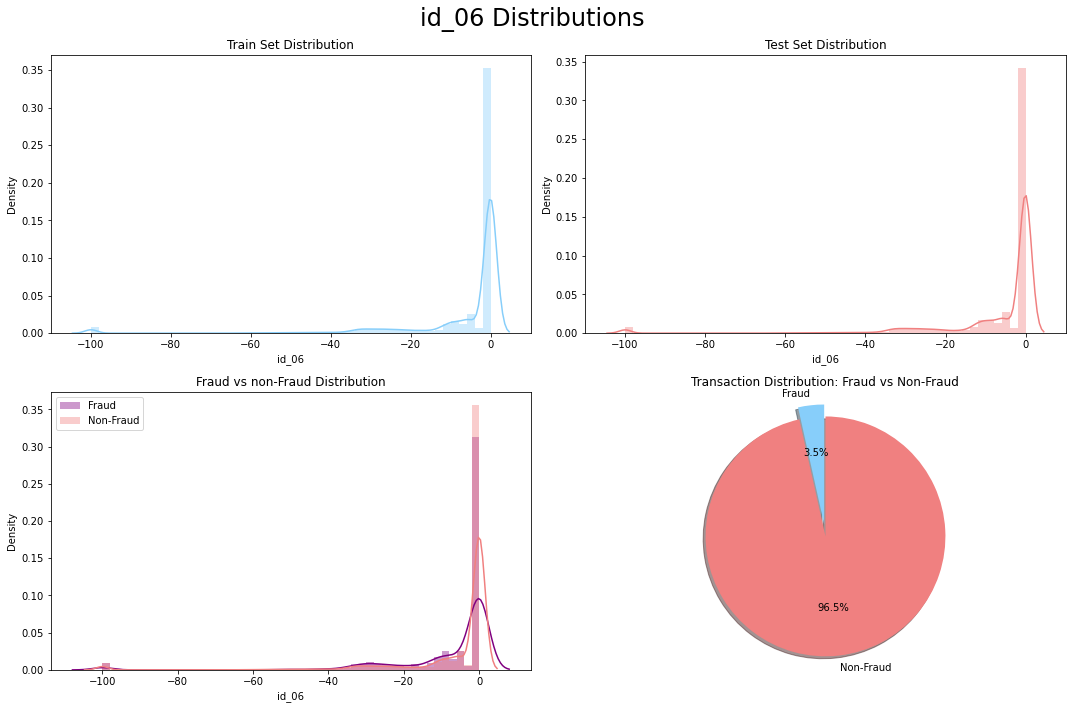

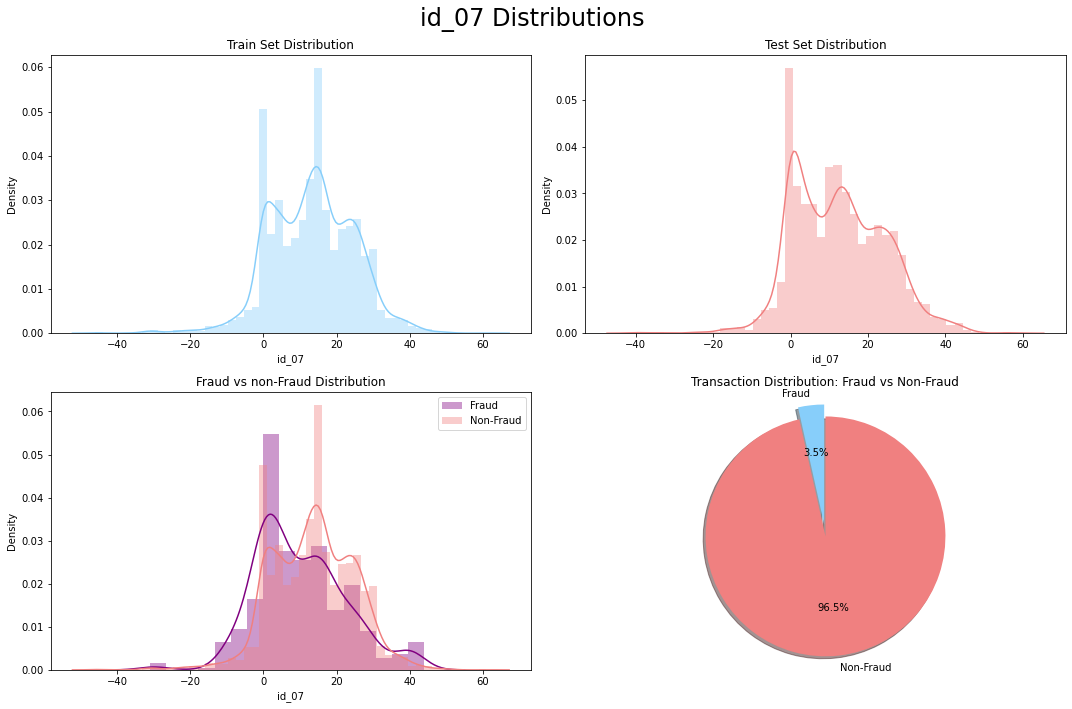

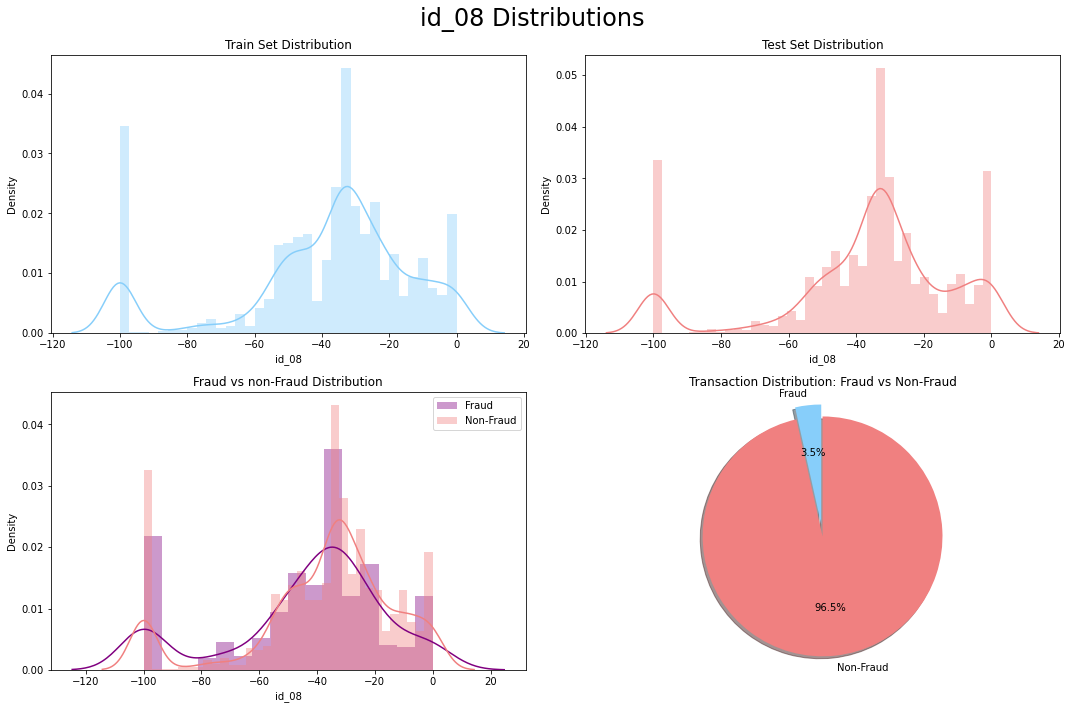

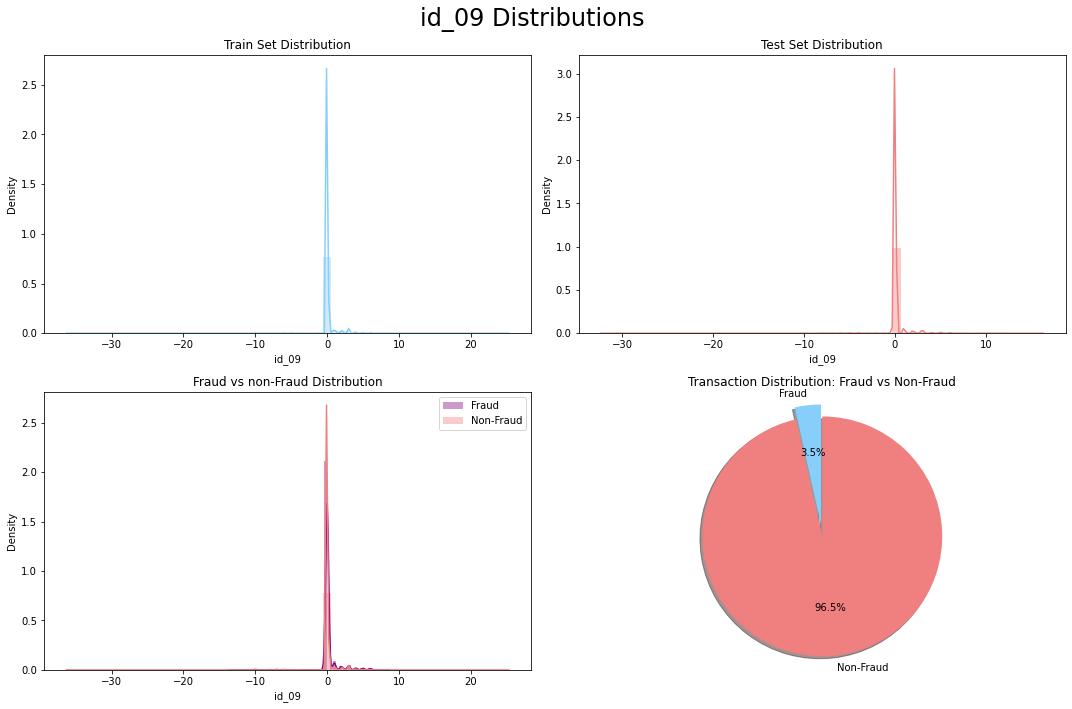

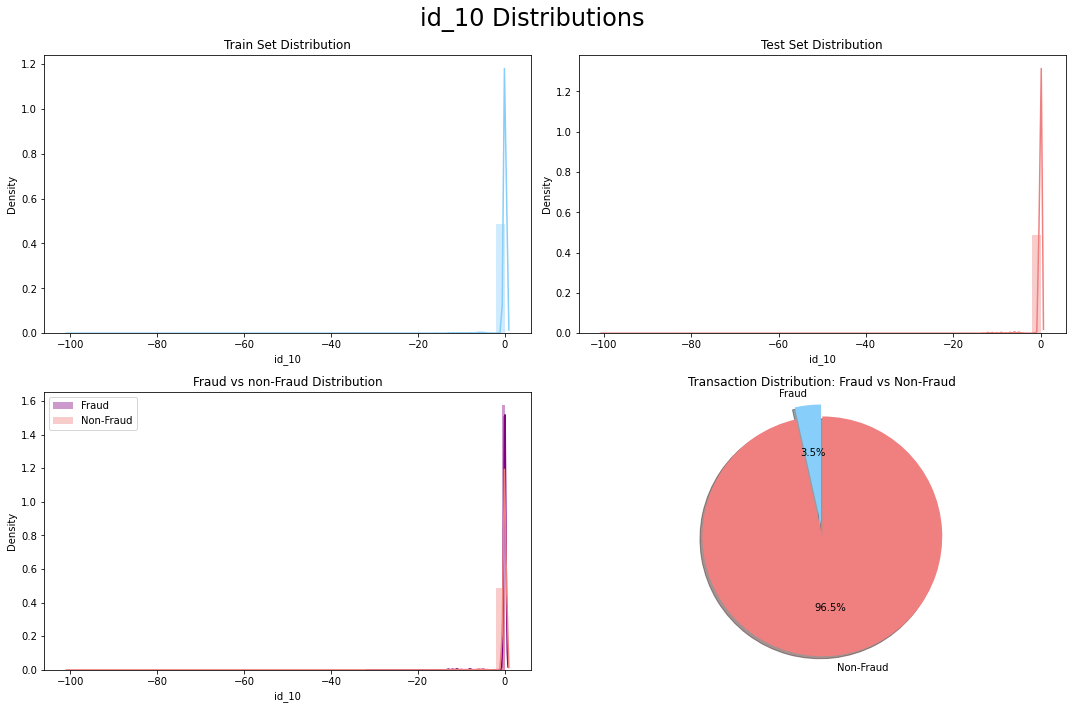

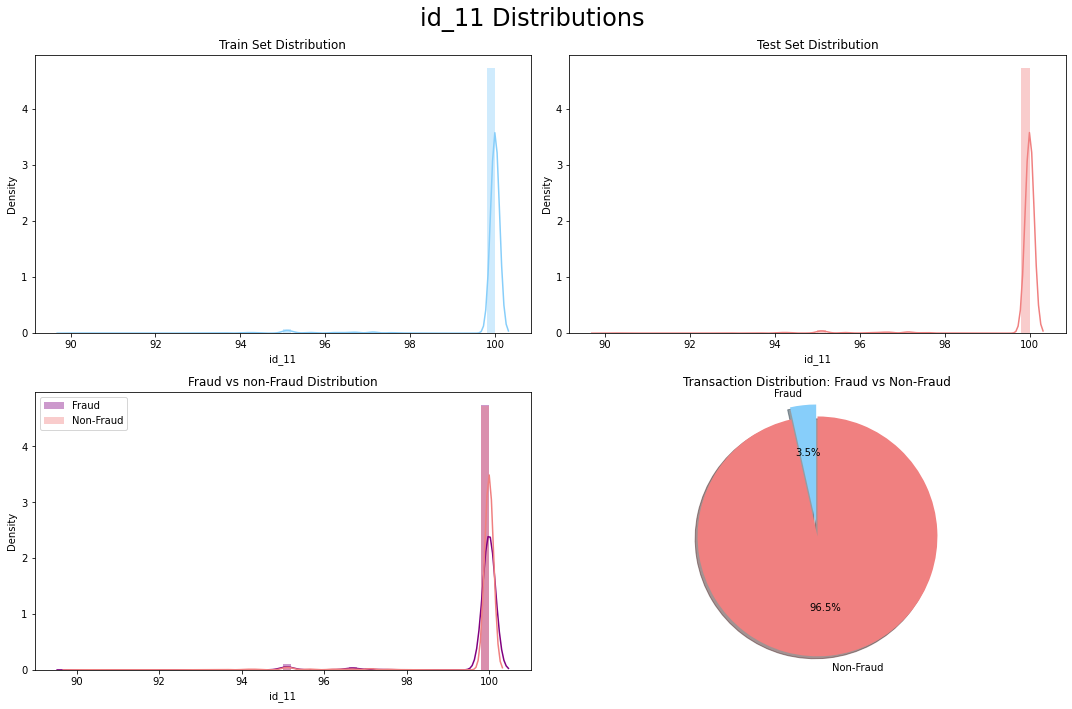

In [92]:
for num in  id_num_cols :
    plot_distributions_cont_features(train, test, train_fraudulent, train_non_fraudulent, num)

# Preprocessing

### PCA (for V columns)

In [93]:
v_nan_df = train_test[v_cols].isna()
nan_groups={}

In [94]:
for col in v_cols:
    cur_group = v_nan_df[col].sum()
    try:
        nan_groups[cur_group].append(col)
    except:
        nan_groups[cur_group]=[col]
del v_nan_df; x=gc.collect()

In [95]:
for nan_cnt, v_group in nan_groups.items():
    train_test['New_v_group_'+str(nan_cnt)+'_nulls'] = nan_cnt
    sc = StandardScaler()
    pca = PCA(n_components=2)
    v_group_pca = pca.fit_transform(sc.fit_transform(train_test[v_group].fillna(-1)))
    train_test['New_v_group_'+str(nan_cnt)+'_pca0'] = v_group_pca[:,0]
    train_test['New_v_group_'+str(nan_cnt)+'_pca1'] = v_group_pca[:,1]

### Removing Unnecessary Columns

In [96]:
train_test=train_test.drop(v_cols, axis=1)

In [97]:
#After feature extraction, we delete the unnecessary columns
train_test=train_test.drop(["TransactionDT","New_Date"], axis=1)

### Filling in Missing Values

In [98]:
train_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1097231 entries, 0 to 1097230
Columns: 145 entries, TransactionID to New_v_group_938449_pca1
dtypes: float32(90), float64(1), int16(1), int32(1), int64(18), object(34)
memory usage: 826.7+ MB


In [99]:
#combined_df = pd.concat([train.drop(columns=['isFraud', 'TransactionID']), test.drop(columns='TransactionID')])
combined_df = train_test.drop(columns=['isFraud', 'TransactionID'])
print(combined_df.shape)
combined_df.head()

(1097231, 143)


TransactionAmt ProductCD  card1   card2   card3       card4   card5  \
0          68.500         W  13926 327.000 150.000    discover 142.000   
1          29.000         W   2755 404.000 150.000  mastercard 102.000   
2          59.000         W   4663 490.000 150.000        visa 166.000   
3          50.000         W  18132 567.000 150.000  mastercard 117.000   
4          50.000         H   4497 514.000 150.000  mastercard 102.000   

    card6   addr1  addr2   dist1  dist2 P_emaildomain R_emaildomain    C1  \
0  credit 315.000 87.000  19.000    NaN           NaN           NaN 1.000   
1  credit 325.000 87.000     NaN    NaN     gmail.com           NaN 1.000   
2   debit 330.000 87.000 287.000    NaN   outlook.com           NaN 1.000   
3   debit 476.000 87.000     NaN    NaN     yahoo.com           NaN 2.000   
4  credit 420.000 87.000     NaN    NaN     gmail.com           NaN 1.000   

     C2    C3    C4    C5    C6    C7    C8    C9   C10   C11   C12    C13  \
0 1.000 0.000 0.000 0.000 1.000 0.000 0.000 1.000 0.000 2.000 0.000  1.000   
1 1.000 0.000 0.000 0.000 1.000 0.000 0.000 0.000 0.000 1.000 0.000  1.000   
2 1.000 0.000 0.000 0.000 1.000 0.000 0.000 1.000 0.000 1.000 0.000  1.000   
3 5.000 0.000 0.000 0.000 4.000 0.000 0.000 1.000 0.000 1.000 0.000 25.000   
4 1.000 0.000 0.000 0.000 1.000 0.000 1.000 0.000 1.000 1.000 0.000  1.000   

    C14      D1      D2     D3     D4    D5  D6  D7  D8  D9    D10     D11  \
0 1.000  14.000     NaN 13.000    NaN   NaN NaN NaN NaN NaN 13.000  13.000   
1 1.000   0.000     NaN    NaN  0.000   NaN NaN NaN NaN NaN  0.000     NaN   
2 1.000   0.000     NaN    NaN  0.000   NaN NaN NaN NaN NaN  0.000 315.000   
3 1.000 112.000 112.000  0.000 94.000 0.000 NaN NaN NaN NaN 84.000     NaN   
4 1.000   0.000     NaN    NaN    NaN   NaN NaN NaN NaN NaN    NaN     NaN   

   D12  D13  D14     D15   M1   M2   M3   M4   M5   M6   M7   M8   M9  id_01  \
0  NaN  NaN  NaN   0.000    T    T    T   M2    F    T  NaN  NaN  NaN    NaN   
1  NaN  NaN  NaN   0.000  NaN  NaN  NaN   M0    T    T  NaN  NaN  NaN    NaN   
2  NaN  NaN  NaN 315.000    T    T    T   M0    F    F    F    F    F    NaN   
3  NaN  NaN  NaN 111.000  NaN  NaN  NaN   M0    T    F  NaN  NaN  NaN    NaN   
4  NaN  NaN  NaN     NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  0.000   

      id_02  id_03  id_04  id_05  id_06  id_07  id_08  id_09  id_10   id_11  \
0       NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN     NaN   
1       NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN     NaN   
2       NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN     NaN   
3       NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN     NaN   
4 70787.000    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN 100.000   

      id_12  id_13    id_14 id_15     id_16   id_17  id_18   id_19   id_20  \
0       NaN    NaN      NaN   NaN       NaN     NaN    NaN     NaN     NaN   
1       NaN    NaN      NaN   NaN       NaN     NaN    NaN     NaN     NaN   
2       NaN    NaN      NaN   NaN       NaN     NaN    NaN     NaN     NaN   
3       NaN    NaN      NaN   NaN       NaN     NaN    NaN     NaN     NaN   
4  NotFound    NaN -480.000   New  NotFound 166.000    NaN 542.000 144.000   

   id_21  id_22 id_23  id_24  id_25  id_26 id_27 id_28     id_29        id_30  \
0    NaN    NaN   NaN    NaN    NaN    NaN   NaN   NaN       NaN          NaN   
1    NaN    NaN   NaN    NaN    NaN    NaN   NaN   NaN       NaN          NaN   
2    NaN    NaN   NaN    NaN    NaN    NaN   NaN   NaN       NaN          NaN   
3    NaN    NaN   NaN    NaN    NaN    NaN   NaN   NaN       NaN          NaN   
4    NaN    NaN   NaN    NaN    NaN    NaN   NaN   New  NotFound  Android 7.0   

                 id_31  id_32      id_33           id_34 id_35 id_36 id_37  \
0                  NaN    NaN        NaN             NaN   NaN   NaN   NaN   
1                  NaN    NaN        NaN             NaN   NaN   NaN   NaN   
2          

In [100]:
# Dependent variable
y = train['isFraud']
print(y.shape)

(590540,)


In [101]:
# Dropping columns with more than 20% missing values 
mv = combined_df.isnull().sum()/len(combined_df)
combined_mv_df = combined_df.drop(columns=mv[mv>0.2].index)
del combined_df
print(combined_mv_df.shape)

(1097231, 80)


In [102]:
# Filtering numerical data
num_mv_df = combined_mv_df.select_dtypes(include=np.number)
print(num_mv_df.shape)

(1097231, 72)


In [103]:
# Filtering categorical data
cat_mv_df = combined_mv_df.select_dtypes(exclude=np.number)
print(cat_mv_df.shape)
del combined_mv_df

(1097231, 8)


In [104]:
# Filling missing values by median for numerical columns 
imp_median = SimpleImputer(missing_values=np.nan, strategy='median')
num_df = pd.DataFrame(imp_median.fit_transform(num_mv_df), columns=num_mv_df.columns)
del num_mv_df
print(num_df.shape)

(1097231, 72)


In [105]:
# Filling missing values by most frequent value for categorical columns
imp_max = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
cat_df = pd.DataFrame(imp_max.fit_transform(cat_mv_df), columns=cat_mv_df.columns)
del cat_mv_df
print(cat_df.shape)

(1097231, 8)


In [106]:
# Concatinating numerical and categorical data
combined_df_cleaned = pd.concat([num_df, cat_df], axis=1)
del num_df, cat_df

In [107]:
# Verifying missing values
print(f'Total missing values: {combined_df_cleaned.isnull().sum().sum()}')
print(combined_df_cleaned.shape)
combined_df_cleaned.head()

Total missing values: 0
(1097231, 80)


TransactionAmt     card1   card2   card3   card5   addr1  addr2    C1  \
0          68.500 13926.000 327.000 150.000 142.000 315.000 87.000 1.000   
1          29.000  2755.000 404.000 150.000 102.000 325.000 87.000 1.000   
2          59.000  4663.000 490.000 150.000 166.000 330.000 87.000 1.000   
3          50.000 18132.000 567.000 150.000 117.000 476.000 87.000 2.000   
4          50.000  4497.000 514.000 150.000 102.000 420.000 87.000 1.000   

     C2    C3    C4    C5    C6    C7    C8    C9   C10   C11   C12    C13  \
0 1.000 0.000 0.000 0.000 1.000 0.000 0.000 1.000 0.000 2.000 0.000  1.000   
1 1.000 0.000 0.000 0.000 1.000 0.000 0.000 0.000 0.000 1.000 0.000  1.000   
2 1.000 0.000 0.000 0.000 1.000 0.000 0.000 1.000 0.000 1.000 0.000  1.000   
3 5.000 0.000 0.000 0.000 4.000 0.000 0.000 1.000 0.000 1.000 0.000 25.000   
4 1.000 0.000 0.000 0.000 1.000 0.000 1.000 0.000 1.000 1.000 0.000  1.000   

    C14      D1    D10     D15  New_Date_Weekday  New_Date_Hour  New_Date_Day  \
0 1.000  14.000 13.000   0.000             5.000          0.000         2.000   
1 1.000   0.000  0.000   0.000             5.000          0.000         2.000   
2 1.000   0.000  0.000 315.000             5.000          0.000         2.000   
3 1.000 112.000 84.000 111.000             5.000          0.000         2.000   
4 1.000   0.000 13.000  50.000             5.000          0.000         2.000   

   New_v_group_455805_nulls  New_v_group_455805_pca0  New_v_group_455805_pca1  \
0                455805.000                    2.342                   -0.741   
1                455805.000                   -3.757                    0.036   
2                455805.000                    2.341                   -0.770   
3                455805.000                   -3.757                    0.036   
4                455805.000                   -3.757                    0.036   

   New_v_group_88662_nulls  New_v_group_88662_pca0  New_v_group_88662_pca1  \
0                88662.000                   0.352                  -0.999   
1                88662.000                  -0.032                   0.052   
2                88662.000                   0.352                  -1.010   
3                88662.000                   0.352                  -1.010   
4                88662.000                 -12.012                   2.114   

   New_v_group_245823_nulls  New_v_group_245823_pca0  New_v_group_245823_pca1  \
0                245823.000                   -6.393                    0.508   
1                245823.000                    0.685                    0.175   
2                245823.000                    1.187                   -0.775   
3                245823.000                    1.187                   -0.775   
4                245823.000                   -6.393                    0.553   

   New_v_group_89995_nulls  New_v_group_89995_pca0  New_v_group_89995_pca1  \
0                89995.000                   0.188                  -0.997   
1                89995.000                  -0.176                   0.185   
2                89995.000                   0.189                  -0.950   
3                89995.000                   0.189                  -0.950   
4                89995.000                 -10.956                   2.431   

   New_v_group_101245_nulls  New_v_group_101245_pca0  New_v_group_101245_pca1  \
0                101245.000                   -0.424                    0.516   
1                101245.000                   -0.154                   -0.232   
2                101245.000                    0.259                    0.900   
3                101245.000                    0.259                    0.900   
4                101245.000                   -9.521                   -1.872   

   New_v_group_314_nulls  New_v_group_314_pca0  New_v_group_314_pca1  \
0                314.000                -0.374                -0.303   
1                314.000                -0.410 

In [108]:
train_test = pd.concat([combined_df_cleaned, y], axis=1)

In [109]:
train_test.head()

TransactionAmt     card1   card2   card3   card5   addr1  addr2    C1  \
0          68.500 13926.000 327.000 150.000 142.000 315.000 87.000 1.000   
1          29.000  2755.000 404.000 150.000 102.000 325.000 87.000 1.000   
2          59.000  4663.000 490.000 150.000 166.000 330.000 87.000 1.000   
3          50.000 18132.000 567.000 150.000 117.000 476.000 87.000 2.000   
4          50.000  4497.000 514.000 150.000 102.000 420.000 87.000 1.000   

     C2    C3    C4    C5    C6    C7    C8    C9   C10   C11   C12    C13  \
0 1.000 0.000 0.000 0.000 1.000 0.000 0.000 1.000 0.000 2.000 0.000  1.000   
1 1.000 0.000 0.000 0.000 1.000 0.000 0.000 0.000 0.000 1.000 0.000  1.000   
2 1.000 0.000 0.000 0.000 1.000 0.000 0.000 1.000 0.000 1.000 0.000  1.000   
3 5.000 0.000 0.000 0.000 4.000 0.000 0.000 1.000 0.000 1.000 0.000 25.000   
4 1.000 0.000 0.000 0.000 1.000 0.000 1.000 0.000 1.000 1.000 0.000  1.000   

    C14      D1    D10     D15  New_Date_Weekday  New_Date_Hour  New_Date_Day  \
0 1.000  14.000 13.000   0.000             5.000          0.000         2.000   
1 1.000   0.000  0.000   0.000             5.000          0.000         2.000   
2 1.000   0.000  0.000 315.000             5.000          0.000         2.000   
3 1.000 112.000 84.000 111.000             5.000          0.000         2.000   
4 1.000   0.000 13.000  50.000             5.000          0.000         2.000   

   New_v_group_455805_nulls  New_v_group_455805_pca0  New_v_group_455805_pca1  \
0                455805.000                    2.342                   -0.741   
1                455805.000                   -3.757                    0.036   
2                455805.000                    2.341                   -0.770   
3                455805.000                   -3.757                    0.036   
4                455805.000                   -3.757                    0.036   

   New_v_group_88662_nulls  New_v_group_88662_pca0  New_v_group_88662_pca1  \
0                88662.000                   0.352                  -0.999   
1                88662.000                  -0.032                   0.052   
2                88662.000                   0.352                  -1.010   
3                88662.000                   0.352                  -1.010   
4                88662.000                 -12.012                   2.114   

   New_v_group_245823_nulls  New_v_group_245823_pca0  New_v_group_245823_pca1  \
0                245823.000                   -6.393                    0.508   
1                245823.000                    0.685                    0.175   
2                245823.000                    1.187                   -0.775   
3                245823.000                    1.187                   -0.775   
4                245823.000                   -6.393                    0.553   

   New_v_group_89995_nulls  New_v_group_89995_pca0  New_v_group_89995_pca1  \
0                89995.000                   0.188                  -0.997   
1                89995.000                  -0.176                   0.185   
2                89995.000                   0.189                  -0.950   
3                89995.000                   0.189                  -0.950   
4                89995.000                 -10.956                   2.431   

   New_v_group_101245_nulls  New_v_group_101245_pca0  New_v_group_101245_pca1  \
0                101245.000                   -0.424                    0.516   
1                101245.000                   -0.154                   -0.232   
2                101245.000                    0.259                    0.900   
3                101245.000                    0.259                    0.900   
4                101245.000                   -9.521                   -1.872   

   New_v_group_314_nulls  New_v_group_314_pca0  New_v_group_314_pca1  \
0                314.000                -0.374                -0.303   
1                314.000                -0.410 

### Frequency Encoding 

In [110]:
fe_col_list=['card4','card6','P_emaildomain','DeviceInfo']+[c for c in train_test if c[0] == 'M']
for col in fe_col_list:
    vc = train_test[col].value_counts(dropna=True, normalize=True).to_dict()
    vc[-1] = -1
    nm = 'New_'+col+'_FE'
    train_test[nm] = train_test[col].map(vc)
    train_test[nm] = train_test[nm].astype('float32')

In [111]:
train_test.head()

TransactionAmt     card1   card2   card3   card5   addr1  addr2    C1  \
0          68.500 13926.000 327.000 150.000 142.000 315.000 87.000 1.000   
1          29.000  2755.000 404.000 150.000 102.000 325.000 87.000 1.000   
2          59.000  4663.000 490.000 150.000 166.000 330.000 87.000 1.000   
3          50.000 18132.000 567.000 150.000 117.000 476.000 87.000 2.000   
4          50.000  4497.000 514.000 150.000 102.000 420.000 87.000 1.000   

     C2    C3    C4    C5    C6    C7    C8    C9   C10   C11   C12    C13  \
0 1.000 0.000 0.000 0.000 1.000 0.000 0.000 1.000 0.000 2.000 0.000  1.000   
1 1.000 0.000 0.000 0.000 1.000 0.000 0.000 0.000 0.000 1.000 0.000  1.000   
2 1.000 0.000 0.000 0.000 1.000 0.000 0.000 1.000 0.000 1.000 0.000  1.000   
3 5.000 0.000 0.000 0.000 4.000 0.000 0.000 1.000 0.000 1.000 0.000 25.000   
4 1.000 0.000 0.000 0.000 1.000 0.000 1.000 0.000 1.000 1.000 0.000  1.000   

    C14      D1    D10     D15  New_Date_Weekday  New_Date_Hour  New_Date_Day  \
0 1.000  14.000 13.000   0.000             5.000          0.000         2.000   
1 1.000   0.000  0.000   0.000             5.000          0.000         2.000   
2 1.000   0.000  0.000 315.000             5.000          0.000         2.000   
3 1.000 112.000 84.000 111.000             5.000          0.000         2.000   
4 1.000   0.000 13.000  50.000             5.000          0.000         2.000   

   New_v_group_455805_nulls  New_v_group_455805_pca0  New_v_group_455805_pca1  \
0                455805.000                    2.342                   -0.741   
1                455805.000                   -3.757                    0.036   
2                455805.000                    2.341                   -0.770   
3                455805.000                   -3.757                    0.036   
4                455805.000                   -3.757                    0.036   

   New_v_group_88662_nulls  New_v_group_88662_pca0  New_v_group_88662_pca1  \
0                88662.000                   0.352                  -0.999   
1                88662.000                  -0.032                   0.052   
2                88662.000                   0.352                  -1.010   
3                88662.000                   0.352                  -1.010   
4                88662.000                 -12.012                   2.114   

   New_v_group_245823_nulls  New_v_group_245823_pca0  New_v_group_245823_pca1  \
0                245823.000                   -6.393                    0.508   
1                245823.000                    0.685                    0.175   
2                245823.000                    1.187                   -0.775   
3                245823.000                    1.187                   -0.775   
4                245823.000                   -6.393                    0.553   

   New_v_group_89995_nulls  New_v_group_89995_pca0  New_v_group_89995_pca1  \
0                89995.000                   0.188                  -0.997   
1                89995.000                  -0.176                   0.185   
2                89995.000                   0.189                  -0.950   
3                89995.000                   0.189                  -0.950   
4                89995.000                 -10.956                   2.431   

   New_v_group_101245_nulls  New_v_group_101245_pca0  New_v_group_101245_pca1  \
0                101245.000                   -0.424                    0.516   
1                101245.000                   -0.154                   -0.232   
2                101245.000                    0.259                    0.900   
3                101245.000                    0.259                    0.900   
4                101245.000                   -9.521                   -1.872   

   New_v_group_314_nulls  New_v_group_314_pca0  New_v_group_314_pca1  \
0                314.000                -0.374                -0.303   
1                314.000                -0.410 

### Label Encoding

In [112]:
for col in train_test.columns:
    if train_test[col].dtype == 'object':
        le = preprocessing.LabelEncoder()
        le.fit(list(train_test[col].astype(str).values))
        train_test[col] = le.transform(list(train_test[col].astype(str).values))

In [113]:
train_test.head()

TransactionAmt     card1   card2   card3   card5   addr1  addr2    C1  \
0          68.500 13926.000 327.000 150.000 142.000 315.000 87.000 1.000   
1          29.000  2755.000 404.000 150.000 102.000 325.000 87.000 1.000   
2          59.000  4663.000 490.000 150.000 166.000 330.000 87.000 1.000   
3          50.000 18132.000 567.000 150.000 117.000 476.000 87.000 2.000   
4          50.000  4497.000 514.000 150.000 102.000 420.000 87.000 1.000   

     C2    C3    C4    C5    C6    C7    C8    C9   C10   C11   C12    C13  \
0 1.000 0.000 0.000 0.000 1.000 0.000 0.000 1.000 0.000 2.000 0.000  1.000   
1 1.000 0.000 0.000 0.000 1.000 0.000 0.000 0.000 0.000 1.000 0.000  1.000   
2 1.000 0.000 0.000 0.000 1.000 0.000 0.000 1.000 0.000 1.000 0.000  1.000   
3 5.000 0.000 0.000 0.000 4.000 0.000 0.000 1.000 0.000 1.000 0.000 25.000   
4 1.000 0.000 0.000 0.000 1.000 0.000 1.000 0.000 1.000 1.000 0.000  1.000   

    C14      D1    D10     D15  New_Date_Weekday  New_Date_Hour  New_Date_Day  \
0 1.000  14.000 13.000   0.000             5.000          0.000         2.000   
1 1.000   0.000  0.000   0.000             5.000          0.000         2.000   
2 1.000   0.000  0.000 315.000             5.000          0.000         2.000   
3 1.000 112.000 84.000 111.000             5.000          0.000         2.000   
4 1.000   0.000 13.000  50.000             5.000          0.000         2.000   

   New_v_group_455805_nulls  New_v_group_455805_pca0  New_v_group_455805_pca1  \
0                455805.000                    2.342                   -0.741   
1                455805.000                   -3.757                    0.036   
2                455805.000                    2.341                   -0.770   
3                455805.000                   -3.757                    0.036   
4                455805.000                   -3.757                    0.036   

   New_v_group_88662_nulls  New_v_group_88662_pca0  New_v_group_88662_pca1  \
0                88662.000                   0.352                  -0.999   
1                88662.000                  -0.032                   0.052   
2                88662.000                   0.352                  -1.010   
3                88662.000                   0.352                  -1.010   
4                88662.000                 -12.012                   2.114   

   New_v_group_245823_nulls  New_v_group_245823_pca0  New_v_group_245823_pca1  \
0                245823.000                   -6.393                    0.508   
1                245823.000                    0.685                    0.175   
2                245823.000                    1.187                   -0.775   
3                245823.000                    1.187                   -0.775   
4                245823.000                   -6.393                    0.553   

   New_v_group_89995_nulls  New_v_group_89995_pca0  New_v_group_89995_pca1  \
0                89995.000                   0.188                  -0.997   
1                89995.000                  -0.176                   0.185   
2                89995.000                   0.189                  -0.950   
3                89995.000                   0.189                  -0.950   
4                89995.000                 -10.956                   2.431   

   New_v_group_101245_nulls  New_v_group_101245_pca0  New_v_group_101245_pca1  \
0                101245.000                   -0.424                    0.516   
1                101245.000                   -0.154                   -0.232   
2                101245.000                    0.259                    0.900   
3                101245.000                    0.259                    0.900   
4                101245.000                   -9.521                   -1.872   

   New_v_group_314_nulls  New_v_group_314_pca0  New_v_group_314_pca1  \
0                314.000                -0.374                -0.303   
1                314.000                -0.410 

In [114]:
train_test = reduce_mem_usage(train_test)

Memory usage decreased to 341.13 Mb (49.1% reduction)


# Model Building

## Splitting the Dataset


### Stratified Splitting

* These dataset segments are usually randomly generated based on a target variable.
    * However, in doing so, the ratios of the target variable between different partitions may differ, especially for small datasets.

* With this technique, an equal percentage of class is achieved in the divided training and test pieces. 

In [115]:
train = train_test[train_test["isFraud"].notnull()]

In [116]:
test = train_test[train_test["isFraud"].isnull()]

In [117]:
X = train.drop("isFraud", axis=1)
y = train.isFraud

In [118]:
X_train, X_test , y_train, y_test = train_test_split(X, y, stratify=y, random_state=42, test_size=0.30)

### Standardization

In [132]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
#test_scaled = scaler.transform(test)

### Application of Oversample/Undersample Techniques

In [1]:
![download%20%281%29.png](attachment:download%20%281%29.png) 

'[download%20%281%29.png]' is not recognized as an internal or external command,
operable program or batch file.


* The most important factor to consider at this point is that the data set is split before the technique to be used. 
    * The main purpose of this is not to break the data structure of the test set.

* Applying the oversampling technique without splitting the data set may cause the same observations to be found in both test and training sets. 
    * This may cause the model to memorize only certain data points, resulting in overfitting and poor generalization in test data. Data leakage can lead to overly optimistic forecasting models, although not completely invalid. 
    * Data leakage occurs when information from outside the training dataset is used to generate models.

### Random Oversampling
* It may cause overfitting due to data increase with sampling.

In [133]:
X_train_ros, y_train_ros = balance.balancedWithRandomOverSampler(X_train,y_train)

Non-Frauds: 398914 / 50.0 % of the dataset
Frauds: 398914 / 50.0 % of the dataset


### Random Undersampling
* It may cause underfitting as a result of deliberate reduction of data.

In [134]:
X_train_rus, y_train_rus = balance.balancedWithRandomUnderSampler(X_train,y_train)

Non-Frauds: 14464 / 50.0 % of the dataset
Frauds: 14464 / 50.0 % of the dataset


### SMOTE
* SMOTE (Synthetic Minority Oversampling Technique) synthesizes elements for the minority class. SMOTE works by selecting samples that are close in the feature space, drawing a line between samples in the feature space, and drawing a new sample at a point along that line.

In [147]:
![download%20%282%29.png](attachment:download%20%282%29.png)

'[download%20%282%29.png]' is not recognized as an internal or external command,
operable program or batch file.


In [135]:
X_train_smote, y_train_smote = balance.balanceWithSMOTE(X_train, y_train)

Non-Frauds: 398914 / 50.0 % of the dataset
Frauds: 398914 / 50.0 % of the dataset


### ADASYN

In [136]:
X_train_adasyn, y_train_adasyn = balance.balanceWithADASYN(X_train, y_train)

Non-Frauds: 398914 / 50.0 % of the dataset
Frauds: 398843 / 50.0 % of the dataset


# Machine Learning Modelling

In [141]:
ml_models_list = [
    
                  lgb.LGBMClassifier(), 
                  AdaBoostClassifier(),
                  GradientBoostingClassifier(),
                  CatBoostClassifier(),
                  XGBClassifier(),               
]     

In [142]:
for i in ml_models_list:
    ml_models.model_performance(i, X_train, X_test, y_train, y_test, "baseline")

***** LGBMClassifier_baseline DONE *****
***** AdaBoostClassifier_baseline DONE *****
***** GradientBoostingClassifier_baseline DONE *****
Learning rate set to 0.134932
0:	learn: 0.4849751	total: 221ms	remaining: 3m 40s
1:	learn: 0.3577226	total: 259ms	remaining: 2m 9s
2:	learn: 0.2754905	total: 300ms	remaining: 1m 39s
3:	learn: 0.2219417	total: 338ms	remaining: 1m 24s
4:	learn: 0.1868879	total: 385ms	remaining: 1m 16s
5:	learn: 0.1635831	total: 438ms	remaining: 1m 12s
6:	learn: 0.1488594	total: 481ms	remaining: 1m 8s
7:	learn: 0.1391724	total: 532ms	remaining: 1m 5s
8:	learn: 0.1317565	total: 580ms	remaining: 1m 3s
9:	learn: 0.1260188	total: 625ms	remaining: 1m 1s
10:	learn: 0.1202507	total: 676ms	remaining: 1m
11:	learn: 0.1169397	total: 721ms	remaining: 59.3s
12:	learn: 0.1145644	total: 765ms	remaining: 58.1s
13:	learn: 0.1122452	total: 818ms	remaining: 57.6s
14:	learn: 0.1107937	total: 864ms	remaining: 56.7s
15:	learn: 0.1089116	total: 913ms	remaining: 56.1s
16:	learn: 0.1076712	to

160:	learn: 0.0830881	total: 7.23s	remaining: 37.7s
161:	learn: 0.0830039	total: 7.28s	remaining: 37.6s
162:	learn: 0.0829167	total: 7.32s	remaining: 37.6s
163:	learn: 0.0828658	total: 7.36s	remaining: 37.5s
164:	learn: 0.0827777	total: 7.4s	remaining: 37.5s
165:	learn: 0.0827311	total: 7.44s	remaining: 37.4s
166:	learn: 0.0826538	total: 7.49s	remaining: 37.3s
167:	learn: 0.0825515	total: 7.54s	remaining: 37.3s
168:	learn: 0.0825153	total: 7.58s	remaining: 37.3s
169:	learn: 0.0824267	total: 7.62s	remaining: 37.2s
170:	learn: 0.0823583	total: 7.66s	remaining: 37.1s
171:	learn: 0.0822785	total: 7.71s	remaining: 37.1s
172:	learn: 0.0822153	total: 7.75s	remaining: 37s
173:	learn: 0.0821475	total: 7.79s	remaining: 37s
174:	learn: 0.0820452	total: 7.84s	remaining: 37s
175:	learn: 0.0819934	total: 7.88s	remaining: 36.9s
176:	learn: 0.0819170	total: 7.92s	remaining: 36.8s
177:	learn: 0.0817981	total: 7.97s	remaining: 36.8s
178:	learn: 0.0817585	total: 8.01s	remaining: 36.7s
179:	learn: 0.08166

319:	learn: 0.0750574	total: 13.9s	remaining: 29.6s
320:	learn: 0.0750112	total: 14s	remaining: 29.6s
321:	learn: 0.0749674	total: 14s	remaining: 29.5s
322:	learn: 0.0749336	total: 14.1s	remaining: 29.5s
323:	learn: 0.0748910	total: 14.1s	remaining: 29.4s
324:	learn: 0.0748570	total: 14.2s	remaining: 29.4s
325:	learn: 0.0747925	total: 14.2s	remaining: 29.4s
326:	learn: 0.0747371	total: 14.2s	remaining: 29.3s
327:	learn: 0.0746943	total: 14.3s	remaining: 29.3s
328:	learn: 0.0746618	total: 14.3s	remaining: 29.2s
329:	learn: 0.0746325	total: 14.4s	remaining: 29.2s
330:	learn: 0.0746009	total: 14.4s	remaining: 29.1s
331:	learn: 0.0745290	total: 14.5s	remaining: 29.1s
332:	learn: 0.0744973	total: 14.5s	remaining: 29s
333:	learn: 0.0744738	total: 14.5s	remaining: 29s
334:	learn: 0.0744136	total: 14.6s	remaining: 28.9s
335:	learn: 0.0743804	total: 14.6s	remaining: 28.9s
336:	learn: 0.0743191	total: 14.7s	remaining: 28.8s
337:	learn: 0.0742598	total: 14.7s	remaining: 28.8s
338:	learn: 0.074214

483:	learn: 0.0690299	total: 20.9s	remaining: 22.3s
484:	learn: 0.0690040	total: 21s	remaining: 22.3s
485:	learn: 0.0689584	total: 21s	remaining: 22.2s
486:	learn: 0.0689210	total: 21.1s	remaining: 22.2s
487:	learn: 0.0689080	total: 21.1s	remaining: 22.1s
488:	learn: 0.0688692	total: 21.1s	remaining: 22.1s
489:	learn: 0.0688436	total: 21.2s	remaining: 22s
490:	learn: 0.0688173	total: 21.2s	remaining: 22s
491:	learn: 0.0687994	total: 21.3s	remaining: 21.9s
492:	learn: 0.0687702	total: 21.3s	remaining: 21.9s
493:	learn: 0.0687222	total: 21.3s	remaining: 21.9s
494:	learn: 0.0687035	total: 21.4s	remaining: 21.8s
495:	learn: 0.0686915	total: 21.4s	remaining: 21.8s
496:	learn: 0.0686184	total: 21.5s	remaining: 21.7s
497:	learn: 0.0685976	total: 21.5s	remaining: 21.7s
498:	learn: 0.0685802	total: 21.5s	remaining: 21.6s
499:	learn: 0.0685311	total: 21.6s	remaining: 21.6s
500:	learn: 0.0685023	total: 21.6s	remaining: 21.5s
501:	learn: 0.0684594	total: 21.7s	remaining: 21.5s
502:	learn: 0.068425

642:	learn: 0.0646853	total: 27.5s	remaining: 15.3s
643:	learn: 0.0646635	total: 27.6s	remaining: 15.3s
644:	learn: 0.0646496	total: 27.6s	remaining: 15.2s
645:	learn: 0.0646183	total: 27.7s	remaining: 15.2s
646:	learn: 0.0646025	total: 27.7s	remaining: 15.1s
647:	learn: 0.0645807	total: 27.8s	remaining: 15.1s
648:	learn: 0.0645584	total: 27.8s	remaining: 15s
649:	learn: 0.0645253	total: 27.8s	remaining: 15s
650:	learn: 0.0644813	total: 27.9s	remaining: 14.9s
651:	learn: 0.0644494	total: 27.9s	remaining: 14.9s
652:	learn: 0.0644305	total: 28s	remaining: 14.9s
653:	learn: 0.0644069	total: 28s	remaining: 14.8s
654:	learn: 0.0643598	total: 28.1s	remaining: 14.8s
655:	learn: 0.0643320	total: 28.1s	remaining: 14.7s
656:	learn: 0.0643160	total: 28.1s	remaining: 14.7s
657:	learn: 0.0642997	total: 28.2s	remaining: 14.6s
658:	learn: 0.0642727	total: 28.2s	remaining: 14.6s
659:	learn: 0.0642536	total: 28.3s	remaining: 14.6s
660:	learn: 0.0642163	total: 28.3s	remaining: 14.5s
661:	learn: 0.064201

802:	learn: 0.0607541	total: 34.5s	remaining: 8.47s
803:	learn: 0.0607342	total: 34.6s	remaining: 8.42s
804:	learn: 0.0606974	total: 34.6s	remaining: 8.38s
805:	learn: 0.0606863	total: 34.6s	remaining: 8.34s
806:	learn: 0.0606832	total: 34.7s	remaining: 8.29s
807:	learn: 0.0606648	total: 34.7s	remaining: 8.25s
808:	learn: 0.0606409	total: 34.8s	remaining: 8.21s
809:	learn: 0.0606314	total: 34.8s	remaining: 8.16s
810:	learn: 0.0606240	total: 34.8s	remaining: 8.12s
811:	learn: 0.0606035	total: 34.9s	remaining: 8.08s
812:	learn: 0.0605978	total: 34.9s	remaining: 8.03s
813:	learn: 0.0605759	total: 35s	remaining: 7.99s
814:	learn: 0.0605630	total: 35s	remaining: 7.95s
815:	learn: 0.0605416	total: 35s	remaining: 7.9s
816:	learn: 0.0605229	total: 35.1s	remaining: 7.86s
817:	learn: 0.0605145	total: 35.1s	remaining: 7.82s
818:	learn: 0.0604950	total: 35.2s	remaining: 7.77s
819:	learn: 0.0604765	total: 35.2s	remaining: 7.73s
820:	learn: 0.0604592	total: 35.3s	remaining: 7.69s
821:	learn: 0.06043

966:	learn: 0.0577146	total: 41.4s	remaining: 1.41s
967:	learn: 0.0576951	total: 41.5s	remaining: 1.37s
968:	learn: 0.0576705	total: 41.5s	remaining: 1.33s
969:	learn: 0.0576430	total: 41.6s	remaining: 1.28s
970:	learn: 0.0576279	total: 41.6s	remaining: 1.24s
971:	learn: 0.0576244	total: 41.6s	remaining: 1.2s
972:	learn: 0.0575628	total: 41.7s	remaining: 1.16s
973:	learn: 0.0575444	total: 41.7s	remaining: 1.11s
974:	learn: 0.0575155	total: 41.8s	remaining: 1.07s
975:	learn: 0.0575039	total: 41.8s	remaining: 1.03s
976:	learn: 0.0574953	total: 41.9s	remaining: 986ms
977:	learn: 0.0574716	total: 41.9s	remaining: 943ms
978:	learn: 0.0574591	total: 42s	remaining: 900ms
979:	learn: 0.0574516	total: 42s	remaining: 857ms
980:	learn: 0.0574387	total: 42s	remaining: 814ms
981:	learn: 0.0574277	total: 42.1s	remaining: 771ms
982:	learn: 0.0574168	total: 42.1s	remaining: 728ms
983:	learn: 0.0574059	total: 42.2s	remaining: 686ms
984:	learn: 0.0573718	total: 42.2s	remaining: 643ms
985:	learn: 0.05734

In [143]:
ml_model_performances = ml_models.all_performances.sort_values(by=['f1_score','AUC'], ascending=False)
ml_model_performances

model_name  precision  recall  f1_score   AUC
3          CatBoostClassifier_baseline      0.927   0.497     0.647 0.748
4               XGBClassifier_baseline      0.910   0.478     0.626 0.738
0              LGBMClassifier_baseline      0.879   0.414     0.563 0.706
2  GradientBoostingClassifier_baseline      0.873   0.291     0.436 0.645
1          AdaBoostClassifier_baseline      0.825   0.229     0.359 0.614

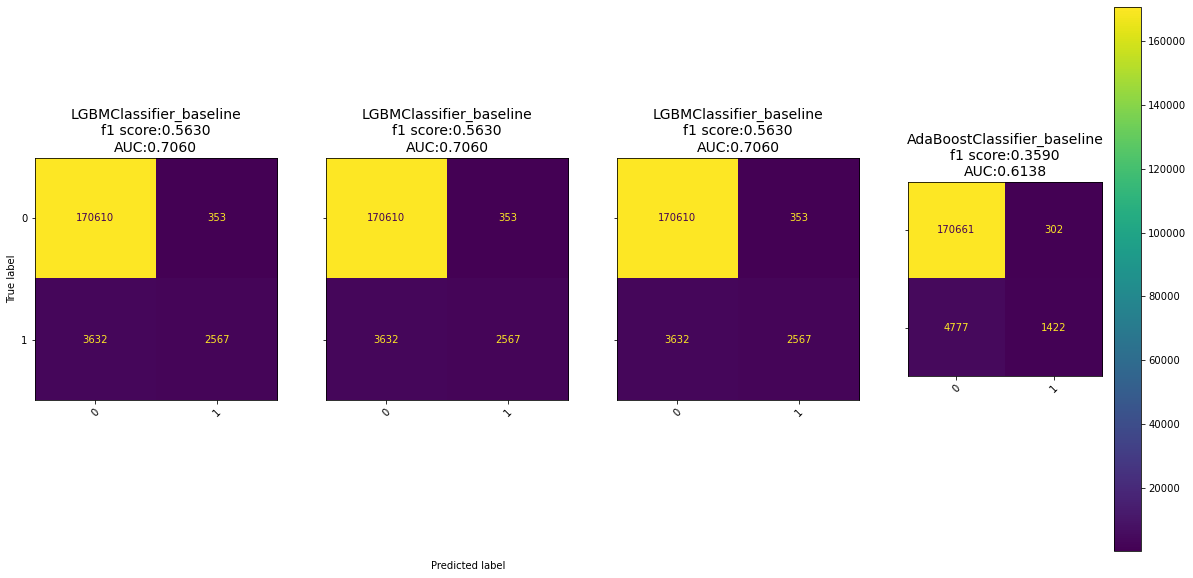

In [144]:
ml_models.display_all_confusion_matrices(y_test)

In [145]:
for i in ml_models_list:
    ml_models.model_performance(i, X_train_ros, X_test, y_train_ros, y_test, "RandomOverSampler")
    ml_models.model_performance(i, X_train_rus, X_test, y_train_rus, y_test, "RandomUnderSampler")
    ml_models.model_performance(i, X_train_smote, X_test, y_train_smote, y_test, "SMOTE")
    ml_models.model_performance(i, X_train_adasyn, X_test, y_train_adasyn, y_test, "ADASYN")

***** LGBMClassifier_RandomOverSampler DONE *****
***** LGBMClassifier_RandomUnderSampler DONE *****
***** LGBMClassifier_SMOTE DONE *****
***** LGBMClassifier_ADASYN DONE *****
***** AdaBoostClassifier_RandomOverSampler DONE *****
***** AdaBoostClassifier_RandomUnderSampler DONE *****
***** AdaBoostClassifier_SMOTE DONE *****
***** AdaBoostClassifier_ADASYN DONE *****
***** GradientBoostingClassifier_RandomOverSampler DONE *****
***** GradientBoostingClassifier_RandomUnderSampler DONE *****
***** GradientBoostingClassifier_SMOTE DONE *****
***** GradientBoostingClassifier_ADASYN DONE *****
Learning rate set to 0.178669
0:	learn: 0.6273605	total: 96.4ms	remaining: 1m 36s
1:	learn: 0.5732681	total: 185ms	remaining: 1m 32s
2:	learn: 0.5436952	total: 276ms	remaining: 1m 31s
3:	learn: 0.5205655	total: 362ms	remaining: 1m 30s
4:	learn: 0.5048314	total: 453ms	remaining: 1m 30s
5:	learn: 0.4930875	total: 541ms	remaining: 1m 29s
6:	learn: 0.4831061	total: 627ms	remaining: 1m 28s
7:	learn: 0.47

145:	learn: 0.3079518	total: 12.3s	remaining: 1m 12s
146:	learn: 0.3075639	total: 12.4s	remaining: 1m 11s
147:	learn: 0.3072177	total: 12.5s	remaining: 1m 11s
148:	learn: 0.3067370	total: 12.6s	remaining: 1m 11s
149:	learn: 0.3063965	total: 12.6s	remaining: 1m 11s
150:	learn: 0.3058201	total: 12.7s	remaining: 1m 11s
151:	learn: 0.3054097	total: 12.8s	remaining: 1m 11s
152:	learn: 0.3048421	total: 12.9s	remaining: 1m 11s
153:	learn: 0.3045008	total: 13s	remaining: 1m 11s
154:	learn: 0.3037812	total: 13.1s	remaining: 1m 11s
155:	learn: 0.3033672	total: 13.1s	remaining: 1m 11s
156:	learn: 0.3026027	total: 13.2s	remaining: 1m 11s
157:	learn: 0.3023091	total: 13.3s	remaining: 1m 10s
158:	learn: 0.3018401	total: 13.4s	remaining: 1m 10s
159:	learn: 0.3014743	total: 13.5s	remaining: 1m 10s
160:	learn: 0.3010497	total: 13.6s	remaining: 1m 10s
161:	learn: 0.3003770	total: 13.7s	remaining: 1m 10s
162:	learn: 0.2999496	total: 13.7s	remaining: 1m 10s
163:	learn: 0.2993541	total: 13.8s	remaining: 1m

304:	learn: 0.2483457	total: 25.2s	remaining: 57.3s
305:	learn: 0.2481354	total: 25.2s	remaining: 57.3s
306:	learn: 0.2478331	total: 25.3s	remaining: 57.2s
307:	learn: 0.2476922	total: 25.4s	remaining: 57.1s
308:	learn: 0.2474237	total: 25.5s	remaining: 57s
309:	learn: 0.2472116	total: 25.6s	remaining: 56.9s
310:	learn: 0.2468628	total: 25.6s	remaining: 56.8s
311:	learn: 0.2465970	total: 25.7s	remaining: 56.7s
312:	learn: 0.2463072	total: 25.8s	remaining: 56.6s
313:	learn: 0.2461821	total: 25.9s	remaining: 56.5s
314:	learn: 0.2459229	total: 25.9s	remaining: 56.4s
315:	learn: 0.2455566	total: 26s	remaining: 56.3s
316:	learn: 0.2452608	total: 26.1s	remaining: 56.2s
317:	learn: 0.2450343	total: 26.2s	remaining: 56.2s
318:	learn: 0.2446858	total: 26.3s	remaining: 56.1s
319:	learn: 0.2443359	total: 26.4s	remaining: 56s
320:	learn: 0.2441137	total: 26.5s	remaining: 56s
321:	learn: 0.2438443	total: 26.5s	remaining: 55.9s
322:	learn: 0.2435477	total: 26.6s	remaining: 55.8s
323:	learn: 0.243362

463:	learn: 0.2116147	total: 38.1s	remaining: 44s
464:	learn: 0.2114504	total: 38.2s	remaining: 43.9s
465:	learn: 0.2111550	total: 38.2s	remaining: 43.8s
466:	learn: 0.2109979	total: 38.3s	remaining: 43.7s
467:	learn: 0.2107924	total: 38.4s	remaining: 43.6s
468:	learn: 0.2105415	total: 38.5s	remaining: 43.5s
469:	learn: 0.2103473	total: 38.5s	remaining: 43.4s
470:	learn: 0.2101465	total: 38.6s	remaining: 43.4s
471:	learn: 0.2099529	total: 38.7s	remaining: 43.3s
472:	learn: 0.2098348	total: 38.7s	remaining: 43.2s
473:	learn: 0.2096352	total: 38.8s	remaining: 43.1s
474:	learn: 0.2094385	total: 38.9s	remaining: 43s
475:	learn: 0.2091798	total: 39s	remaining: 42.9s
476:	learn: 0.2089466	total: 39.1s	remaining: 42.8s
477:	learn: 0.2087062	total: 39.1s	remaining: 42.7s
478:	learn: 0.2084535	total: 39.2s	remaining: 42.7s
479:	learn: 0.2082109	total: 39.3s	remaining: 42.6s
480:	learn: 0.2079243	total: 39.4s	remaining: 42.5s
481:	learn: 0.2077169	total: 39.5s	remaining: 42.4s
482:	learn: 0.2074

622:	learn: 0.1838810	total: 50.2s	remaining: 30.4s
623:	learn: 0.1837447	total: 50.2s	remaining: 30.3s
624:	learn: 0.1836308	total: 50.3s	remaining: 30.2s
625:	learn: 0.1834476	total: 50.4s	remaining: 30.1s
626:	learn: 0.1833524	total: 50.5s	remaining: 30s
627:	learn: 0.1832199	total: 50.5s	remaining: 29.9s
628:	learn: 0.1830598	total: 50.6s	remaining: 29.9s
629:	learn: 0.1828321	total: 50.7s	remaining: 29.8s
630:	learn: 0.1827614	total: 50.8s	remaining: 29.7s
631:	learn: 0.1826515	total: 50.9s	remaining: 29.6s
632:	learn: 0.1825817	total: 50.9s	remaining: 29.5s
633:	learn: 0.1824233	total: 51s	remaining: 29.4s
634:	learn: 0.1823213	total: 51.1s	remaining: 29.4s
635:	learn: 0.1821942	total: 51.2s	remaining: 29.3s
636:	learn: 0.1820889	total: 51.2s	remaining: 29.2s
637:	learn: 0.1819343	total: 51.3s	remaining: 29.1s
638:	learn: 0.1818243	total: 51.4s	remaining: 29s
639:	learn: 0.1815927	total: 51.5s	remaining: 28.9s
640:	learn: 0.1814155	total: 51.5s	remaining: 28.9s
641:	learn: 0.1812

783:	learn: 0.1621649	total: 1m 2s	remaining: 17.2s
784:	learn: 0.1621219	total: 1m 2s	remaining: 17.1s
785:	learn: 0.1620389	total: 1m 2s	remaining: 17.1s
786:	learn: 0.1619455	total: 1m 2s	remaining: 17s
787:	learn: 0.1618807	total: 1m 2s	remaining: 16.9s
788:	learn: 0.1617255	total: 1m 2s	remaining: 16.8s
789:	learn: 0.1615979	total: 1m 2s	remaining: 16.7s
790:	learn: 0.1614742	total: 1m 3s	remaining: 16.7s
791:	learn: 0.1613317	total: 1m 3s	remaining: 16.6s
792:	learn: 0.1611775	total: 1m 3s	remaining: 16.5s
793:	learn: 0.1610312	total: 1m 3s	remaining: 16.4s
794:	learn: 0.1609067	total: 1m 3s	remaining: 16.3s
795:	learn: 0.1607945	total: 1m 3s	remaining: 16.3s
796:	learn: 0.1606240	total: 1m 3s	remaining: 16.2s
797:	learn: 0.1605286	total: 1m 3s	remaining: 16.1s
798:	learn: 0.1604115	total: 1m 3s	remaining: 16s
799:	learn: 0.1603053	total: 1m 3s	remaining: 15.9s
800:	learn: 0.1600867	total: 1m 3s	remaining: 15.9s
801:	learn: 0.1599299	total: 1m 3s	remaining: 15.8s
802:	learn: 0.15

942:	learn: 0.1447276	total: 1m 16s	remaining: 4.6s
943:	learn: 0.1446475	total: 1m 16s	remaining: 4.51s
944:	learn: 0.1445606	total: 1m 16s	remaining: 4.43s
945:	learn: 0.1445082	total: 1m 16s	remaining: 4.35s
946:	learn: 0.1443160	total: 1m 16s	remaining: 4.27s
947:	learn: 0.1441932	total: 1m 16s	remaining: 4.19s
948:	learn: 0.1440675	total: 1m 16s	remaining: 4.11s
949:	learn: 0.1439491	total: 1m 16s	remaining: 4.03s
950:	learn: 0.1438630	total: 1m 16s	remaining: 3.95s
951:	learn: 0.1437459	total: 1m 16s	remaining: 3.87s
952:	learn: 0.1436505	total: 1m 16s	remaining: 3.79s
953:	learn: 0.1434764	total: 1m 16s	remaining: 3.71s
954:	learn: 0.1433704	total: 1m 17s	remaining: 3.63s
955:	learn: 0.1432075	total: 1m 17s	remaining: 3.55s
956:	learn: 0.1430625	total: 1m 17s	remaining: 3.47s
957:	learn: 0.1429709	total: 1m 17s	remaining: 3.39s
958:	learn: 0.1428925	total: 1m 17s	remaining: 3.31s
959:	learn: 0.1427711	total: 1m 17s	remaining: 3.23s
960:	learn: 0.1426217	total: 1m 17s	remaining: 

111:	learn: 0.4172451	total: 1.39s	remaining: 11s
112:	learn: 0.4169121	total: 1.4s	remaining: 11s
113:	learn: 0.4165647	total: 1.41s	remaining: 11s
114:	learn: 0.4162714	total: 1.42s	remaining: 10.9s
115:	learn: 0.4159260	total: 1.43s	remaining: 10.9s
116:	learn: 0.4154567	total: 1.45s	remaining: 10.9s
117:	learn: 0.4151551	total: 1.46s	remaining: 10.9s
118:	learn: 0.4148060	total: 1.47s	remaining: 10.9s
119:	learn: 0.4146199	total: 1.48s	remaining: 10.8s
120:	learn: 0.4141343	total: 1.49s	remaining: 10.8s
121:	learn: 0.4137391	total: 1.5s	remaining: 10.8s
122:	learn: 0.4133944	total: 1.52s	remaining: 10.8s
123:	learn: 0.4130311	total: 1.53s	remaining: 10.8s
124:	learn: 0.4126447	total: 1.54s	remaining: 10.8s
125:	learn: 0.4123337	total: 1.56s	remaining: 10.8s
126:	learn: 0.4120515	total: 1.57s	remaining: 10.8s
127:	learn: 0.4116701	total: 1.59s	remaining: 10.8s
128:	learn: 0.4111745	total: 1.6s	remaining: 10.8s
129:	learn: 0.4107478	total: 1.61s	remaining: 10.8s
130:	learn: 0.4105483

272:	learn: 0.3691623	total: 3.39s	remaining: 9.03s
273:	learn: 0.3689754	total: 3.4s	remaining: 9.02s
274:	learn: 0.3687949	total: 3.42s	remaining: 9.01s
275:	learn: 0.3685913	total: 3.43s	remaining: 9s
276:	learn: 0.3683064	total: 3.44s	remaining: 8.99s
277:	learn: 0.3680473	total: 3.46s	remaining: 8.98s
278:	learn: 0.3677969	total: 3.47s	remaining: 8.97s
279:	learn: 0.3676281	total: 3.48s	remaining: 8.96s
280:	learn: 0.3674005	total: 3.5s	remaining: 8.95s
281:	learn: 0.3670274	total: 3.51s	remaining: 8.93s
282:	learn: 0.3667843	total: 3.52s	remaining: 8.92s
283:	learn: 0.3665889	total: 3.53s	remaining: 8.9s
284:	learn: 0.3663162	total: 3.54s	remaining: 8.89s
285:	learn: 0.3660749	total: 3.55s	remaining: 8.87s
286:	learn: 0.3657694	total: 3.56s	remaining: 8.85s
287:	learn: 0.3655954	total: 3.57s	remaining: 8.84s
288:	learn: 0.3653453	total: 3.59s	remaining: 8.82s
289:	learn: 0.3650647	total: 3.6s	remaining: 8.81s
290:	learn: 0.3647373	total: 3.61s	remaining: 8.79s
291:	learn: 0.36449

436:	learn: 0.3337882	total: 5.37s	remaining: 6.91s
437:	learn: 0.3335948	total: 5.38s	remaining: 6.9s
438:	learn: 0.3334430	total: 5.39s	remaining: 6.89s
439:	learn: 0.3333294	total: 5.4s	remaining: 6.87s
440:	learn: 0.3332114	total: 5.41s	remaining: 6.86s
441:	learn: 0.3330125	total: 5.42s	remaining: 6.84s
442:	learn: 0.3327594	total: 5.43s	remaining: 6.83s
443:	learn: 0.3325683	total: 5.44s	remaining: 6.82s
444:	learn: 0.3324198	total: 5.45s	remaining: 6.8s
445:	learn: 0.3322527	total: 5.46s	remaining: 6.79s
446:	learn: 0.3320694	total: 5.48s	remaining: 6.78s
447:	learn: 0.3318125	total: 5.49s	remaining: 6.76s
448:	learn: 0.3316282	total: 5.5s	remaining: 6.75s
449:	learn: 0.3314991	total: 5.51s	remaining: 6.73s
450:	learn: 0.3312828	total: 5.52s	remaining: 6.72s
451:	learn: 0.3311272	total: 5.53s	remaining: 6.71s
452:	learn: 0.3309848	total: 5.54s	remaining: 6.69s
453:	learn: 0.3307518	total: 5.55s	remaining: 6.68s
454:	learn: 0.3305245	total: 5.57s	remaining: 6.67s
455:	learn: 0.33

612:	learn: 0.3061928	total: 7.54s	remaining: 4.76s
613:	learn: 0.3061130	total: 7.55s	remaining: 4.74s
614:	learn: 0.3059660	total: 7.56s	remaining: 4.73s
615:	learn: 0.3057879	total: 7.57s	remaining: 4.72s
616:	learn: 0.3056716	total: 7.58s	remaining: 4.71s
617:	learn: 0.3055119	total: 7.59s	remaining: 4.69s
618:	learn: 0.3054054	total: 7.6s	remaining: 4.68s
619:	learn: 0.3052372	total: 7.61s	remaining: 4.67s
620:	learn: 0.3051039	total: 7.62s	remaining: 4.65s
621:	learn: 0.3049134	total: 7.63s	remaining: 4.64s
622:	learn: 0.3047441	total: 7.65s	remaining: 4.63s
623:	learn: 0.3046228	total: 7.66s	remaining: 4.61s
624:	learn: 0.3044918	total: 7.67s	remaining: 4.6s
625:	learn: 0.3043399	total: 7.68s	remaining: 4.59s
626:	learn: 0.3042289	total: 7.69s	remaining: 4.57s
627:	learn: 0.3041230	total: 7.7s	remaining: 4.56s
628:	learn: 0.3039920	total: 7.71s	remaining: 4.55s
629:	learn: 0.3039474	total: 7.72s	remaining: 4.53s
630:	learn: 0.3038313	total: 7.73s	remaining: 4.52s
631:	learn: 0.3

775:	learn: 0.2862972	total: 9.5s	remaining: 2.74s
776:	learn: 0.2862140	total: 9.51s	remaining: 2.73s
777:	learn: 0.2861076	total: 9.52s	remaining: 2.72s
778:	learn: 0.2860163	total: 9.53s	remaining: 2.7s
779:	learn: 0.2859107	total: 9.54s	remaining: 2.69s
780:	learn: 0.2858073	total: 9.55s	remaining: 2.68s
781:	learn: 0.2856788	total: 9.57s	remaining: 2.67s
782:	learn: 0.2855405	total: 9.58s	remaining: 2.65s
783:	learn: 0.2853888	total: 9.59s	remaining: 2.64s
784:	learn: 0.2853156	total: 9.6s	remaining: 2.63s
785:	learn: 0.2851969	total: 9.61s	remaining: 2.62s
786:	learn: 0.2850575	total: 9.62s	remaining: 2.6s
787:	learn: 0.2849638	total: 9.63s	remaining: 2.59s
788:	learn: 0.2848027	total: 9.64s	remaining: 2.58s
789:	learn: 0.2846327	total: 9.66s	remaining: 2.57s
790:	learn: 0.2845179	total: 9.67s	remaining: 2.55s
791:	learn: 0.2844037	total: 9.68s	remaining: 2.54s
792:	learn: 0.2842698	total: 9.69s	remaining: 2.53s
793:	learn: 0.2841967	total: 9.7s	remaining: 2.52s
794:	learn: 0.284

944:	learn: 0.2683590	total: 11.5s	remaining: 669ms
945:	learn: 0.2682527	total: 11.5s	remaining: 657ms
946:	learn: 0.2681173	total: 11.5s	remaining: 645ms
947:	learn: 0.2680814	total: 11.5s	remaining: 632ms
948:	learn: 0.2679846	total: 11.5s	remaining: 620ms
949:	learn: 0.2678458	total: 11.6s	remaining: 608ms
950:	learn: 0.2677452	total: 11.6s	remaining: 596ms
951:	learn: 0.2676569	total: 11.6s	remaining: 584ms
952:	learn: 0.2675180	total: 11.6s	remaining: 572ms
953:	learn: 0.2674139	total: 11.6s	remaining: 559ms
954:	learn: 0.2672522	total: 11.6s	remaining: 547ms
955:	learn: 0.2671655	total: 11.6s	remaining: 535ms
956:	learn: 0.2670860	total: 11.6s	remaining: 523ms
957:	learn: 0.2669922	total: 11.7s	remaining: 511ms
958:	learn: 0.2668800	total: 11.7s	remaining: 499ms
959:	learn: 0.2667682	total: 11.7s	remaining: 486ms
960:	learn: 0.2667070	total: 11.7s	remaining: 474ms
961:	learn: 0.2666363	total: 11.7s	remaining: 462ms
962:	learn: 0.2666319	total: 11.7s	remaining: 450ms
963:	learn: 

103:	learn: 0.0843843	total: 9.02s	remaining: 1m 17s
104:	learn: 0.0840863	total: 9.12s	remaining: 1m 17s
105:	learn: 0.0833828	total: 9.2s	remaining: 1m 17s
106:	learn: 0.0830899	total: 9.29s	remaining: 1m 17s
107:	learn: 0.0828331	total: 9.37s	remaining: 1m 17s
108:	learn: 0.0825812	total: 9.46s	remaining: 1m 17s
109:	learn: 0.0824108	total: 9.54s	remaining: 1m 17s
110:	learn: 0.0821619	total: 9.62s	remaining: 1m 17s
111:	learn: 0.0817433	total: 9.71s	remaining: 1m 16s
112:	learn: 0.0814629	total: 9.79s	remaining: 1m 16s
113:	learn: 0.0811121	total: 9.88s	remaining: 1m 16s
114:	learn: 0.0807646	total: 9.97s	remaining: 1m 16s
115:	learn: 0.0805654	total: 10s	remaining: 1m 16s
116:	learn: 0.0803760	total: 10.1s	remaining: 1m 16s
117:	learn: 0.0802105	total: 10.2s	remaining: 1m 16s
118:	learn: 0.0799671	total: 10.3s	remaining: 1m 16s
119:	learn: 0.0798122	total: 10.4s	remaining: 1m 15s
120:	learn: 0.0794880	total: 10.4s	remaining: 1m 15s
121:	learn: 0.0793276	total: 10.5s	remaining: 1m 

261:	learn: 0.0570614	total: 22.1s	remaining: 1m 2s
262:	learn: 0.0569683	total: 22.2s	remaining: 1m 2s
263:	learn: 0.0568787	total: 22.2s	remaining: 1m 2s
264:	learn: 0.0568164	total: 22.3s	remaining: 1m 1s
265:	learn: 0.0567466	total: 22.4s	remaining: 1m 1s
266:	learn: 0.0566962	total: 22.5s	remaining: 1m 1s
267:	learn: 0.0565932	total: 22.6s	remaining: 1m 1s
268:	learn: 0.0564952	total: 22.6s	remaining: 1m 1s
269:	learn: 0.0563423	total: 22.7s	remaining: 1m 1s
270:	learn: 0.0562500	total: 22.8s	remaining: 1m 1s
271:	learn: 0.0561103	total: 22.9s	remaining: 1m 1s
272:	learn: 0.0559799	total: 23s	remaining: 1m 1s
273:	learn: 0.0559098	total: 23.1s	remaining: 1m 1s
274:	learn: 0.0556440	total: 23.1s	remaining: 1m 1s
275:	learn: 0.0555871	total: 23.2s	remaining: 1m
276:	learn: 0.0554620	total: 23.3s	remaining: 1m
277:	learn: 0.0554037	total: 23.4s	remaining: 1m
278:	learn: 0.0553582	total: 23.5s	remaining: 1m
279:	learn: 0.0552654	total: 23.5s	remaining: 1m
280:	learn: 0.0551730	total: 

423:	learn: 0.0456266	total: 35.3s	remaining: 48s
424:	learn: 0.0455903	total: 35.4s	remaining: 47.9s
425:	learn: 0.0455333	total: 35.5s	remaining: 47.8s
426:	learn: 0.0454805	total: 35.6s	remaining: 47.7s
427:	learn: 0.0454084	total: 35.6s	remaining: 47.6s
428:	learn: 0.0453821	total: 35.7s	remaining: 47.5s
429:	learn: 0.0453252	total: 35.8s	remaining: 47.5s
430:	learn: 0.0452758	total: 35.9s	remaining: 47.4s
431:	learn: 0.0452471	total: 36s	remaining: 47.3s
432:	learn: 0.0451935	total: 36.1s	remaining: 47.2s
433:	learn: 0.0451176	total: 36.2s	remaining: 47.1s
434:	learn: 0.0450834	total: 36.2s	remaining: 47.1s
435:	learn: 0.0450751	total: 36.3s	remaining: 47s
436:	learn: 0.0450254	total: 36.4s	remaining: 46.9s
437:	learn: 0.0449944	total: 36.5s	remaining: 46.8s
438:	learn: 0.0449810	total: 36.5s	remaining: 46.7s
439:	learn: 0.0449459	total: 36.6s	remaining: 46.6s
440:	learn: 0.0449102	total: 36.7s	remaining: 46.5s
441:	learn: 0.0448937	total: 36.8s	remaining: 46.4s
442:	learn: 0.0448

582:	learn: 0.0398311	total: 48.3s	remaining: 34.5s
583:	learn: 0.0398161	total: 48.3s	remaining: 34.4s
584:	learn: 0.0397826	total: 48.4s	remaining: 34.3s
585:	learn: 0.0396965	total: 48.5s	remaining: 34.3s
586:	learn: 0.0396634	total: 48.6s	remaining: 34.2s
587:	learn: 0.0396247	total: 48.6s	remaining: 34.1s
588:	learn: 0.0396045	total: 48.7s	remaining: 34s
589:	learn: 0.0395462	total: 48.8s	remaining: 33.9s
590:	learn: 0.0394958	total: 48.9s	remaining: 33.9s
591:	learn: 0.0394633	total: 49s	remaining: 33.8s
592:	learn: 0.0394433	total: 49.1s	remaining: 33.7s
593:	learn: 0.0394200	total: 49.1s	remaining: 33.6s
594:	learn: 0.0393876	total: 49.2s	remaining: 33.5s
595:	learn: 0.0393706	total: 49.3s	remaining: 33.4s
596:	learn: 0.0393396	total: 49.4s	remaining: 33.3s
597:	learn: 0.0393269	total: 49.5s	remaining: 33.3s
598:	learn: 0.0393032	total: 49.5s	remaining: 33.2s
599:	learn: 0.0392811	total: 49.6s	remaining: 33.1s
600:	learn: 0.0392430	total: 49.7s	remaining: 33s
601:	learn: 0.0391

742:	learn: 0.0358636	total: 1m 1s	remaining: 21.3s
743:	learn: 0.0358331	total: 1m 1s	remaining: 21.2s
744:	learn: 0.0357870	total: 1m 1s	remaining: 21.1s
745:	learn: 0.0357620	total: 1m 1s	remaining: 21s
746:	learn: 0.0357505	total: 1m 1s	remaining: 20.9s
747:	learn: 0.0357416	total: 1m 1s	remaining: 20.9s
748:	learn: 0.0357265	total: 1m 1s	remaining: 20.8s
749:	learn: 0.0356840	total: 1m 2s	remaining: 20.7s
750:	learn: 0.0356612	total: 1m 2s	remaining: 20.6s
751:	learn: 0.0356421	total: 1m 2s	remaining: 20.5s
752:	learn: 0.0355892	total: 1m 2s	remaining: 20.5s
753:	learn: 0.0355892	total: 1m 2s	remaining: 20.4s
754:	learn: 0.0355658	total: 1m 2s	remaining: 20.3s
755:	learn: 0.0355613	total: 1m 2s	remaining: 20.2s
756:	learn: 0.0355220	total: 1m 2s	remaining: 20.1s
757:	learn: 0.0355006	total: 1m 2s	remaining: 20s
758:	learn: 0.0354900	total: 1m 2s	remaining: 20s
759:	learn: 0.0354805	total: 1m 2s	remaining: 19.9s
760:	learn: 0.0354781	total: 1m 2s	remaining: 19.8s
761:	learn: 0.0354

900:	learn: 0.0331187	total: 1m 15s	remaining: 8.27s
901:	learn: 0.0331186	total: 1m 15s	remaining: 8.19s
902:	learn: 0.0331064	total: 1m 15s	remaining: 8.1s
903:	learn: 0.0330838	total: 1m 15s	remaining: 8.02s
904:	learn: 0.0330654	total: 1m 15s	remaining: 7.94s
905:	learn: 0.0330470	total: 1m 15s	remaining: 7.85s
906:	learn: 0.0330362	total: 1m 15s	remaining: 7.77s
907:	learn: 0.0330052	total: 1m 15s	remaining: 7.68s
908:	learn: 0.0329742	total: 1m 15s	remaining: 7.6s
909:	learn: 0.0329655	total: 1m 16s	remaining: 7.52s
910:	learn: 0.0329509	total: 1m 16s	remaining: 7.43s
911:	learn: 0.0329373	total: 1m 16s	remaining: 7.35s
912:	learn: 0.0329237	total: 1m 16s	remaining: 7.27s
913:	learn: 0.0328972	total: 1m 16s	remaining: 7.18s
914:	learn: 0.0328910	total: 1m 16s	remaining: 7.1s
915:	learn: 0.0328802	total: 1m 16s	remaining: 7.02s
916:	learn: 0.0328330	total: 1m 16s	remaining: 6.93s
917:	learn: 0.0328210	total: 1m 16s	remaining: 6.85s
918:	learn: 0.0328073	total: 1m 16s	remaining: 6.

56:	learn: 0.1058747	total: 4.93s	remaining: 1m 21s
57:	learn: 0.1041342	total: 5.03s	remaining: 1m 21s
58:	learn: 0.1035833	total: 5.12s	remaining: 1m 21s
59:	learn: 0.1004535	total: 5.21s	remaining: 1m 21s
60:	learn: 0.1000759	total: 5.28s	remaining: 1m 21s
61:	learn: 0.0996628	total: 5.36s	remaining: 1m 21s
62:	learn: 0.0992494	total: 5.45s	remaining: 1m 21s
63:	learn: 0.0975306	total: 5.55s	remaining: 1m 21s
64:	learn: 0.0971224	total: 5.62s	remaining: 1m 20s
65:	learn: 0.0968462	total: 5.7s	remaining: 1m 20s
66:	learn: 0.0962867	total: 5.77s	remaining: 1m 20s
67:	learn: 0.0959653	total: 5.85s	remaining: 1m 20s
68:	learn: 0.0948921	total: 5.93s	remaining: 1m 20s
69:	learn: 0.0944812	total: 6.01s	remaining: 1m 19s
70:	learn: 0.0941676	total: 6.09s	remaining: 1m 19s
71:	learn: 0.0938408	total: 6.18s	remaining: 1m 19s
72:	learn: 0.0933452	total: 6.25s	remaining: 1m 19s
73:	learn: 0.0930233	total: 6.33s	remaining: 1m 19s
74:	learn: 0.0927286	total: 6.42s	remaining: 1m 19s
75:	learn: 0.

214:	learn: 0.0614021	total: 18.4s	remaining: 1m 7s
215:	learn: 0.0613114	total: 18.5s	remaining: 1m 7s
216:	learn: 0.0612403	total: 18.6s	remaining: 1m 7s
217:	learn: 0.0611295	total: 18.7s	remaining: 1m 7s
218:	learn: 0.0610697	total: 18.8s	remaining: 1m 6s
219:	learn: 0.0608579	total: 18.9s	remaining: 1m 6s
220:	learn: 0.0607658	total: 19s	remaining: 1m 6s
221:	learn: 0.0606506	total: 19.1s	remaining: 1m 6s
222:	learn: 0.0605168	total: 19.1s	remaining: 1m 6s
223:	learn: 0.0604112	total: 19.2s	remaining: 1m 6s
224:	learn: 0.0601712	total: 19.4s	remaining: 1m 6s
225:	learn: 0.0599808	total: 19.5s	remaining: 1m 6s
226:	learn: 0.0599035	total: 19.5s	remaining: 1m 6s
227:	learn: 0.0598536	total: 19.6s	remaining: 1m 6s
228:	learn: 0.0596972	total: 19.7s	remaining: 1m 6s
229:	learn: 0.0596301	total: 19.8s	remaining: 1m 6s
230:	learn: 0.0595324	total: 19.9s	remaining: 1m 6s
231:	learn: 0.0594558	total: 20s	remaining: 1m 6s
232:	learn: 0.0591761	total: 20.1s	remaining: 1m 6s
233:	learn: 0.05

374:	learn: 0.0490791	total: 32.1s	remaining: 53.5s
375:	learn: 0.0489390	total: 32.2s	remaining: 53.4s
376:	learn: 0.0488860	total: 32.3s	remaining: 53.3s
377:	learn: 0.0488452	total: 32.3s	remaining: 53.2s
378:	learn: 0.0488121	total: 32.4s	remaining: 53.1s
379:	learn: 0.0487860	total: 32.5s	remaining: 53s
380:	learn: 0.0487090	total: 32.6s	remaining: 53s
381:	learn: 0.0486751	total: 32.7s	remaining: 52.8s
382:	learn: 0.0486276	total: 32.7s	remaining: 52.7s
383:	learn: 0.0485933	total: 32.8s	remaining: 52.7s
384:	learn: 0.0485315	total: 32.9s	remaining: 52.6s
385:	learn: 0.0484695	total: 33s	remaining: 52.5s
386:	learn: 0.0484293	total: 33.1s	remaining: 52.4s
387:	learn: 0.0483914	total: 33.1s	remaining: 52.3s
388:	learn: 0.0483421	total: 33.2s	remaining: 52.2s
389:	learn: 0.0482878	total: 33.3s	remaining: 52.1s
390:	learn: 0.0482585	total: 33.4s	remaining: 52s
391:	learn: 0.0482156	total: 33.5s	remaining: 51.9s
392:	learn: 0.0481637	total: 33.6s	remaining: 51.8s
393:	learn: 0.048110

533:	learn: 0.0416818	total: 45.5s	remaining: 39.7s
534:	learn: 0.0416574	total: 45.6s	remaining: 39.6s
535:	learn: 0.0416095	total: 45.7s	remaining: 39.5s
536:	learn: 0.0416010	total: 45.7s	remaining: 39.4s
537:	learn: 0.0415652	total: 45.8s	remaining: 39.3s
538:	learn: 0.0415380	total: 45.9s	remaining: 39.3s
539:	learn: 0.0414910	total: 46s	remaining: 39.2s
540:	learn: 0.0414591	total: 46.1s	remaining: 39.1s
541:	learn: 0.0413598	total: 46.2s	remaining: 39s
542:	learn: 0.0413218	total: 46.3s	remaining: 38.9s
543:	learn: 0.0412860	total: 46.4s	remaining: 38.9s
544:	learn: 0.0412458	total: 46.4s	remaining: 38.8s
545:	learn: 0.0412202	total: 46.5s	remaining: 38.7s
546:	learn: 0.0411883	total: 46.6s	remaining: 38.6s
547:	learn: 0.0411612	total: 46.7s	remaining: 38.5s
548:	learn: 0.0411193	total: 46.8s	remaining: 38.4s
549:	learn: 0.0410945	total: 46.9s	remaining: 38.4s
550:	learn: 0.0410862	total: 46.9s	remaining: 38.2s
551:	learn: 0.0410591	total: 47s	remaining: 38.2s
552:	learn: 0.0410

694:	learn: 0.0371925	total: 58.7s	remaining: 25.8s
695:	learn: 0.0371834	total: 58.8s	remaining: 25.7s
696:	learn: 0.0371834	total: 58.8s	remaining: 25.6s
697:	learn: 0.0371821	total: 58.9s	remaining: 25.5s
698:	learn: 0.0371690	total: 59s	remaining: 25.4s
699:	learn: 0.0371604	total: 59s	remaining: 25.3s
700:	learn: 0.0371288	total: 59.1s	remaining: 25.2s
701:	learn: 0.0371088	total: 59.2s	remaining: 25.1s
702:	learn: 0.0370874	total: 59.3s	remaining: 25s
703:	learn: 0.0370635	total: 59.4s	remaining: 25s
704:	learn: 0.0370541	total: 59.4s	remaining: 24.9s
705:	learn: 0.0370309	total: 59.5s	remaining: 24.8s
706:	learn: 0.0370188	total: 59.6s	remaining: 24.7s
707:	learn: 0.0369946	total: 59.7s	remaining: 24.6s
708:	learn: 0.0369624	total: 59.7s	remaining: 24.5s
709:	learn: 0.0369389	total: 59.8s	remaining: 24.4s
710:	learn: 0.0369266	total: 59.9s	remaining: 24.3s
711:	learn: 0.0368941	total: 60s	remaining: 24.3s
712:	learn: 0.0368668	total: 1m	remaining: 24.2s
713:	learn: 0.0368358	tot

853:	learn: 0.0337430	total: 1m 11s	remaining: 12.2s
854:	learn: 0.0337299	total: 1m 11s	remaining: 12.1s
855:	learn: 0.0337210	total: 1m 11s	remaining: 12s
856:	learn: 0.0336899	total: 1m 11s	remaining: 11.9s
857:	learn: 0.0336749	total: 1m 11s	remaining: 11.9s
858:	learn: 0.0336647	total: 1m 11s	remaining: 11.8s
859:	learn: 0.0336540	total: 1m 11s	remaining: 11.7s
860:	learn: 0.0336467	total: 1m 11s	remaining: 11.6s
861:	learn: 0.0336428	total: 1m 11s	remaining: 11.5s
862:	learn: 0.0336338	total: 1m 12s	remaining: 11.4s
863:	learn: 0.0336008	total: 1m 12s	remaining: 11.3s
864:	learn: 0.0335605	total: 1m 12s	remaining: 11.3s
865:	learn: 0.0335280	total: 1m 12s	remaining: 11.2s
866:	learn: 0.0335095	total: 1m 12s	remaining: 11.1s
867:	learn: 0.0335075	total: 1m 12s	remaining: 11s
868:	learn: 0.0334885	total: 1m 12s	remaining: 10.9s
869:	learn: 0.0334871	total: 1m 12s	remaining: 10.8s
870:	learn: 0.0334870	total: 1m 12s	remaining: 10.8s
871:	learn: 0.0334615	total: 1m 12s	remaining: 10.

***** XGBClassifier_RandomUnderSampler DONE *****
[23:37:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
***** XGBClassifier_SMOTE DONE *****
[23:38:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
***** XGBClassifier_ADASYN DONE *****


In [148]:
ml_model_performances = ml_models.all_performances.sort_values(by=['f1_score','AUC'], ascending=False)
ml_model_performances

model_name  precision  recall  \
19                       CatBoostClassifier_SMOTE      0.885   0.543   
20                      CatBoostClassifier_ADASYN      0.894   0.533   
3                     CatBoostClassifier_baseline      0.927   0.497   
4                          XGBClassifier_baseline      0.910   0.478   
23                            XGBClassifier_SMOTE      0.791   0.491   
24                           XGBClassifier_ADASYN      0.812   0.466   
0                         LGBMClassifier_baseline      0.879   0.414   
7                            LGBMClassifier_SMOTE      0.648   0.465   
17           CatBoostClassifier_RandomOverSampler      0.399   0.820   
8                           LGBMClassifier_ADASYN      0.663   0.403   
2             GradientBoostingClassifier_baseline      0.873   0.291   
21                XGBClassifier_RandomOverSampler      0.275   0.817   
15               GradientBoostingClassifier_SMOTE      0.277   0.573   
16              GradientBoostingClassifier_ADASYN      0.279   0.534   
1                     AdaBoostClassifier_baseline      0.825   0.229   
18          CatBoostClassifier_RandomUnderSampler      0.213   0.838   
22               XGBClassifier_RandomUnderSampler      0.210   0.847   
5                LGBMClassifier_RandomOverSampler      0.208   0.815   
6               LGBMClassifier_RandomUnderSampler      0.190   0.816   
13   GradientBoostingClassifier_RandomOverSampler      0.160   0.778   
11                       AdaBoostClassifier_SMOTE      0.164   0.623   
14  GradientBoostingClassifier_RandomUnderSampler      0.154   0.783   
12                      AdaBoostClassifier_ADASYN      0.166   0.565   
9            AdaBoostClassifier_RandomOverSampler      0.134   0.756   
10          AdaBoostClassifier_RandomUnderSampler      0.133   0.758   

    f1_score   AUC  
19     0.673 0.770  
20     0.668 0.765  
3      0.647 0.748  
4      0.626 0.738  
23     0.606 0.743  
24     0.592 0.731  
0      0.563 0.706  
7      0.542 0.728  
17     0.537 0.888  
8      0.501 0.698  
2      0.436 0.645  
21     0.412 0.869  
15     0.374 0.760  
16     0.366 0.742  
1      0.359 0.614  
18     0.340 0.863  
22     0.336 0.866  
5      0.331 0.851  
6      0.309 0.845  
13     0.265 0.815  
11     0.259 0.754  
14     0.257 0.814  
12     0.256 0.731  
9      0.227 0.789  
10     0.226 0.789

# Deep Learning

## Preprocessing

In [152]:
dl_model_performances= pd.DataFrame(columns=["model_name","precision","recall","f1_score","AUC"])

In [154]:
optimizer = 'adam'
loss = 'binary_crossentropy'
metrics=[Precision(), Recall()]

In [153]:
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=2, patience=35)

In [155]:
parameters={
    'X_train_scaled' : X_train, #we've already scaled our X_train and X_test value
    'X_test_scaled' : X_test,
    'y_train' : y_train,
    'y_test' : y_test
}

In [156]:
dl_models= [
            dl_models.ANN_model(**parameters),
            dl_models.CNN_model(**parameters),
            dl_models.RNN_model(**parameters),
            dl_models.LSTM_model(**parameters),
            dl_models.autoencoders(**parameters)
]

Epoch 1/10
2584/2584 [==============================] - 5s 2ms/step - loss: 0.1480 - precision: 0.4395 - recall: 0.0792 - auc: 0.7516 - val_loss: 0.1088 - val_precision: 0.7669 - val_recall: 0.2216 - val_auc: 0.8394
Epoch 2/10
2584/2584 [==============================] - 4s 1ms/step - loss: 0.1085 - precision: 0.7952 - recall: 0.2193 - auc: 0.8425 - val_loss: 0.1054 - val_precision: 0.8311 - val_recall: 0.2180 - val_auc: 0.8509
Epoch 3/10
2584/2584 [==============================] - 4s 1ms/step - loss: 0.1045 - precision: 0.8090 - recall: 0.2423 - auc: 0.8519 - val_loss: 0.1022 - val_precision: 0.8021 - val_recall: 0.2673 - val_auc: 0.8550
Epoch 4/10
2584/2584 [==============================] - 4s 1ms/step - loss: 0.1035 - precision: 0.8264 - recall: 0.2764 - auc: 0.8558 - val_loss: 0.1018 - val_precision: 0.7939 - val_recall: 0.2772 - val_auc: 0.8581
Epoch 5/10
2584/2584 [==============================] - 4s 1ms/step - loss: 0.1010 - precision: 0.8363 - recall: 0.2911 - auc: 0.8600 - 

In [157]:
dl_models

[('ANN',
  0.8314410448074341,
  0.3071463108062744,
  0.4485805121696066,
  0.8787441849708557),
 ('CNN',
  0.8529815077781677,
  0.4015163779258728,
  0.546012949633043,
  0.8998305201530457),
 ('RNN',
  0.8357452750205994,
  0.3726407587528229,
  0.5154524211691738,
  0.8907126188278198),
 ('LSTM',
  0.8146240711212158,
  0.38280367851257324,
  0.5208516190232944,
  0.8938182592391968),
 ('Autoencoder',
  0.087248322147651,
  0.02097112437489918,
  0.0338145402523085,
  0.6976599459809024)]

In [158]:
for i in range(len(dl_models)):
    dl_model_performances.loc[len(dl_model_performances.index)] = dl_models[i]

In [159]:
dl_model_performances.sort_values(by=['f1_score','AUC'], 
                                  ascending=False).reset_index(drop=True)

model_name  precision  recall  f1_score   AUC
0          CNN      0.853   0.402     0.546 0.900
1         LSTM      0.815   0.383     0.521 0.894
2          RNN      0.836   0.373     0.515 0.891
3          ANN      0.831   0.307     0.449 0.879
4  Autoencoder      0.087   0.021     0.034 0.698

In [160]:
final_result = pd.concat([ml_model_performances, dl_model_performances])


In [161]:
final_result.sort_values(by=['f1_score','AUC'], 
                                  ascending=False).reset_index(drop=True)

model_name  precision  recall  \
0                        CatBoostClassifier_SMOTE      0.885   0.543   
1                       CatBoostClassifier_ADASYN      0.894   0.533   
2                     CatBoostClassifier_baseline      0.927   0.497   
3                          XGBClassifier_baseline      0.910   0.478   
4                             XGBClassifier_SMOTE      0.791   0.491   
5                            XGBClassifier_ADASYN      0.812   0.466   
6                         LGBMClassifier_baseline      0.879   0.414   
7                                             CNN      0.853   0.402   
8                            LGBMClassifier_SMOTE      0.648   0.465   
9            CatBoostClassifier_RandomOverSampler      0.399   0.820   
10                                           LSTM      0.815   0.383   
11                                            RNN      0.836   0.373   
12                          LGBMClassifier_ADASYN      0.663   0.403   
13                                            ANN      0.831   0.307   
14            GradientBoostingClassifier_baseline      0.873   0.291   
15                XGBClassifier_RandomOverSampler      0.275   0.817   
16               GradientBoostingClassifier_SMOTE      0.277   0.573   
17              GradientBoostingClassifier_ADASYN      0.279   0.534   
18                    AdaBoostClassifier_baseline      0.825   0.229   
19          CatBoostClassifier_RandomUnderSampler      0.213   0.838   
20               XGBClassifier_RandomUnderSampler      0.210   0.847   
21               LGBMClassifier_RandomOverSampler      0.208   0.815   
22              LGBMClassifier_RandomUnderSampler      0.190   0.816   
23   GradientBoostingClassifier_RandomOverSampler      0.160   0.778   
24                       AdaBoostClassifier_SMOTE      0.164   0.623   
25  GradientBoostingClassifier_RandomUnderSampler      0.154   0.783   
26                      AdaBoostClassifier_ADASYN      0.166   0.565   
27           AdaBoostClassifier_RandomOverSampler      0.134   0.756   
28          AdaBoostClassifier_RandomUnderSampler      0.133   0.758   
29                                    Autoencoder      0.087   0.021   

    f1_score   AUC  
0      0.673 0.770  
1      0.668 0.765  
2      0.647 0.748  
3      0.626 0.738  
4      0.606 0.743  
5      0.592 0.731  
6      0.563 0.706  
7      0.546 0.900  
8      0.542 0.728  
9      0.537 0.888  
10     0.521 0.894  
11     0.515 0.891  
12     0.501 0.698  
13     0.449 0.879  
14     0.436 0.645  
15     0.412 0.869  
16     0.374 0.760  
17     0.366 0.742  
18     0.359 0.614  
19     0.340 0.863  
20     0.336 0.866  
21     0.331 0.851  
22     0.309 0.845  
23     0.265 0.815  
24     0.259 0.754  
25     0.257 0.814  
26     0.256 0.731  
27     0.227 0.789  
28     0.226 0.789  
29     0.034 0.698

In [162]:
ml_models.all_performances.sort_values(by=['f1_score','AUC'], 
                                  ascending=False).reset_index(drop=True)[:5]

model_name  precision  recall  f1_score   AUC
0     CatBoostClassifier_SMOTE      0.885   0.543     0.673 0.770
1    CatBoostClassifier_ADASYN      0.894   0.533     0.668 0.765
2  CatBoostClassifier_baseline      0.927   0.497     0.647 0.748
3       XGBClassifier_baseline      0.910   0.478     0.626 0.738
4          XGBClassifier_SMOTE      0.791   0.491     0.606 0.743

In [172]:
dl_model_performances.sort_values(by=['f1_score','AUC'], 
                                  ascending=False).reset_index(drop=True)

model_name  precision  recall  f1_score   AUC
0          CNN      0.853   0.402     0.546 0.900
1         LSTM      0.815   0.383     0.521 0.894
2          RNN      0.836   0.373     0.515 0.891
3          ANN      0.831   0.307     0.449 0.879
4  Autoencoder      0.087   0.021     0.034 0.698

# Hyperparameter Tuning

In [165]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV

In [166]:
kf = StratifiedKFold(n_splits=5, shuffle=False)

In [167]:
ml_models_list = [
    
                  lgb.LGBMClassifier(), 
                  #AdaBoostClassifier(),
                  #GradientBoostingClassifier(),
                  #CatBoostClassifier(),
                  #XGBClassifier()
]   

In [ ]:
params = {
    'n_estimators': [11,12,13,14],
    'max_depth': [7,8,9],
    'random_state': [0,1]
}

for i in ml_models_list:
    grid_rf = GridSearchCV(i, param_grid=params,
                       cv=kf, scoring='f1').fit(X_train, y_train)
    print(i, 'baseline Best parameters:', grid_rf.best_params_)
    print(i, 'baseline Best score:', grid_rf.best_score_)

In [ ]:
grid_rf.best_params_